In [1]:
import sys
sys.path.insert(0, 'C:/Users/14432/OneDrive/Research/Projects/a549_pcna/src/4_wk_trajectory/')
sys.path.insert(1, 'C:/Users/14432/OneDrive/Research/Projects/a549_pcna/src/3-compute/tools/')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pickle
from PIL import Image, ImageDraw, ImageFont

from matplotlib import animation
from matplotlib import cm
from matplotlib import pyplot as plt

import os
from os import listdir

import scipy.io as sio
import scipy.misc
import scipy.ndimage as ndimage
from scipy.signal import medfilt,find_peaks
from scipy.stats import kde
import scipy.interpolate.fitpack as fitpack

from skimage.feature import peak_local_max
from skimage import measure
from skimage.measure import regionprops, label
from skimage.morphology import opening, closing, remove_small_holes, remove_small_objects, \
                               local_maxima, h_maxima, disk, dilation
from skimage.io import imread
from skimage.segmentation import find_boundaries

from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

from cell_class import single_cell,fluor_single_cell
import image_warp
from contour_tool import df_find_contour_points,find_contour_points,generate_contours,align_contour_to,align_contours
import pipe_util2
import utility_tools
from skimage.filters.rank import otsu
import contour_class
from traj_class import single_cell_traj,fluor_single_cell_traj
import matplotlib.animation as animation

In [2]:
def generate_single_cell_img(img,seg,img_num,obj_num):      
    #single_obj_mask=morphology.binary_dilation(seg==obj_num,morphology.disk(6))
    single_obj_mask=seg==obj_num
    single_obj_mask=label(single_obj_mask)
    rps=regionprops(single_obj_mask)
    candi_r=[r for r in rps if r.label==1][0]
    candi_box=candi_r.bbox        
    single_cell_img=single_obj_mask*img
    
    crop_cell_img=single_cell_img[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]
    crop_cell_img_env=img[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]
    
    crop_single_obj_mask=single_obj_mask[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]
    rps=regionprops(crop_single_obj_mask)
    candi_r=[r for r in rps if r.label==1][0]
    center=candi_r.centroid
    
    return crop_cell_img,crop_cell_img_env

In [3]:
def find_mother(mitosis_df,traj_label):
    daughter_flag=0
    if traj_label!=-1:
        if (mitosis_df['sis1_traj_label']==traj_label).any() or (mitosis_df['sis2_traj_label']==traj_label).any():
            daughter_flag=1
    return daughter_flag

In [4]:
def find_offspring(df,mitosis_df,family_tree,traj_label):
    mother_label=traj_label
    if mother_label!=-1 and (mitosis_df['mother_traj_label']==mother_label).any():
        family_tree[int(mother_label)]=[]
        sis1_label=mitosis_df.loc[mitosis_df['mother_traj_label']==mother_label,'sis1_traj_label'].values[0]
        sis2_label=mitosis_df.loc[mitosis_df['mother_traj_label']==mother_label,'sis2_traj_label'].values[0]
        if sis1_label!=-1:
            family_tree[int(mother_label)].append(int(sis1_label))
        if sis2_label!=-1:
            family_tree[int(mother_label)].append(int(sis2_label))
        family_tree=find_offspring(df,mitosis_df,family_tree,sis1_label)
        family_tree=find_offspring(df,mitosis_df,family_tree,sis2_label)
        return family_tree
    else:
        return family_tree

In [5]:
def parse(node, tree):
    if node not in tree:
        yield [node]
    else:
        for next_node in tree[node]:
            for r in parse(next_node,tree):
                yield [node]+r

In [6]:
def find_abnormal_fluor(traj_fluor,traj_t,peak_h=5):
    mask=traj_fluor!=0
#     inds=np.where(traj_fluor!=0)[0]
    non0_traj_t=traj_t[mask]
    non0_traj_fluor=traj_fluor[mask]
    mean_fluct=np.mean(abs(np.diff(non0_traj_fluor)))
    
    ind1=find_peaks(np.diff(non0_traj_fluor)/mean_fluct,height=peak_h)[0]+1
    ind2=non0_traj_fluor.shape[0]-(find_peaks(np.diff(np.flip(non0_traj_fluor,0))/mean_fluct,height=peak_h)[0])-2
    inds=np.unique(np.concatenate((ind1,ind2)))

    abn_t=non0_traj_t[inds]
    abn_inds=np.where(np.in1d(traj_t,abn_t))[0]#find index of abn_t in traj_t
    return abn_inds

In [7]:
def count_num_fluor_pca_cord(cells,fluor_name,fluor_feature_name):
    for single_cell in cells:
        if hasattr(single_cell,fluor_name+'_feature_values'):
            print('this cell has pca cord')
            num_fluor_pca_cord = len(single_cell.vimentin_haralick_pca_cord)
            print(num_fluor_pca_cord)
            break
    return num_fluor_pca_cord

In [8]:
def generate_fluor_long_traj(df,cells,am_record,traj_df,traj,fluor_name,feature_list,fluor_feature_name):
    
    haralick_labels = ["Angular Second Moment",
                   "Contrast",
                   "Correlation",
                   "Sum of Squares: Variance",
                   "Inverse Difference Moment",
                   "Sum Average",
                   "Sum Variance",
                   "Sum Entropy",
                   "Entropy",
                   "Difference Variance",
                   "Difference Entropy",
                   "Information Measure of Correlation 1",
                   "Information Measure of Correlation 2",
                    "Maximal Correlation Coefficient"]
    
    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values
    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]
    
    traj_xy=[]
    traj_feature=[]
    traj_contour=[]
    traj_cord=[]
    traj_seri=[]
    traj_am_flag=[]
 
    traj_vim_feature_values=[]
    traj_vim_haralick=[]
    traj_vim_norm_haralick=[]
    traj_vim_pca_cord=[]
    
    traj_pcna_feature_values=[]
    traj_pcna_haralick=[]
    traj_pcna_norm_haralick=[]
    traj_pcna_pca_cord=[]

    num_vim_pca_cord=count_num_fluor_pca_cord(cells,fluor_name[0],fluor_feature_name[:2])
    num_pcna_pca_cord=count_num_fluor_pca_cord(cells,fluor_name[1],fluor_feature_name[2:])
    
    for img_num in range(1,traj_len+1):
        obj_num=traj[img_num-1]
        if obj_num!=-1:
            ind=df.loc[(df['ImageNumber']==img_num)&(df['ObjectNumber']==obj_num)].index.tolist()[0]

            if hasattr(cells[ind],fluor_name[0]+'_feature_values') and \
                hasattr(cells[ind],fluor_name[1]+'_feature_values'):
                
                cell_pcna_feature_values = cells[ind].pcna_feature_values[3]
                num_zero_haralick = sum(x==0 for x in cell_pcna_feature_values)

                if num_zero_haralick != len(cell_pcna_feature_values):
            
                    if hasattr(cells[ind],'cell_contour') and hasattr(cells[ind],'pca_cord'):
                        traj_contour.append(cells[ind].cell_contour.points.flatten())
                        traj_cord.append(cells[ind].pca_cord)
                        traj_seri.append([img_num,obj_num])
                        traj_xy.append([df.loc[ind,'Cell_AreaShape_Center_X'],df.loc[ind,'Cell_AreaShape_Center_Y']])
                        traj_feature.append(df.loc[ind,'Cell_AreaShape_Area':'Cell_AreaShape_Solidity'].values.tolist())

                        if ((am_record['ImageNumber']==img_num)&(am_record['ObjectNumber']==obj_num)).any():
                            am_flag=np.asscalar(am_record.loc[(am_record['ImageNumber']==img_num)&\
                                                              (am_record['ObjectNumber']==obj_num),'am_flag'].values)
                            traj_am_flag.append(am_flag)
                        else:
                            traj_am_flag.append(0)

                        exec('traj_vim_feature_values.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[:3]))')
                        exec('traj_vim_haralick.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[3]))')
                        exec('traj_vim_norm_haralick.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[4]))')
                        exec('traj_vim_pca_cord.append(cells[ind].'+fluor_feature_name[0]+'_pca_cord)')

                        exec('traj_pcna_feature_values.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[:3]))')
                        exec('traj_pcna_haralick.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[3]))')
                        exec('traj_pcna_norm_haralick.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[4]))')
                        exec('traj_pcna_pca_cord.append(cells[ind].'+fluor_feature_name[1]+'_pca_cord)')
    
    traj_xy=np.asarray(traj_xy)
    traj_feature=np.asarray(traj_feature)
    traj_contour=np.asarray(traj_contour)
    traj_cord=np.asarray(traj_cord)
    traj_seri=np.asarray(traj_seri)
    
    traj_am_flag=np.asarray(traj_am_flag)
    
    traj_vim_feature_values=np.asarray(traj_vim_feature_values)
    traj_vim_haralick=np.asarray(traj_vim_haralick)
    traj_vim_norm_haralick=np.asarray(traj_vim_norm_haralick)
    traj_vim_pca_cord=np.asarray(traj_vim_pca_cord)  
    
    traj_pcna_feature_values=np.asarray(traj_pcna_feature_values)
    traj_pcna_haralick=np.asarray(traj_pcna_haralick)
    traj_pcna_norm_haralick=np.asarray(traj_pcna_norm_haralick)
    traj_pcna_pca_cord=np.asarray(traj_pcna_pca_cord)  
   
#     mask=traj_fluor_feature_values[:,0]!=0
    
        
#     abn_inds=find_abnormal_fluor(traj_vim_feature_values[:,0],traj_seri[:,0])
#     if len(abn_inds)>0:
#         traj_vim_feature_values[abn_inds,:]=0
#         traj_vim_haralick[abn_inds,:]=0
#         traj_vim_norm_haralick[abn_inds,:]=0
#         print(traj_vim_pca_cord.shape)
#         traj_vim_pca_cord[abn_inds,:]=0
    if len(traj_pcna_feature_values) > 0:
        return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
               [traj_vim_feature_values[:,0],traj_vim_feature_values[:,1],traj_vim_feature_values[:,2],\
               traj_vim_haralick,traj_vim_norm_haralick],traj_vim_pca_cord,\
               [traj_pcna_feature_values[:,0],traj_pcna_feature_values[:,1],traj_pcna_feature_values[:,2],\
               traj_pcna_haralick,traj_pcna_norm_haralick],traj_pcna_pca_cord
    else:
        return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
               traj_vim_feature_values,traj_vim_pca_cord,\
               traj_pcna_feature_values,traj_pcna_pca_cord


In [9]:
main_path='C:/Users/14432/OneDrive/Research/Projects/A549_144hr/data/'
output_path=main_path+'out/11-2-21_mt_20E-3_lt_35E-2/'
sct_path=output_path+'sct_with_mother/'
cell_ani_path=output_path+'cell_ani_with_mother/'
cell_nuc_ani_path=output_path+'cell_nuc_ani_with_mother/'
if not os.path.exists(sct_path):
    os.makedirs(sct_path)
if not os.path.exists(cell_ani_path):
    os.makedirs(cell_ani_path)
if not os.path.exists(cell_nuc_ani_path):
    os.makedirs(cell_nuc_ani_path)
    
posi_end=1
time_span=1729
traj_len_thres=144

loss_ratio_thres=0.5

feature_list=['mean_intensity','std_intensity','intensity_range','haralick','norm_haralick']
fluor_feature_name=['vimentin_haralick','pcna_haralick']

XY1
1
family {}
all branch [[1]]
9
2
family {}
all branch [[2]]
15
3
family {}
all branch [[3]]
210
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
4
family {4: [15, 16]}
all branch [[4, 15], [4, 16]]
177
this cell has pca cord
6
this cell has pca cord
6
8
5
family {}
all branch [[5]]
15
6
family {}
all branch [[6]]
41
7
family {7: [100, 101]}
all branch [[7, 100], [7, 101]]
209
this cell has pca cord
6
this cell has pca cord
6
286
this cell has pca cord
6
this cell has pca cord
6
8
family {}
all branch [[8]]
22
9
family {}
all branch [[9]]
35
10
family {}
all branch [[10]]
21
11
family {11: [37, 38]}
all branch [[11, 37], [11, 38]]
64
66
12
family {12: [58, 57]}
all branch [[12, 58], [12, 57]]
103
95
13
family {13: [48, 49]}
all branch [[13, 48], [13, 49]]
180
this cell has pca cord
6
this cell has pca cord
6
298
this cell has pca cord
6
this cell has pca cord
6
14
family {}
all branch [[14]]
1
15
16
17
family {17: [39, 40], 40: [176, 177]}
all branch [[17,

196
this cell has pca cord
6
this cell has pca cord
6
254
family {}
all branch [[254]]
15
255
family {}
all branch [[255]]
29
256
family {}
all branch [[256]]
1
257
family {}
all branch [[257]]
2
258
family {}
all branch [[258]]
2
259
family {}
all branch [[259]]
6
260
family {}
all branch [[260]]
2
261
family {}
all branch [[261]]
4
262
family {}
all branch [[262]]
62
263
family {}
all branch [[263]]
20
264
family {}
all branch [[264]]
1
265
family {}
all branch [[265]]
1
266
family {}
all branch [[266]]
21
267
family {}
all branch [[267]]
101
268
family {}
all branch [[268]]
1
269
family {}
all branch [[269]]
24
270
family {}
all branch [[270]]
1
271
family {}
all branch [[271]]
18
272
family {}
all branch [[272]]
6
273
family {}
all branch [[273]]
3
274
family {}
all branch [[274]]
2
275
family {275: [418, 416], 418: [455, 456]}
all branch [[275, 418, 455], [275, 418, 456], [275, 416]]
132
132
104
276
family {}
all branch [[276]]
12
277
family {}
all branch [[277]]
6
278
family {278

464
family {}
all branch [[464]]
1
465
family {}
all branch [[465]]
17
466
family {}
all branch [[466]]
8
467
family {}
all branch [[467]]
18
468
family {}
all branch [[468]]
1
469
family {}
all branch [[469]]
22
470
family {}
all branch [[470]]
1
471
family {}
all branch [[471]]
12
472
family {}
all branch [[472]]
7
473
family {}
all branch [[473]]
13
474
family {}
all branch [[474]]
1
475
family {}
all branch [[475]]
1
476
family {}
all branch [[476]]
6
477
family {}
all branch [[477]]
2
478
family {}
all branch [[478]]
1
479
480
family {480: [896, 894]}
all branch [[480, 896], [480, 894]]
239
this cell has pca cord
6
this cell has pca cord
6
245
this cell has pca cord
6
this cell has pca cord
6
481
482
family {}
all branch [[482]]
5
483
family {}
all branch [[483]]
23
484
family {}
all branch [[484]]
1
485
family {}
all branch [[485]]
13
486
family {}
all branch [[486]]
8
487
family {}
all branch [[487]]
4
488
family {}
all branch [[488]]
22
489
family {}
all branch [[489]]
3
490
fa

460
this cell has pca cord
6
this cell has pca cord
6
716
family {}
all branch [[716]]
1
717
family {}
all branch [[717]]
5
718
family {718: [1450, 1452]}
all branch [[718, 1450], [718, 1452]]
333
this cell has pca cord
6
this cell has pca cord
6
334
this cell has pca cord
6
this cell has pca cord
6
719
family {}
all branch [[719]]
2
720
family {}
all branch [[720]]
1
721
family {}
all branch [[721]]
2
722
family {}
all branch [[722]]
17
723
724
family {}
all branch [[724]]
5
725
family {}
all branch [[725]]
23
726
727
family {}
all branch [[727]]
71
728
family {}
all branch [[728]]
9
729
family {}
all branch [[729]]
1
730
family {}
all branch [[730]]
8
731
family {}
all branch [[731]]
17
732
family {}
all branch [[732]]
5
733
family {}
all branch [[733]]
5
734
family {}
all branch [[734]]
52
735
family {}
all branch [[735]]
8
736
family {}
all branch [[736]]
3
737
family {}
all branch [[737]]
144
738
family {}
all branch [[738]]
1
739
740
741
family {741: [834, 833]}
all branch [[741,

964
family {}
all branch [[964]]
7
965
family {}
all branch [[965]]
1
966
family {}
all branch [[966]]
117
967
family {}
all branch [[967]]
47
968
family {}
all branch [[968]]
6
969
family {}
all branch [[969]]
6
970
family {}
all branch [[970]]
2
971
972
973
family {}
all branch [[973]]
5
974
family {}
all branch [[974]]
1
975
family {}
all branch [[975]]
12
976
family {}
all branch [[976]]
2
977
family {}
all branch [[977]]
4
978
family {}
all branch [[978]]
2
979
family {}
all branch [[979]]
3
980
family {}
all branch [[980]]
5
981
family {}
all branch [[981]]
7
982
family {}
all branch [[982]]
1
983
family {}
all branch [[983]]
12
984
family {}
all branch [[984]]
20
985
family {}
all branch [[985]]
1
986
family {}
all branch [[986]]
28
987
family {}
all branch [[987]]
54
988
family {}
all branch [[988]]
1
989
family {}
all branch [[989]]
34
990
family {}
all branch [[990]]
1
991
family {}
all branch [[991]]
8
992
family {}
all branch [[992]]
63
993
family {}
all branch [[993]]
1
99

1205
1206
1207
family {}
all branch [[1207]]
2
1208
family {}
all branch [[1208]]
1
1209
family {}
all branch [[1209]]
4
1210
family {}
all branch [[1210]]
3
1211
family {}
all branch [[1211]]
30
1212
family {}
all branch [[1212]]
1
1213
1214
1215
family {}
all branch [[1215]]
19
1216
family {}
all branch [[1216]]
98
1217
family {}
all branch [[1217]]
5
1218
family {}
all branch [[1218]]
5
1219
family {}
all branch [[1219]]
2
1220
family {}
all branch [[1220]]
3
1221
family {}
all branch [[1221]]
44
1222
family {1222: [1242, 1244]}
all branch [[1222, 1242], [1222, 1244]]
16
51
1223
family {}
all branch [[1223]]
9
1224
family {}
all branch [[1224]]
42
1225
family {}
all branch [[1225]]
19
1226
family {}
all branch [[1226]]
15
1227
family {1227: [1257, 1256]}
all branch [[1227, 1257], [1227, 1256]]
12
13
1228
family {}
all branch [[1228]]
10
1229
family {}
all branch [[1229]]
16
1230
family {}
all branch [[1230]]
8
1231
family {}
all branch [[1231]]
2
1232
family {}
all branch [[1232]]
1

38
1484
family {}
all branch [[1484]]
6
1485
family {}
all branch [[1485]]
1
1486
family {}
all branch [[1486]]
17
1487
family {}
all branch [[1487]]
1
1488
family {}
all branch [[1488]]
9
1489
family {}
all branch [[1489]]
3
1490
1491
family {}
all branch [[1491]]
45
1492
family {}
all branch [[1492]]
14
1493
1494
family {}
all branch [[1494]]
9
1495
1496
family {}
all branch [[1496]]
10
1497
family {}
all branch [[1497]]
10
1498
1499
family {}
all branch [[1499]]
1
1500
family {}
all branch [[1500]]
1
1501
family {}
all branch [[1501]]
110
1502
family {}
all branch [[1502]]
1
1503
family {}
all branch [[1503]]
1
1504
family {}
all branch [[1504]]
1
1505
family {}
all branch [[1505]]
1
1506
family {}
all branch [[1506]]
1
1507
family {}
all branch [[1507]]
26
1508
family {}
all branch [[1508]]
5
1509
family {}
all branch [[1509]]
2
1510
1511
1512
1513
family {}
all branch [[1513]]
21
1514
family {}
all branch [[1514]]
20
1515
family {}
all branch [[1515]]
7
1516
family {}
all branch [

193
this cell has pca cord
6
this cell has pca cord
6
1728
family {}
all branch [[1728]]
21
1729
family {}
all branch [[1729]]
32
1730
family {}
all branch [[1730]]
1
1731
family {}
all branch [[1731]]
9
1732
family {}
all branch [[1732]]
5
1733
family {}
all branch [[1733]]
1
1734
family {}
all branch [[1734]]
3
1735
family {}
all branch [[1735]]
2
1736
family {}
all branch [[1736]]
30
1737
family {}
all branch [[1737]]
8
1738
family {}
all branch [[1738]]
5
1739
family {}
all branch [[1739]]
17
1740
family {}
all branch [[1740]]
2
1741
family {}
all branch [[1741]]
7
1742
family {}
all branch [[1742]]
2
1743
family {}
all branch [[1743]]
1
1744
family {}
all branch [[1744]]
77
1745
family {}
all branch [[1745]]
124
1746
family {}
all branch [[1746]]
8
1747
family {}
all branch [[1747]]
15
1748
family {}
all branch [[1748]]
5
1749
family {}
all branch [[1749]]
128
1750
family {}
all branch [[1750]]
39
1751
family {}
all branch [[1751]]
2
1752
family {}
all branch [[1752]]
11
1753
fami

not saving this one chief
1978
family {}
all branch [[1978]]
9
1979
family {}
all branch [[1979]]
1
1980
family {}
all branch [[1980]]
125
1981
family {}
all branch [[1981]]
1
1982
family {}
all branch [[1982]]
5
1983
family {}
all branch [[1983]]
9
1984
family {}
all branch [[1984]]
20
1985
family {}
all branch [[1985]]
1
1986
family {}
all branch [[1986]]
1
1987
family {}
all branch [[1987]]
3
1988
family {}
all branch [[1988]]
1
1989
family {}
all branch [[1989]]
11
1990
family {}
all branch [[1990]]
10
1991
family {}
all branch [[1991]]
3
1992
family {}
all branch [[1992]]
63
1993
family {}
all branch [[1993]]
1
1994
family {}
all branch [[1994]]
5
1995
family {}
all branch [[1995]]
3
1996
family {}
all branch [[1996]]
103
1997
family {}
all branch [[1997]]
93
1998
family {}
all branch [[1998]]
9
1999
family {}
all branch [[1999]]
66
2000
family {}
all branch [[2000]]
31
2001
family {}
all branch [[2001]]
21
2002
family {}
all branch [[2002]]
210
this cell has pca cord
6
this cell 

family {}
all branch [[2214]]
7
2215
family {}
all branch [[2215]]
15
2216
family {}
all branch [[2216]]
9
2217
family {}
all branch [[2217]]
14
2218
family {}
all branch [[2218]]
14
2219
family {}
all branch [[2219]]
2
2220
family {}
all branch [[2220]]
1
2221
family {}
all branch [[2221]]
4
2222
family {}
all branch [[2222]]
312
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
2223
family {}
all branch [[2223]]
12
2224
family {}
all branch [[2224]]
40
2225
family {}
all branch [[2225]]
1
2226
family {}
all branch [[2226]]
1
2227
family {}
all branch [[2227]]
1
2228
family {}
all branch [[2228]]
1
2229
family {}
all branch [[2229]]
13
2230
family {}
all branch [[2230]]
3
2231
family {}
all branch [[2231]]
10
2232
family {}
all branch [[2232]]
3
2233
family {}
all branch [[2233]]
1
2234
family {}
all branch [[2234]]
29
2235
family {}
all branch [[2235]]
2
2236
family {}
all branch [[2236]]
1
2237
family {}
all branch [[2237]]
1
2238
family {}
all branch [[223

not saving this one chief
2503
family {}
all branch [[2503]]
9
2504
2505
family {}
all branch [[2505]]
83
2506
family {}
all branch [[2506]]
96
2507
2508
family {}
all branch [[2508]]
5
2509
family {}
all branch [[2509]]
10
2510
family {}
all branch [[2510]]
379
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
2511
family {}
all branch [[2511]]
27
2512
family {}
all branch [[2512]]
1
2513
family {}
all branch [[2513]]
39
2514
family {}
all branch [[2514]]
1
2515
family {}
all branch [[2515]]
1
2516
family {}
all branch [[2516]]
1
2517
family {}
all branch [[2517]]
7
2518
family {}
all branch [[2518]]
39
2519
family {}
all branch [[2519]]
1
2520
family {}
all branch [[2520]]
6
2521
family {}
all branch [[2521]]
29
2522
family {}
all branch [[2522]]
19
2523
family {}
all branch [[2523]]
8
2524
family {2524: [2563, 2559]}
all branch [[2524, 2563], [2524, 2559]]
12
25
2525
family {}
all branch [[2525]]
29
2526
family {}
all branch [[2526]]
1
2527
family {2527: [2

6
2749
family {}
all branch [[2749]]
5
2750
family {}
all branch [[2750]]
1
2751
family {}
all branch [[2751]]
11
2752
family {}
all branch [[2752]]
6
2753
family {}
all branch [[2753]]
10
2754
family {}
all branch [[2754]]
9
2755
family {}
all branch [[2755]]
44
2756
family {}
all branch [[2756]]
1
2757
family {}
all branch [[2757]]
10
2758
family {}
all branch [[2758]]
1
2759
family {}
all branch [[2759]]
1
2760
family {}
all branch [[2760]]
1
2761
family {}
all branch [[2761]]
1
2762
family {}
all branch [[2762]]
20
2763
family {}
all branch [[2763]]
15
2764
family {}
all branch [[2764]]
87
2765
family {}
all branch [[2765]]
1
2766
family {}
all branch [[2766]]
1
2767
family {}
all branch [[2767]]
1
2768
family {}
all branch [[2768]]
1
2769
family {2769: [3045, 3043]}
all branch [[2769, 3045], [2769, 3043]]
100
109
2770
family {}
all branch [[2770]]
1
2771
family {}
all branch [[2771]]
3
2772
family {}
all branch [[2772]]
45
2773
family {}
all branch [[2773]]
73
2774
family {}
all b

2991
family {}
all branch [[2991]]
1
2992
family {}
all branch [[2992]]
27
2993
family {}
all branch [[2993]]
266
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
2994
family {}
all branch [[2994]]
13
2995
family {}
all branch [[2995]]
1
2996
family {}
all branch [[2996]]
289
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
2997
family {}
all branch [[2997]]
15
2998
family {}
all branch [[2998]]
12
2999
family {}
all branch [[2999]]
88
3000
family {}
all branch [[3000]]
289
this cell has pca cord
6
this cell has pca cord
6
3001
family {}
all branch [[3001]]
35
3002
family {3002: [3140, 3138]}
all branch [[3002, 3140], [3002, 3138]]
40
61
3003
family {}
all branch [[3003]]
5
3004
family {}
all branch [[3004]]
37
3005
family {}
all branch [[3005]]
1
3006
family {}
all branch [[3006]]
34
3007
family {}
all branch [[3007]]
1
3008
family {3008: [4280, 4278]}
all branch [[3008, 4280], [3008, 4278]]
287
this cell has pca cord
6
this cell h

family {}
all branch [[3263]]
10
3264
family {}
all branch [[3264]]
1
3265
family {}
all branch [[3265]]
15
3266
family {}
all branch [[3266]]
9
3267
family {}
all branch [[3267]]
6
3268
family {}
all branch [[3268]]
1
3269
family {}
all branch [[3269]]
1
3270
family {}
all branch [[3270]]
1
3271
family {}
all branch [[3271]]
7
3272
family {}
all branch [[3272]]
3
3273
family {}
all branch [[3273]]
60
3274
family {}
all branch [[3274]]
58
3275
family {}
all branch [[3275]]
32
3276
family {}
all branch [[3276]]
2
3277
family {}
all branch [[3277]]
1
3278
family {}
all branch [[3278]]
1
3279
family {}
all branch [[3279]]
18
3280
family {}
all branch [[3280]]
121
3281
family {}
all branch [[3281]]
11
3282
family {}
all branch [[3282]]
1
3283
family {3283: [3470, 3468]}
all branch [[3283, 3470], [3283, 3468]]
45
56
3284
family {}
all branch [[3284]]
1
3285
family {}
all branch [[3285]]
7
3286
family {}
all branch [[3286]]
100
3287
family {}
all branch [[3287]]
10
3288
family {}
all branch 

not saving this one chief
3534
family {}
all branch [[3534]]
1
3535
family {}
all branch [[3535]]
5
3536
family {}
all branch [[3536]]
22
3537
family {}
all branch [[3537]]
41
3538
family {}
all branch [[3538]]
4
3539
family {}
all branch [[3539]]
18
3540
family {}
all branch [[3540]]
5
3541
family {}
all branch [[3541]]
1
3542
family {3542: [3695, 3693]}
all branch [[3542, 3695], [3542, 3693]]
38
54
3543
family {}
all branch [[3543]]
2
3544
family {}
all branch [[3544]]
1
3545
family {}
all branch [[3545]]
4
3546
family {}
all branch [[3546]]
1
3547
family {}
all branch [[3547]]
1
3548
family {}
all branch [[3548]]
3
3549
family {}
all branch [[3549]]
8
3550
family {}
all branch [[3550]]
1
3551
family {}
all branch [[3551]]
4
3552
family {}
all branch [[3552]]
1
3553
family {}
all branch [[3553]]
2
3554
family {}
all branch [[3554]]
9
3555
family {}
all branch [[3555]]
1
3556
family {}
all branch [[3556]]
1
3557
family {}
all branch [[3557]]
1
3558
family {}
all branch [[3558]]
5
3559

all branch [[3859]]
38
3860
family {}
all branch [[3860]]
1
3861
family {}
all branch [[3861]]
32
3862
family {}
all branch [[3862]]
86
3863
family {}
all branch [[3863]]
1
3864
family {}
all branch [[3864]]
1
3865
family {}
all branch [[3865]]
90
3866
family {}
all branch [[3866]]
8
3867
family {}
all branch [[3867]]
11
3868
family {}
all branch [[3868]]
5
3869
3870
family {}
all branch [[3870]]
1
3871
family {}
all branch [[3871]]
1
3872
3873
family {}
all branch [[3873]]
5
3874
family {}
all branch [[3874]]
14
3875
family {}
all branch [[3875]]
9
3876
family {}
all branch [[3876]]
62
3877
family {}
all branch [[3877]]
2
3878
family {}
all branch [[3878]]
6
3879
family {}
all branch [[3879]]
16
3880
family {}
all branch [[3880]]
12
3881
family {}
all branch [[3881]]
2
3882
family {}
all branch [[3882]]
2
3883
family {}
all branch [[3883]]
3
3884
family {}
all branch [[3884]]
2
3885
family {}
all branch [[3885]]
4
3886
family {}
all branch [[3886]]
1
3887
family {}
all branch [[3887]]

29
4126
family {}
all branch [[4126]]
1
4127
family {}
all branch [[4127]]
1
4128
family {}
all branch [[4128]]
1
4129
family {}
all branch [[4129]]
2
4130
family {}
all branch [[4130]]
1
4131
family {}
all branch [[4131]]
1
4132
family {}
all branch [[4132]]
32
4133
family {}
all branch [[4133]]
3
4134
family {}
all branch [[4134]]
18
4135
family {}
all branch [[4135]]
1
4136
family {}
all branch [[4136]]
1
4137
family {}
all branch [[4137]]
1
4138
family {}
all branch [[4138]]
28
4139
family {}
all branch [[4139]]
1
4140
family {}
all branch [[4140]]
1
4141
family {}
all branch [[4141]]
4
4142
family {}
all branch [[4142]]
1
4143
family {}
all branch [[4143]]
29
4144
family {}
all branch [[4144]]
8
4145
family {}
all branch [[4145]]
7
4146
family {}
all branch [[4146]]
17
4147
family {}
all branch [[4147]]
1
4148
family {}
all branch [[4148]]
9
4149
family {}
all branch [[4149]]
1
4150
family {}
all branch [[4150]]
1
4151
family {}
all branch [[4151]]
17
4152
family {}
all branch [[4

53
family {}
all branch [[53]]
1
54
55
56
family {}
all branch [[56]]
64
57
family {}
all branch [[57]]
15
58
family {}
all branch [[58]]
4
59
family {}
all branch [[59]]
8
60
family {}
all branch [[60]]
21
61
family {}
all branch [[61]]
14
62
family {}
all branch [[62]]
12
63
family {}
all branch [[63]]
5
64
family {}
all branch [[64]]
1
65
family {}
all branch [[65]]
44
66
family {}
all branch [[66]]
3
67
family {}
all branch [[67]]
1
68
family {68: [110, 109]}
all branch [[68, 110], [68, 109]]
92
84
69
family {}
all branch [[69]]
1
70
family {}
all branch [[70]]
1
71
family {}
all branch [[71]]
1
72
family {}
all branch [[72]]
1
73
74
family {}
all branch [[74]]
58
75
76
77
78
family {}
all branch [[78]]
37
79
family {}
all branch [[79]]
1
80
family {}
all branch [[80]]
5
81
family {}
all branch [[81]]
1
82
family {}
all branch [[82]]
11
83
family {}
all branch [[83]]
1
84
family {}
all branch [[84]]
492
this cell has pca cord
6
this cell has pca cord
6
85
family {}
all branch [[85]

355
family {}
all branch [[355]]
5
356
family {}
all branch [[356]]
11
357
family {}
all branch [[357]]
1
358
family {}
all branch [[358]]
13
359
family {}
all branch [[359]]
2
360
family {}
all branch [[360]]
17
361
family {}
all branch [[361]]
13
362
family {}
all branch [[362]]
3
363
family {}
all branch [[363]]
3
364
family {}
all branch [[364]]
9
365
family {}
all branch [[365]]
3
366
family {}
all branch [[366]]
3
367
family {}
all branch [[367]]
8
368
family {}
all branch [[368]]
2
369
family {}
all branch [[369]]
5
370
family {}
all branch [[370]]
7
371
family {}
all branch [[371]]
3
372
family {}
all branch [[372]]
3
373
family {}
all branch [[373]]
37
374
family {}
all branch [[374]]
19
375
family {}
all branch [[375]]
17
376
family {}
all branch [[376]]
1
377
family {}
all branch [[377]]
2
378
family {}
all branch [[378]]
18
379
family {}
all branch [[379]]
6
380
family {}
all branch [[380]]
1
381
family {}
all branch [[381]]
1
382
family {}
all branch [[382]]
18
383
family 

582
family {}
all branch [[582]]
13
583
family {}
all branch [[583]]
4
584
family {}
all branch [[584]]
11
585
family {}
all branch [[585]]
2
586
family {}
all branch [[586]]
5
587
family {}
all branch [[587]]
55
588
family {}
all branch [[588]]
25
589
family {}
all branch [[589]]
1
590
family {}
all branch [[590]]
2
591
family {}
all branch [[591]]
7
592
family {}
all branch [[592]]
13
593
family {}
all branch [[593]]
8
594
family {}
all branch [[594]]
6
595
family {}
all branch [[595]]
58
596
family {}
all branch [[596]]
4
597
family {}
all branch [[597]]
6
598
family {}
all branch [[598]]
12
599
family {}
all branch [[599]]
11
600
family {}
all branch [[600]]
1
601
family {601: [620, 619]}
all branch [[601, 620], [601, 619]]
12
12
602
family {602: [839, 840]}
all branch [[602, 839], [602, 840]]
103
104
603
family {}
all branch [[603]]
6
604
family {}
all branch [[604]]
35
605
family {}
all branch [[605]]
7
606
family {}
all branch [[606]]
1
607
family {}
all branch [[607]]
72
608
fa

809
family {}
all branch [[809]]
1
810
family {}
all branch [[810]]
1
811
family {}
all branch [[811]]
1
812
family {}
all branch [[812]]
7
813
family {}
all branch [[813]]
6
814
family {}
all branch [[814]]
2
815
family {}
all branch [[815]]
1
816
family {}
all branch [[816]]
21
817
family {}
all branch [[817]]
1
818
family {}
all branch [[818]]
1
819
family {}
all branch [[819]]
9
820
family {}
all branch [[820]]
1
821
family {}
all branch [[821]]
7
822
family {}
all branch [[822]]
19
823
family {}
all branch [[823]]
26
824
family {}
all branch [[824]]
1
825
family {}
all branch [[825]]
2
826
family {}
all branch [[826]]
1
827
family {}
all branch [[827]]
1
828
family {}
all branch [[828]]
6
829
family {}
all branch [[829]]
8
830
family {}
all branch [[830]]
1
831
family {}
all branch [[831]]
18
832
family {}
all branch [[832]]
46
833
family {}
all branch [[833]]
164
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
834
family {}
all branch [[834]]
22
835
fa

not saving this one chief
1075
family {}
all branch [[1075]]
30
1076
family {}
all branch [[1076]]
1
1077
family {}
all branch [[1077]]
36
1078
family {}
all branch [[1078]]
5
1079
family {}
all branch [[1079]]
1
1080
family {1080: [1130, 1128]}
all branch [[1080, 1130], [1080, 1128]]
22
49
1081
family {}
all branch [[1081]]
17
1082
family {}
all branch [[1082]]
5
1083
family {}
all branch [[1083]]
11
1084
family {}
all branch [[1084]]
23
1085
family {}
all branch [[1085]]
3
1086
family {}
all branch [[1086]]
4
1087
family {}
all branch [[1087]]
1
1088
family {}
all branch [[1088]]
96
1089
family {1089: [1189, 1190]}
all branch [[1089, 1189], [1089, 1190]]
38
78
1090
family {}
all branch [[1090]]
50
1091
family {}
all branch [[1091]]
1
1092
family {}
all branch [[1092]]
66
1093
family {}
all branch [[1093]]
17
1094
family {}
all branch [[1094]]
1
1095
family {}
all branch [[1095]]
27
1096
family {}
all branch [[1096]]
7
1097
family {}
all branch [[1097]]
106
1098
family {}
all branch [

1341
family {}
all branch [[1341]]
35
1342
family {}
all branch [[1342]]
22
1343
family {}
all branch [[1343]]
22
1344
family {1344: [2179, 2173]}
all branch [[1344, 2179], [1344, 2173]]
224
this cell has pca cord
6
this cell has pca cord
6
226
this cell has pca cord
6
this cell has pca cord
6
1345
family {}
all branch [[1345]]
1
1346
family {}
all branch [[1346]]
65
1347
family {}
all branch [[1347]]
18
1348
family {}
all branch [[1348]]
39
1349
family {}
all branch [[1349]]
37
1350
family {}
all branch [[1350]]
1
1351
1352
family {}
all branch [[1352]]
7
1353
1354
family {}
all branch [[1354]]
3
1355
family {}
all branch [[1355]]
1
1356
family {}
all branch [[1356]]
4
1357
family {}
all branch [[1357]]
9
1358
family {}
all branch [[1358]]
1
1359
family {}
all branch [[1359]]
10
1360
family {}
all branch [[1360]]
19
1361
family {}
all branch [[1361]]
5
1362
family {}
all branch [[1362]]
3
1363
family {}
all branch [[1363]]
3
1364
family {}
all branch [[1364]]
10
1365
family {1365: [13

not saving this one chief
1577
family {}
all branch [[1577]]
1
1578
family {}
all branch [[1578]]
5
1579
family {}
all branch [[1579]]
1
1580
family {}
all branch [[1580]]
7
1581
family {}
all branch [[1581]]
11
1582
family {}
all branch [[1582]]
1
1583
family {}
all branch [[1583]]
1
1584
family {}
all branch [[1584]]
13
1585
family {}
all branch [[1585]]
3
1586
family {}
all branch [[1586]]
1
1587
family {}
all branch [[1587]]
5
1588
family {1588: [1631, 1634]}
all branch [[1588, 1631], [1588, 1634]]
16
33
1589
family {}
all branch [[1589]]
6
1590
family {}
all branch [[1590]]
43
1591
family {}
all branch [[1591]]
1
1592
family {}
all branch [[1592]]
1
1593
family {}
all branch [[1593]]
1
1594
family {}
all branch [[1594]]
9
1595
family {}
all branch [[1595]]
6
1596
family {1596: [2172, 2174], 2174: [2204, 2200]}
all branch [[1596, 2172], [1596, 2174, 2204], [1596, 2174, 2200]]
152
this cell has pca cord
6
this cell has pca cord
6
220
this cell has pca cord
6
this cell has pca cord
6

1783
family {}
all branch [[1783]]
6
1784
family {}
all branch [[1784]]
62
1785
family {}
all branch [[1785]]
5
1786
family {}
all branch [[1786]]
5
1787
family {}
all branch [[1787]]
3
1788
family {}
all branch [[1788]]
56
1789
family {}
all branch [[1789]]
1
1790
family {}
all branch [[1790]]
29
1791
family {}
all branch [[1791]]
1
1792
family {}
all branch [[1792]]
14
1793
family {}
all branch [[1793]]
1
1794
family {}
all branch [[1794]]
15
1795
family {}
all branch [[1795]]
25
1796
family {}
all branch [[1796]]
1
1797
family {}
all branch [[1797]]
3
1798
family {}
all branch [[1798]]
11
1799
family {}
all branch [[1799]]
10
1800
family {}
all branch [[1800]]
7
1801
family {}
all branch [[1801]]
2
1802
family {}
all branch [[1802]]
133
1803
family {}
all branch [[1803]]
1
1804
family {}
all branch [[1804]]
1
1805
family {}
all branch [[1805]]
3
1806
family {}
all branch [[1806]]
69
1807
family {}
all branch [[1807]]
104
1808
family {}
all branch [[1808]]
2
1809
family {}
all branch

not saving this one chief
1983
family {}
all branch [[1983]]
86
1984
family {}
all branch [[1984]]
5
1985
family {}
all branch [[1985]]
1
1986
family {}
all branch [[1986]]
3
1987
family {}
all branch [[1987]]
32
1988
family {}
all branch [[1988]]
1
1989
family {}
all branch [[1989]]
7
1990
family {}
all branch [[1990]]
13
1991
family {}
all branch [[1991]]
26
1992
family {}
all branch [[1992]]
2
1993
family {}
all branch [[1993]]
13
1994
family {}
all branch [[1994]]
6
1995
family {}
all branch [[1995]]
1
1996
family {}
all branch [[1996]]
5
1997
family {}
all branch [[1997]]
37
1998
family {}
all branch [[1998]]
6
1999
family {}
all branch [[1999]]
1
2000
family {}
all branch [[2000]]
4
2001
family {}
all branch [[2001]]
5
2002
family {}
all branch [[2002]]
32
2003
family {}
all branch [[2003]]
3
2004
family {}
all branch [[2004]]
42
2005
family {2005: [2118, 2120]}
all branch [[2005, 2118], [2005, 2120]]
34
33
2006
family {}
all branch [[2006]]
6
2007
family {}
all branch [[2007]]
3

2237
family {}
all branch [[2237]]
1
2238
family {}
all branch [[2238]]
5
2239
family {}
all branch [[2239]]
3
2240
family {}
all branch [[2240]]
5
2241
family {}
all branch [[2241]]
11
2242
family {}
all branch [[2242]]
83
2243
family {}
all branch [[2243]]
57
2244
family {}
all branch [[2244]]
6
2245
family {}
all branch [[2245]]
24
2246
family {}
all branch [[2246]]
57
2247
family {}
all branch [[2247]]
29
2248
family {}
all branch [[2248]]
6
2249
family {}
all branch [[2249]]
43
2250
family {}
all branch [[2250]]
1
2251
family {}
all branch [[2251]]
18
2252
family {}
all branch [[2252]]
4
2253
family {}
all branch [[2253]]
172
this cell has pca cord
6
this cell has pca cord
6
2254
family {}
all branch [[2254]]
129
2255
family {}
all branch [[2255]]
1
2256
family {}
all branch [[2256]]
2
2257
family {}
all branch [[2257]]
2
2258
family {}
all branch [[2258]]
1
2259
family {}
all branch [[2259]]
41
2260
family {}
all branch [[2260]]
1
2261
family {}
all branch [[2261]]
12
2262
family

not saving this one chief
2461
family {}
all branch [[2461]]
1
2462
family {}
all branch [[2462]]
5
2463
family {}
all branch [[2463]]
18
2464
family {}
all branch [[2464]]
63
2465
family {}
all branch [[2465]]
5
2466
family {}
all branch [[2466]]
2
2467
family {}
all branch [[2467]]
8
2468
2469
family {}
all branch [[2469]]
252
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
2470
family {}
all branch [[2470]]
3
2471
2472
family {}
all branch [[2472]]
16
2473
family {}
all branch [[2473]]
2
2474
family {}
all branch [[2474]]
31
2475
family {}
all branch [[2475]]
3
2476
family {}
all branch [[2476]]
6
2477
family {}
all branch [[2477]]
25
2478
family {}
all branch [[2478]]
2
2479
family {}
all branch [[2479]]
1
2480
family {}
all branch [[2480]]
1
2481
family {}
all branch [[2481]]
30
2482
family {}
all branch [[2482]]
1
2483
family {}
all branch [[2483]]
1
2484
family {}
all branch [[2484]]
215
this cell has pca cord
6
this cell has pca cord
6
2485
family {}

2669
family {}
all branch [[2669]]
2
2670
family {}
all branch [[2670]]
1
2671
family {}
all branch [[2671]]
9
2672
family {}
all branch [[2672]]
26
2673
family {}
all branch [[2673]]
20
2674
family {}
all branch [[2674]]
3
2675
family {}
all branch [[2675]]
66
2676
family {}
all branch [[2676]]
38
2677
family {}
all branch [[2677]]
6
2678
family {}
all branch [[2678]]
73
2679
family {}
all branch [[2679]]
43
2680
family {}
all branch [[2680]]
33
2681
family {}
all branch [[2681]]
3
2682
family {}
all branch [[2682]]
51
2683
2684
2685
family {}
all branch [[2685]]
23
2686
family {}
all branch [[2686]]
1
2687
family {}
all branch [[2687]]
24
2688
family {}
all branch [[2688]]
8
2689
2690
family {}
all branch [[2690]]
11
2691
family {}
all branch [[2691]]
8
2692
family {}
all branch [[2692]]
10
2693
2694
family {}
all branch [[2694]]
93
2695
family {}
all branch [[2695]]
5
2696
family {}
all branch [[2696]]
19
2697
family {}
all branch [[2697]]
12
2698
family {}
all branch [[2698]]
2
269

2911
family {}
all branch [[2911]]
4
2912
family {}
all branch [[2912]]
18
2913
family {}
all branch [[2913]]
6
2914
family {}
all branch [[2914]]
1
2915
family {}
all branch [[2915]]
2
2916
family {}
all branch [[2916]]
7
2917
family {}
all branch [[2917]]
1
2918
family {}
all branch [[2918]]
12
2919
family {}
all branch [[2919]]
1
2920
family {}
all branch [[2920]]
12
2921
family {}
all branch [[2921]]
10
2922
family {}
all branch [[2922]]
1
2923
family {}
all branch [[2923]]
2
2924
family {}
all branch [[2924]]
6
2925
family {}
all branch [[2925]]
9
2926
family {}
all branch [[2926]]
79
2927
family {}
all branch [[2927]]
1
2928
family {}
all branch [[2928]]
5
2929
family {}
all branch [[2929]]
1
2930
family {}
all branch [[2930]]
14
2931
family {}
all branch [[2931]]
3
2932
family {}
all branch [[2932]]
1
2933
family {}
all branch [[2933]]
17
2934
2935
2936
family {}
all branch [[2936]]
1
2937
family {}
all branch [[2937]]
57
2938
family {}
all branch [[2938]]
3
2939
family {}
all b

not saving this one chief
3129
family {}
all branch [[3129]]
48
3130
family {}
all branch [[3130]]
38
3131
family {}
all branch [[3131]]
74
3132
family {}
all branch [[3132]]
1
3133
family {}
all branch [[3133]]
3
3134
family {}
all branch [[3134]]
7
3135
family {}
all branch [[3135]]
21
3136
family {}
all branch [[3136]]
120
3137
family {}
all branch [[3137]]
65
3138
family {3138: [3736, 3734]}
all branch [[3138, 3736], [3138, 3734]]
97
146
this cell has pca cord
6
this cell has pca cord
6
3139
family {}
all branch [[3139]]
58
3140
family {}
all branch [[3140]]
48
3141
family {}
all branch [[3141]]
17
3142
family {}
all branch [[3142]]
3
3143
family {}
all branch [[3143]]
1
3144
family {}
all branch [[3144]]
12
3145
family {}
all branch [[3145]]
1
3146
family {}
all branch [[3146]]
17
3147
family {}
all branch [[3147]]
6
3148
family {}
all branch [[3148]]
2
3149
family {}
all branch [[3149]]
7
3150
family {}
all branch [[3150]]
15
3151
family {3151: [3388, 3393]}
all branch [[3151, 33

441
this cell has pca cord
6
this cell has pca cord
6
3386
family {}
all branch [[3386]]
6
3387
family {}
all branch [[3387]]
1
3388
3389
family {}
all branch [[3389]]
45
3390
family {}
all branch [[3390]]
145
this cell has pca cord
6
this cell has pca cord
6
3391
family {}
all branch [[3391]]
1
3392
family {}
all branch [[3392]]
5
3393
3394
family {}
all branch [[3394]]
96
3395
family {}
all branch [[3395]]
3
3396
family {}
all branch [[3396]]
3
3397
family {}
all branch [[3397]]
46
3398
family {}
all branch [[3398]]
1
3399
family {}
all branch [[3399]]
40
3400
family {}
all branch [[3400]]
13
3401
family {}
all branch [[3401]]
1
3402
family {}
all branch [[3402]]
7
3403
3404
3405
family {}
all branch [[3405]]
16
3406
family {}
all branch [[3406]]
1
3407
family {}
all branch [[3407]]
1
3408
family {}
all branch [[3408]]
46
3409
3410
3411
family {}
all branch [[3411]]
8
3412
family {}
all branch [[3412]]
6
3413
family {}
all branch [[3413]]
16
3414
family {}
all branch [[3414]]
1
3415


478
this cell has pca cord
6
this cell has pca cord
6
3607
family {}
all branch [[3607]]
2
3608
family {}
all branch [[3608]]
2
3609
family {}
all branch [[3609]]
2
3610
family {}
all branch [[3610]]
2
3611
family {}
all branch [[3611]]
22
3612
family {}
all branch [[3612]]
1
3613
family {}
all branch [[3613]]
13
3614
family {}
all branch [[3614]]
1
3615
family {}
all branch [[3615]]
1
3616
family {}
all branch [[3616]]
1
3617
family {}
all branch [[3617]]
7
3618
family {}
all branch [[3618]]
14
3619
family {}
all branch [[3619]]
8
3620
family {}
all branch [[3620]]
78
3621
family {}
all branch [[3621]]
16
3622
family {}
all branch [[3622]]
1
3623
family {}
all branch [[3623]]
1
3624
family {}
all branch [[3624]]
1
3625
family {}
all branch [[3625]]
4
3626
family {}
all branch [[3626]]
1
3627
family {}
all branch [[3627]]
5
3628
family {}
all branch [[3628]]
3
3629
family {}
all branch [[3629]]
1
3630
family {}
all branch [[3630]]
1
3631
family {}
all branch [[3631]]
7
3632
family {}
a

family {}
all branch [[3825]]
1
3826
family {}
all branch [[3826]]
47
3827
family {}
all branch [[3827]]
84
3828
family {}
all branch [[3828]]
11
3829
3830
family {}
all branch [[3830]]
7
3831
family {}
all branch [[3831]]
18
3832
3833
family {}
all branch [[3833]]
1
3834
family {}
all branch [[3834]]
6
3835
3836
3837
family {}
all branch [[3837]]
1
3838
family {}
all branch [[3838]]
2
3839
family {}
all branch [[3839]]
33
3840
family {}
all branch [[3840]]
6
3841
family {}
all branch [[3841]]
64
3842
family {}
all branch [[3842]]
3
3843
family {}
all branch [[3843]]
30
3844
family {}
all branch [[3844]]
3
3845
family {}
all branch [[3845]]
1
3846
family {}
all branch [[3846]]
5
3847
family {}
all branch [[3847]]
5
3848
family {}
all branch [[3848]]
18
3849
family {3849: [4517, 4521]}
all branch [[3849, 4517], [3849, 4521]]
183
this cell has pca cord
6
this cell has pca cord
6
153
this cell has pca cord
6
this cell has pca cord
6
3850
family {}
all branch [[3850]]
1
3851
family {}
all 

4086
4087
family {}
all branch [[4087]]
1
4088
family {}
all branch [[4088]]
1
4089
family {}
all branch [[4089]]
3
4090
family {}
all branch [[4090]]
12
4091
family {}
all branch [[4091]]
2
4092
family {}
all branch [[4092]]
13
4093
family {}
all branch [[4093]]
5
4094
4095
family {}
all branch [[4095]]
23
4096
family {}
all branch [[4096]]
62
4097
family {}
all branch [[4097]]
1
4098
family {}
all branch [[4098]]
1
4099
family {}
all branch [[4099]]
39
4100
family {}
all branch [[4100]]
11
4101
4102
family {}
all branch [[4102]]
9
4103
family {}
all branch [[4103]]
6
4104
family {}
all branch [[4104]]
1
4105
family {}
all branch [[4105]]
5
4106
family {}
all branch [[4106]]
16
4107
family {}
all branch [[4107]]
4
4108
family {}
all branch [[4108]]
1
4109
family {}
all branch [[4109]]
20
4110
family {}
all branch [[4110]]
11
4111
family {}
all branch [[4111]]
5
4112
family {}
all branch [[4112]]
1
4113
family {}
all branch [[4113]]
204
this cell has pca cord
6
this cell has pca cord
6

190
this cell has pca cord
6
this cell has pca cord
6
4322
family {}
all branch [[4322]]
2
4323
family {}
all branch [[4323]]
1
4324
family {4324: [4601, 4605]}
all branch [[4324, 4601], [4324, 4605]]
95
47
4325
family {}
all branch [[4325]]
8
4326
family {}
all branch [[4326]]
4
4327
family {}
all branch [[4327]]
2
4328
family {}
all branch [[4328]]
3
4329
family {}
all branch [[4329]]
1
4330
family {}
all branch [[4330]]
39
4331
4332
family {}
all branch [[4332]]
4
4333
family {}
all branch [[4333]]
30
4334
family {}
all branch [[4334]]
16
4335
4336
family {}
all branch [[4336]]
47
4337
family {}
all branch [[4337]]
93
4338
family {}
all branch [[4338]]
7
4339
family {}
all branch [[4339]]
92
4340
family {}
all branch [[4340]]
38
4341
family {}
all branch [[4341]]
1
4342
family {}
all branch [[4342]]
23
4343
family {}
all branch [[4343]]
1
4344
family {}
all branch [[4344]]
1
4345
family {}
all branch [[4345]]
19
4346
family {}
all branch [[4346]]
79
4347
family {}
all branch [[4347]

240
this cell has pca cord
6
this cell has pca cord
6
4579
family {}
all branch [[4579]]
37
4580
family {4580: [4976, 4977]}
all branch [[4580, 4976], [4580, 4977]]
186
this cell has pca cord
6
this cell has pca cord
6
92
4581
family {}
all branch [[4581]]
2
4582
family {}
all branch [[4582]]
4
4583
family {}
all branch [[4583]]
40
4584
family {}
all branch [[4584]]
3
4585
family {}
all branch [[4585]]
1
4586
family {}
all branch [[4586]]
1
4587
family {}
all branch [[4587]]
1
4588
family {}
all branch [[4588]]
1
4589
family {}
all branch [[4589]]
19
4590
family {}
all branch [[4590]]
82
4591
family {}
all branch [[4591]]
33
4592
family {}
all branch [[4592]]
4
4593
family {}
all branch [[4593]]
1
4594
family {}
all branch [[4594]]
10
4595
family {}
all branch [[4595]]
1
4596
family {}
all branch [[4596]]
4
4597
family {}
all branch [[4597]]
2
4598
family {}
all branch [[4598]]
4
4599
family {}
all branch [[4599]]
21
4600
family {}
all branch [[4600]]
16
4601
4602
family {}
all branch 

not saving this one chief
4782
family {}
all branch [[4782]]
145
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
4783
family {}
all branch [[4783]]
1
4784
family {}
all branch [[4784]]
171
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
4785
family {}
all branch [[4785]]
12
4786
family {}
all branch [[4786]]
1
4787
family {}
all branch [[4787]]
14
4788
family {}
all branch [[4788]]
8
4789
family {}
all branch [[4789]]
8
4790
family {}
all branch [[4790]]
8
4791
family {}
all branch [[4791]]
11
4792
family {}
all branch [[4792]]
1
4793
family {}
all branch [[4793]]
155
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
4794
family {}
all branch [[4794]]
99
4795
family {}
all branch [[4795]]
9
4796
family {}
all branch [[4796]]
22
4797
family {}
all branch [[4797]]
1
4798
family {}
all branch [[4798]]
3
4799
family {}
all branch [[4799]]
31
4800
family {}
all branch [[4800]]
6
4801
family {}
all branch [[480

not saving this one chief
5051
family {}
all branch [[5051]]
23
5052
family {}
all branch [[5052]]
2
5053
family {}
all branch [[5053]]
18
5054
family {}
all branch [[5054]]
2
5055
family {}
all branch [[5055]]
92
5056
family {}
all branch [[5056]]
59
5057
family {}
all branch [[5057]]
11
5058
family {}
all branch [[5058]]
4
5059
family {}
all branch [[5059]]
2
5060
family {}
all branch [[5060]]
11
5061
family {}
all branch [[5061]]
6
5062
family {}
all branch [[5062]]
41
5063
family {}
all branch [[5063]]
1
5064
family {}
all branch [[5064]]
37
5065
family {}
all branch [[5065]]
2
5066
family {}
all branch [[5066]]
1
5067
family {}
all branch [[5067]]
33
5068
family {}
all branch [[5068]]
107
5069
family {}
all branch [[5069]]
8
5070
family {}
all branch [[5070]]
46
5071
family {}
all branch [[5071]]
21
5072
family {}
all branch [[5072]]
1
5073
family {}
all branch [[5073]]
18
5074
family {}
all branch [[5074]]
5
5075
family {}
all branch [[5075]]
3
5076
family {}
all branch [[5076]]


5259
family {}
all branch [[5259]]
1
5260
family {}
all branch [[5260]]
11
5261
family {}
all branch [[5261]]
1
5262
family {}
all branch [[5262]]
6
5263
family {}
all branch [[5263]]
7
5264
family {}
all branch [[5264]]
54
5265
5266
5267
family {}
all branch [[5267]]
4
5268
family {}
all branch [[5268]]
1
5269
family {}
all branch [[5269]]
5
5270
family {}
all branch [[5270]]
17
5271
family {}
all branch [[5271]]
47
5272
family {}
all branch [[5272]]
4
5273
family {}
all branch [[5273]]
6
5274
family {}
all branch [[5274]]
1
5275
family {}
all branch [[5275]]
1
5276
family {}
all branch [[5276]]
24
5277
family {}
all branch [[5277]]
2
5278
family {}
all branch [[5278]]
9
5279
family {}
all branch [[5279]]
1
5280
family {}
all branch [[5280]]
17
5281
family {}
all branch [[5281]]
1
5282
family {}
all branch [[5282]]
1
5283
family {}
all branch [[5283]]
1
5284
family {}
all branch [[5284]]
12
5285
family {}
all branch [[5285]]
30
5286
family {}
all branch [[5286]]
1
5287
family {}
all b

5478
family {}
all branch [[5478]]
1
5479
family {}
all branch [[5479]]
1
5480
family {}
all branch [[5480]]
6
5481
family {}
all branch [[5481]]
11
5482
family {}
all branch [[5482]]
3
5483
family {}
all branch [[5483]]
1
5484
family {}
all branch [[5484]]
14
5485
family {}
all branch [[5485]]
1
5486
family {}
all branch [[5486]]
1
5487
family {}
all branch [[5487]]
43
5488
family {}
all branch [[5488]]
13
5489
family {}
all branch [[5489]]
1
5490
family {}
all branch [[5490]]
66
5491
5492
5493
family {}
all branch [[5493]]
19
5494
family {}
all branch [[5494]]
1
5495
family {}
all branch [[5495]]
15
5496
family {}
all branch [[5496]]
1
5497
family {}
all branch [[5497]]
4
5498
family {}
all branch [[5498]]
1
5499
family {}
all branch [[5499]]
110
5500
family {}
all branch [[5500]]
1
5501
family {}
all branch [[5501]]
1
5502
family {}
all branch [[5502]]
1
5503
family {}
all branch [[5503]]
1
5504
family {}
all branch [[5504]]
4
5505
family {}
all branch [[5505]]
1
5506
family {}
all 

5754
family {}
all branch [[5754]]
12
5755
family {}
all branch [[5755]]
1
5756
family {}
all branch [[5756]]
152
this cell has pca cord
6
this cell has pca cord
6
5757
family {}
all branch [[5757]]
10
5758
family {}
all branch [[5758]]
6
5759
family {}
all branch [[5759]]
1
5760
family {}
all branch [[5760]]
18
5761
family {}
all branch [[5761]]
6
5762
family {}
all branch [[5762]]
5
5763
family {}
all branch [[5763]]
13
5764
family {}
all branch [[5764]]
62
5765
family {}
all branch [[5765]]
10
5766
family {}
all branch [[5766]]
9
5767
family {}
all branch [[5767]]
1
5768
family {}
all branch [[5768]]
8
5769
family {}
all branch [[5769]]
125
5770
family {}
all branch [[5770]]
2
5771
family {}
all branch [[5771]]
10
5772
family {}
all branch [[5772]]
53
5773
family {}
all branch [[5773]]
2
5774
family {}
all branch [[5774]]
19
5775
family {}
all branch [[5775]]
5
5776
family {}
all branch [[5776]]
1
5777
family {}
all branch [[5777]]
98
5778
family {}
all branch [[5778]]
7
5779
family

5
6018
family {}
all branch [[6018]]
9
6019
family {}
all branch [[6019]]
13
6020
family {}
all branch [[6020]]
13
6021
family {}
all branch [[6021]]
1
6022
family {}
all branch [[6022]]
1
6023
family {}
all branch [[6023]]
130
6024
family {}
all branch [[6024]]
54
6025
family {}
all branch [[6025]]
12
6026
family {}
all branch [[6026]]
1
6027
family {}
all branch [[6027]]
128
6028
family {}
all branch [[6028]]
129
6029
family {}
all branch [[6029]]
51
6030
family {}
all branch [[6030]]
9
6031
family {}
all branch [[6031]]
42
6032
family {}
all branch [[6032]]
6
6033
family {}
all branch [[6033]]
1
6034
family {}
all branch [[6034]]
7
6035
family {}
all branch [[6035]]
7
6036
family {}
all branch [[6036]]
16
6037
family {}
all branch [[6037]]
1
6038
family {}
all branch [[6038]]
2
6039
family {}
all branch [[6039]]
93
6040
family {}
all branch [[6040]]
13
6041
family {}
all branch [[6041]]
36
6042
family {}
all branch [[6042]]
67
6043
family {}
all branch [[6043]]
1
6044
family {}
all 

all branch [[6311]]
1
6312
family {}
all branch [[6312]]
1
6313
family {}
all branch [[6313]]
9
6314
family {}
all branch [[6314]]
2
6315
family {}
all branch [[6315]]
1
6316
family {}
all branch [[6316]]
8
6317
family {}
all branch [[6317]]
8
6318
family {}
all branch [[6318]]
4
6319
family {}
all branch [[6319]]
1
6320
family {}
all branch [[6320]]
5
6321
family {}
all branch [[6321]]
19
6322
family {}
all branch [[6322]]
1
6323
family {}
all branch [[6323]]
1
6324
family {}
all branch [[6324]]
3
6325
family {}
all branch [[6325]]
6
6326
family {}
all branch [[6326]]
4
6327
family {}
all branch [[6327]]
25
6328
family {}
all branch [[6328]]
7
6329
family {}
all branch [[6329]]
5
6330
family {}
all branch [[6330]]
1
6331
family {}
all branch [[6331]]
55
6332
family {}
all branch [[6332]]
1
6333
family {}
all branch [[6333]]
2
6334
family {}
all branch [[6334]]
4
6335
family {}
all branch [[6335]]
3
6336
family {}
all branch [[6336]]
2
6337
family {}
all branch [[6337]]
6
6338
family {

family {}
all branch [[6610]]
6
6611
family {}
all branch [[6611]]
50
6612
family {}
all branch [[6612]]
3
6613
family {}
all branch [[6613]]
7
6614
family {}
all branch [[6614]]
1
6615
family {}
all branch [[6615]]
2
6616
family {}
all branch [[6616]]
6
6617
family {}
all branch [[6617]]
24
6618
family {}
all branch [[6618]]
12
6619
family {}
all branch [[6619]]
1
6620
family {}
all branch [[6620]]
41
6621
family {}
all branch [[6621]]
29
6622
family {}
all branch [[6622]]
11
6623
family {}
all branch [[6623]]
12
6624
family {}
all branch [[6624]]
4
6625
family {}
all branch [[6625]]
1
6626
family {}
all branch [[6626]]
27
6627
family {}
all branch [[6627]]
1
6628
family {}
all branch [[6628]]
6
6629
family {}
all branch [[6629]]
1
6630
family {}
all branch [[6630]]
37
6631
family {}
all branch [[6631]]
1
6632
family {}
all branch [[6632]]
3
6633
family {}
all branch [[6633]]
32
6634
family {}
all branch [[6634]]
12
6635
family {}
all branch [[6635]]
47
6636
family {}
all branch [[663

5
6902
family {}
all branch [[6902]]
1
6903
family {}
all branch [[6903]]
3
6904
family {}
all branch [[6904]]
3
6905
family {}
all branch [[6905]]
12
6906
family {}
all branch [[6906]]
1
6907
family {}
all branch [[6907]]
9
6908
family {}
all branch [[6908]]
13
6909
family {}
all branch [[6909]]
6
6910
family {}
all branch [[6910]]
10
6911
family {}
all branch [[6911]]
11
6912
family {}
all branch [[6912]]
6
6913
family {}
all branch [[6913]]
12
6914
family {}
all branch [[6914]]
11
6915
family {}
all branch [[6915]]
12
6916
family {}
all branch [[6916]]
1
6917
family {}
all branch [[6917]]
10
6918
family {}
all branch [[6918]]
1
6919
family {}
all branch [[6919]]
11
6920
family {}
all branch [[6920]]
10
6921
family {}
all branch [[6921]]
1
6922
family {}
all branch [[6922]]
8
6923
family {}
all branch [[6923]]
1
6924
family {}
all branch [[6924]]
8
6925
family {}
all branch [[6925]]
10
6926
family {}
all branch [[6926]]
10
6927
family {}
all branch [[6927]]
1
6928
family {}
all branc

not saving this one chief
121
family {}
all branch [[121]]
1
122
family {}
all branch [[122]]
4
123
family {}
all branch [[123]]
51
124
family {}
all branch [[124]]
17
125
family {}
all branch [[125]]
8
126
family {}
all branch [[126]]
21
127
family {}
all branch [[127]]
64
128
family {}
all branch [[128]]
48
129
family {}
all branch [[129]]
27
130
family {}
all branch [[130]]
18
131
family {}
all branch [[131]]
1
132
family {}
all branch [[132]]
5
133
family {}
all branch [[133]]
6
134
family {}
all branch [[134]]
1
135
family {}
all branch [[135]]
1
136
family {}
all branch [[136]]
5
137
family {}
all branch [[137]]
18
138
family {}
all branch [[138]]
23
139
140
family {}
all branch [[140]]
6
141
142
family {}
all branch [[142]]
11
143
family {}
all branch [[143]]
11
144
family {}
all branch [[144]]
51
145
family {}
all branch [[145]]
1
146
family {}
all branch [[146]]
19
147
148
family {148: [889, 887]}
all branch [[148, 889], [148, 887]]
491
this cell has pca cord
6
this cell has p

353
family {}
all branch [[353]]
50
354
family {}
all branch [[354]]
1
355
family {}
all branch [[355]]
1
356
family {}
all branch [[356]]
16
357
family {}
all branch [[357]]
9
358
family {}
all branch [[358]]
15
359
family {}
all branch [[359]]
23
360
family {}
all branch [[360]]
1
361
family {}
all branch [[361]]
5
362
family {}
all branch [[362]]
89
363
family {}
all branch [[363]]
22
364
365
366
family {}
all branch [[366]]
17
367
family {}
all branch [[367]]
1
368
family {}
all branch [[368]]
80
369
family {}
all branch [[369]]
14
370
family {}
all branch [[370]]
32
371
family {}
all branch [[371]]
5
372
family {}
all branch [[372]]
9
373
family {}
all branch [[373]]
1
374
family {}
all branch [[374]]
7
375
family {}
all branch [[375]]
1
376
family {}
all branch [[376]]
398
this cell has pca cord
6
this cell has pca cord
6
377
family {}
all branch [[377]]
1
378
family {}
all branch [[378]]
1
379
family {379: [492, 493]}
all branch [[379, 492], [379, 493]]
613
this cell has pca cor

610
family {}
all branch [[610]]
55
611
family {}
all branch [[611]]
1
612
family {}
all branch [[612]]
43
613
family {}
all branch [[613]]
146
this cell has pca cord
6
this cell has pca cord
6
614
family {}
all branch [[614]]
8
615
family {}
all branch [[615]]
1
616
family {}
all branch [[616]]
18
617
family {}
all branch [[617]]
17
618
family {}
all branch [[618]]
1
619
family {}
all branch [[619]]
11
620
family {}
all branch [[620]]
13
621
family {}
all branch [[621]]
101
622
family {}
all branch [[622]]
5
623
family {}
all branch [[623]]
103
624
family {}
all branch [[624]]
62
625
family {}
all branch [[625]]
24
626
family {}
all branch [[626]]
5
627
family {}
all branch [[627]]
2
628
family {}
all branch [[628]]
1
629
family {}
all branch [[629]]
2
630
family {}
all branch [[630]]
9
631
family {}
all branch [[631]]
24
632
family {}
all branch [[632]]
9
633
family {}
all branch [[633]]
218
this cell has pca cord
6
this cell has pca cord
6
634
family {}
all branch [[634]]
7
635
fami

827
family {}
all branch [[827]]
1
828
family {}
all branch [[828]]
4
829
family {}
all branch [[829]]
1
830
family {}
all branch [[830]]
1
831
family {}
all branch [[831]]
7
832
family {}
all branch [[832]]
1
833
family {}
all branch [[833]]
4
834
family {}
all branch [[834]]
1
835
family {}
all branch [[835]]
28
836
family {}
all branch [[836]]
1
837
family {}
all branch [[837]]
37
838
family {}
all branch [[838]]
12
839
family {}
all branch [[839]]
5
840
family {}
all branch [[840]]
7
841
family {}
all branch [[841]]
10
842
family {}
all branch [[842]]
47
843
family {}
all branch [[843]]
1
844
family {}
all branch [[844]]
129
845
family {}
all branch [[845]]
3
846
family {}
all branch [[846]]
1
847
family {}
all branch [[847]]
1
848
family {}
all branch [[848]]
1
849
family {}
all branch [[849]]
27
850
family {}
all branch [[850]]
46
851
family {}
all branch [[851]]
1
852
family {}
all branch [[852]]
9
853
family {}
all branch [[853]]
1
854
family {}
all branch [[854]]
2
855
856
857

1121
family {}
all branch [[1121]]
4
1122
family {}
all branch [[1122]]
29
1123
family {}
all branch [[1123]]
6
1124
family {}
all branch [[1124]]
137
1125
1126
1127
family {}
all branch [[1127]]
9
1128
family {}
all branch [[1128]]
6
1129
family {}
all branch [[1129]]
1
1130
family {}
all branch [[1130]]
8
1131
family {}
all branch [[1131]]
55
1132
family {}
all branch [[1132]]
1
1133
family {}
all branch [[1133]]
1
1134
family {}
all branch [[1134]]
4
1135
family {}
all branch [[1135]]
22
1136
family {}
all branch [[1136]]
16
1137
family {}
all branch [[1137]]
1
1138
family {}
all branch [[1138]]
1
1139
family {}
all branch [[1139]]
51
1140
family {}
all branch [[1140]]
1
1141
family {}
all branch [[1141]]
1
1142
family {}
all branch [[1142]]
78
1143
family {}
all branch [[1143]]
10
1144
family {}
all branch [[1144]]
45
1145
family {}
all branch [[1145]]
1
1146
family {}
all branch [[1146]]
4
1147
family {}
all branch [[1147]]
9
1148
family {}
all branch [[1148]]
26
1149
family {}
al

136
1331
family {}
all branch [[1331]]
18
1332
family {}
all branch [[1332]]
10
1333
family {}
all branch [[1333]]
13
1334
family {}
all branch [[1334]]
137
1335
family {}
all branch [[1335]]
12
1336
family {}
all branch [[1336]]
1
1337
family {1337: [1389, 1393]}
all branch [[1337, 1389], [1337, 1393]]
28
21
1338
family {}
all branch [[1338]]
8
1339
family {}
all branch [[1339]]
5
1340
family {}
all branch [[1340]]
3
1341
family {}
all branch [[1341]]
39
1342
family {}
all branch [[1342]]
237
this cell has pca cord
6
this cell has pca cord
6
1343
family {}
all branch [[1343]]
3
1344
family {}
all branch [[1344]]
1
1345
family {}
all branch [[1345]]
3
1346
family {}
all branch [[1346]]
8
1347
family {}
all branch [[1347]]
1
1348
family {}
all branch [[1348]]
15
1349
family {}
all branch [[1349]]
22
1350
family {}
all branch [[1350]]
24
1351
family {}
all branch [[1351]]
44
1352
family {}
all branch [[1352]]
1
1353
family {}
all branch [[1353]]
14
1354
family {}
all branch [[1354]]
1
13

not saving this one chief
1527
family {}
all branch [[1527]]
8
1528
family {}
all branch [[1528]]
1
1529
family {}
all branch [[1529]]
2
1530
family {}
all branch [[1530]]
1
1531
family {}
all branch [[1531]]
1
1532
family {}
all branch [[1532]]
36
1533
family {}
all branch [[1533]]
1
1534
family {}
all branch [[1534]]
53
1535
family {}
all branch [[1535]]
13
1536
family {}
all branch [[1536]]
1
1537
family {}
all branch [[1537]]
30
1538
family {}
all branch [[1538]]
3
1539
family {}
all branch [[1539]]
2
1540
family {}
all branch [[1540]]
22
1541
family {}
all branch [[1541]]
1
1542
family {}
all branch [[1542]]
4
1543
family {}
all branch [[1543]]
192
this cell has pca cord
6
this cell has pca cord
6
1544
family {}
all branch [[1544]]
6
1545
family {}
all branch [[1545]]
2
1546
family {}
all branch [[1546]]
1
1547
family {}
all branch [[1547]]
10
1548
family {}
all branch [[1548]]
91
1549
family {}
all branch [[1549]]
1
1550
family {}
all branch [[1550]]
12
1551
family {}
all branch 

263
this cell has pca cord
6
this cell has pca cord
6
1728
family {}
all branch [[1728]]
1
1729
family {}
all branch [[1729]]
1
1730
family {}
all branch [[1730]]
29
1731
family {}
all branch [[1731]]
9
1732
family {}
all branch [[1732]]
1
1733
family {}
all branch [[1733]]
12
1734
family {}
all branch [[1734]]
2
1735
family {}
all branch [[1735]]
49
1736
family {}
all branch [[1736]]
3
1737
family {}
all branch [[1737]]
1
1738
family {}
all branch [[1738]]
1
1739
family {}
all branch [[1739]]
9
1740
family {}
all branch [[1740]]
10
1741
family {}
all branch [[1741]]
1
1742
family {}
all branch [[1742]]
76
1743
family {}
all branch [[1743]]
1
1744
family {}
all branch [[1744]]
2
1745
family {}
all branch [[1745]]
602
this cell has pca cord
6
this cell has pca cord
6
1746
family {}
all branch [[1746]]
1
1747
family {}
all branch [[1747]]
9
1748
family {}
all branch [[1748]]
4
1749
family {}
all branch [[1749]]
8
1750
family {}
all branch [[1750]]
3
1751
family {}
all branch [[1751]]
9
1

1977
family {}
all branch [[1977]]
3
1978
family {}
all branch [[1978]]
212
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
1979
family {}
all branch [[1979]]
36
1980
family {}
all branch [[1980]]
2
1981
family {}
all branch [[1981]]
29
1982
family {1982: [2012, 2011]}
all branch [[1982, 2012], [1982, 2011]]
12
59
1983
family {}
all branch [[1983]]
1
1984
family {}
all branch [[1984]]
328
this cell has pca cord
6
this cell has pca cord
6
1985
family {}
all branch [[1985]]
14
1986
family {}
all branch [[1986]]
19
1987
family {}
all branch [[1987]]
2
1988
family {}
all branch [[1988]]
4
1989
family {}
all branch [[1989]]
41
1990
family {}
all branch [[1990]]
178
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
1991
family {}
all branch [[1991]]
1
1992
family {}
all branch [[1992]]
7
1993
family {}
all branch [[1993]]
25
1994
family {}
all branch [[1994]]
21
1995
family {}
all branch [[1995]]
3
1996
family {}
all branch [[1996]]
62
19

646
this cell has pca cord
6
this cell has pca cord
6
2249
family {}
all branch [[2249]]
1
2250
family {}
all branch [[2250]]
1
2251
family {}
all branch [[2251]]
11
2252
family {}
all branch [[2252]]
1
2253
family {}
all branch [[2253]]
6
2254
family {}
all branch [[2254]]
1
2255
family {}
all branch [[2255]]
3
2256
family {}
all branch [[2256]]
1
2257
family {}
all branch [[2257]]
1
2258
family {}
all branch [[2258]]
10
2259
2260
family {}
all branch [[2260]]
17
2261
2262
family {}
all branch [[2262]]
1
2263
family {}
all branch [[2263]]
3
2264
family {}
all branch [[2264]]
16
2265
family {}
all branch [[2265]]
32
2266
family {}
all branch [[2266]]
136
2267
family {}
all branch [[2267]]
1
2268
family {}
all branch [[2268]]
1
2269
family {}
all branch [[2269]]
1
2270
family {}
all branch [[2270]]
314
this cell has pca cord
6
this cell has pca cord
6
2271
family {}
all branch [[2271]]
1
2272
family {}
all branch [[2272]]
1
2273
family {}
all branch [[2273]]
3
2274
family {}
all branch 

584
this cell has pca cord
6
this cell has pca cord
6
2463
family {}
all branch [[2463]]
13
2464
family {}
all branch [[2464]]
51
2465
family {}
all branch [[2465]]
9
2466
family {}
all branch [[2466]]
7
2467
family {}
all branch [[2467]]
1
2468
family {}
all branch [[2468]]
16
2469
family {}
all branch [[2469]]
1
2470
family {}
all branch [[2470]]
2
2471
family {}
all branch [[2471]]
1
2472
family {}
all branch [[2472]]
26
2473
family {}
all branch [[2473]]
1
2474
family {}
all branch [[2474]]
85
2475
family {}
all branch [[2475]]
33
2476
family {}
all branch [[2476]]
105
2477
family {}
all branch [[2477]]
102
2478
family {}
all branch [[2478]]
40
2479
family {}
all branch [[2479]]
1
2480
family {}
all branch [[2480]]
60
2481
family {}
all branch [[2481]]
1
2482
family {}
all branch [[2482]]
1
2483
family {}
all branch [[2483]]
13
2484
family {}
all branch [[2484]]
1
2485
family {}
all branch [[2485]]
1
2486
family {}
all branch [[2486]]
43
2487
family {}
all branch [[2487]]
41
2488
f

not saving this one chief
2685
family {}
all branch [[2685]]
35
2686
family {}
all branch [[2686]]
87
2687
family {}
all branch [[2687]]
4
2688
family {}
all branch [[2688]]
6
2689
family {}
all branch [[2689]]
181
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
2690
family {}
all branch [[2690]]
1
2691
family {}
all branch [[2691]]
63
2692
family {}
all branch [[2692]]
8
2693
family {}
all branch [[2693]]
1
2694
family {}
all branch [[2694]]
1
2695
family {}
all branch [[2695]]
1
2696
family {}
all branch [[2696]]
1
2697
family {}
all branch [[2697]]
2
2698
family {}
all branch [[2698]]
30
2699
family {}
all branch [[2699]]
5
2700
family {}
all branch [[2700]]
1
2701
family {}
all branch [[2701]]
1
2702
family {}
all branch [[2702]]
1
2703
family {}
all branch [[2703]]
65
2704
family {}
all branch [[2704]]
1
2705
family {}
all branch [[2705]]
45
2706
family {}
all branch [[2706]]
19
2707
family {}
all branch [[2707]]
44
2708
family {}
all branch [[2708]]
5


2906
family {}
all branch [[2906]]
6
2907
family {}
all branch [[2907]]
1
2908
family {}
all branch [[2908]]
3
2909
family {}
all branch [[2909]]
4
2910
family {}
all branch [[2910]]
80
2911
family {}
all branch [[2911]]
1
2912
family {}
all branch [[2912]]
1
2913
family {}
all branch [[2913]]
32
2914
family {}
all branch [[2914]]
7
2915
family {}
all branch [[2915]]
10
2916
family {}
all branch [[2916]]
1
2917
family {}
all branch [[2917]]
1
2918
2919
2920
family {}
all branch [[2920]]
13
2921
family {}
all branch [[2921]]
24
2922
family {}
all branch [[2922]]
19
2923
family {}
all branch [[2923]]
1
2924
family {}
all branch [[2924]]
49
2925
family {}
all branch [[2925]]
155
this cell has pca cord
6
this cell has pca cord
6
2926
family {}
all branch [[2926]]
5
2927
family {}
all branch [[2927]]
21
2928
family {}
all branch [[2928]]
33
2929
family {}
all branch [[2929]]
17
2930
family {}
all branch [[2930]]
1
2931
family {}
all branch [[2931]]
1
2932
family {}
all branch [[2932]]
1
293

3124
family {}
all branch [[3124]]
1
3125
family {}
all branch [[3125]]
1
3126
family {}
all branch [[3126]]
4
3127
family {}
all branch [[3127]]
7
3128
family {}
all branch [[3128]]
1
3129
family {}
all branch [[3129]]
37
3130
family {}
all branch [[3130]]
17
3131
family {}
all branch [[3131]]
17
3132
family {}
all branch [[3132]]
1
3133
family {}
all branch [[3133]]
3
3134
family {}
all branch [[3134]]
1
3135
family {}
all branch [[3135]]
6
3136
family {}
all branch [[3136]]
1
3137
family {}
all branch [[3137]]
12
3138
family {}
all branch [[3138]]
15
3139
family {}
all branch [[3139]]
2
3140
family {}
all branch [[3140]]
1
3141
family {}
all branch [[3141]]
86
3142
family {}
all branch [[3142]]
1
3143
family {}
all branch [[3143]]
21
3144
family {}
all branch [[3144]]
11
3145
family {}
all branch [[3145]]
58
3146
family {}
all branch [[3146]]
8
3147
family {}
all branch [[3147]]
419
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
3148
family {}
all branch

240
this cell has pca cord
6
this cell has pca cord
6
3332
family {3332: [3670, 3676]}
all branch [[3332, 3670], [3332, 3676]]
70
378
this cell has pca cord
6
this cell has pca cord
6
3333
family {}
all branch [[3333]]
6
3334
family {}
all branch [[3334]]
19
3335
family {}
all branch [[3335]]
1
3336
family {}
all branch [[3336]]
10
3337
family {}
all branch [[3337]]
5
3338
family {}
all branch [[3338]]
2
3339
family {}
all branch [[3339]]
4
3340
family {}
all branch [[3340]]
5
3341
family {}
all branch [[3341]]
25
3342
family {}
all branch [[3342]]
225
this cell has pca cord
6
this cell has pca cord
6
not saving this one chief
3343
family {}
all branch [[3343]]
2
3344
family {}
all branch [[3344]]
13
3345
family {}
all branch [[3345]]
5
3346
family {3346: [3624, 3622]}
all branch [[3346, 3624], [3346, 3622]]
53
53
3347
family {}
all branch [[3347]]
1
3348
family {}
all branch [[3348]]
72
3349
family {}
all branch [[3349]]
2
3350
family {}
all branch [[3350]]
1
3351
family {}
all branch

3537
family {}
all branch [[3537]]
36
3538
family {}
all branch [[3538]]
1
3539
family {}
all branch [[3539]]
27
3540
family {}
all branch [[3540]]
29
3541
family {}
all branch [[3541]]
1
3542
family {}
all branch [[3542]]
1
3543
family {}
all branch [[3543]]
10
3544
family {}
all branch [[3544]]
1
3545
family {}
all branch [[3545]]
73
3546
family {}
all branch [[3546]]
39
3547
family {}
all branch [[3547]]
35
3548
family {3548: [3736, 3732]}
all branch [[3548, 3736], [3548, 3732]]
84
335
this cell has pca cord
6
this cell has pca cord
6
3549
family {}
all branch [[3549]]
3
3550
family {}
all branch [[3550]]
8
3551
family {}
all branch [[3551]]
1
3552
family {}
all branch [[3552]]
1
3553
family {}
all branch [[3553]]
39
3554
family {}
all branch [[3554]]
83
3555
family {}
all branch [[3555]]
6
3556
family {}
all branch [[3556]]
8
3557
family {}
all branch [[3557]]
1
3558
family {}
all branch [[3558]]
1
3559
family {}
all branch [[3559]]
332
this cell has pca cord
6
this cell has pca co

not saving this one chief
3747
3748
family {}
all branch [[3748]]
1
3749
family {}
all branch [[3749]]
4
3750
3751
family {}
all branch [[3751]]
61
3752
family {}
all branch [[3752]]
2
3753
family {}
all branch [[3753]]
2
3754
family {}
all branch [[3754]]
1
3755
family {}
all branch [[3755]]
1
3756
family {}
all branch [[3756]]
5
3757
family {}
all branch [[3757]]
15
3758
family {}
all branch [[3758]]
78
3759
family {}
all branch [[3759]]
56
3760
family {}
all branch [[3760]]
14
3761
family {}
all branch [[3761]]
4
3762
family {}
all branch [[3762]]
11
3763
family {}
all branch [[3763]]
1
3764
family {}
all branch [[3764]]
4
3765
family {}
all branch [[3765]]
8
3766
family {}
all branch [[3766]]
1
3767
family {}
all branch [[3767]]
7
3768
family {}
all branch [[3768]]
3
3769
family {}
all branch [[3769]]
33
3770
family {}
all branch [[3770]]
7
3771
family {3771: [3893, 3894]}
all branch [[3771, 3893], [3771, 3894]]
34
23
3772
family {}
all branch [[3772]]
1
3773
family {}
all branch [

3965
family {}
all branch [[3965]]
1
3966
family {}
all branch [[3966]]
8
3967
family {}
all branch [[3967]]
112
3968
family {}
all branch [[3968]]
1
3969
family {}
all branch [[3969]]
2
3970
family {}
all branch [[3970]]
63
3971
family {}
all branch [[3971]]
1
3972
family {}
all branch [[3972]]
56
3973
family {}
all branch [[3973]]
6
3974
family {}
all branch [[3974]]
16
3975
family {}
all branch [[3975]]
28
3976
family {}
all branch [[3976]]
1
3977
family {}
all branch [[3977]]
1
3978
family {}
all branch [[3978]]
1
3979
family {}
all branch [[3979]]
254
this cell has pca cord
6
this cell has pca cord
6
3980
family {}
all branch [[3980]]
57
3981
family {}
all branch [[3981]]
126
3982
family {}
all branch [[3982]]
1
3983
family {}
all branch [[3983]]
20
3984
family {}
all branch [[3984]]
1
3985
family {}
all branch [[3985]]
5
3986
family {}
all branch [[3986]]
4
3987
family {}
all branch [[3987]]
6
3988
family {}
all branch [[3988]]
27
3989
family {}
all branch [[3989]]
143
3990
famil

4184
family {}
all branch [[4184]]
110
4185
family {}
all branch [[4185]]
7
4186
family {}
all branch [[4186]]
1
4187
family {}
all branch [[4187]]
3
4188
4189
family {}
all branch [[4189]]
3
4190
family {}
all branch [[4190]]
1
4191
family {}
all branch [[4191]]
35
4192
family {}
all branch [[4192]]
1
4193
family {}
all branch [[4193]]
2
4194
family {}
all branch [[4194]]
66
4195
4196
family {}
all branch [[4196]]
1
4197
family {}
all branch [[4197]]
1
4198
family {}
all branch [[4198]]
3
4199
family {}
all branch [[4199]]
45
4200
family {4200: [4528, 4530]}
all branch [[4200, 4528], [4200, 4530]]
94
95
4201
family {}
all branch [[4201]]
12
4202
family {}
all branch [[4202]]
1
4203
family {}
all branch [[4203]]
10
4204
family {}
all branch [[4204]]
1
4205
family {}
all branch [[4205]]
20
4206
family {}
all branch [[4206]]
11
4207
family {}
all branch [[4207]]
79
4208
family {}
all branch [[4208]]
8
4209
family {}
all branch [[4209]]
1
4210
family {}
all branch [[4210]]
10
4211
family 

4440
family {}
all branch [[4440]]
1
4441
family {}
all branch [[4441]]
3
4442
family {}
all branch [[4442]]
1
4443
family {}
all branch [[4443]]
1
4444
family {}
all branch [[4444]]
147
this cell has pca cord
6
this cell has pca cord
6
4445
family {}
all branch [[4445]]
156
this cell has pca cord
6
this cell has pca cord
6
4446
family {}
all branch [[4446]]
25
4447
family {}
all branch [[4447]]
27
4448
family {}
all branch [[4448]]
1
4449
family {}
all branch [[4449]]
51
4450
family {}
all branch [[4450]]
52
4451
family {}
all branch [[4451]]
29
4452
family {}
all branch [[4452]]
32
4453
family {}
all branch [[4453]]
1
4454
family {}
all branch [[4454]]
1
4455
family {}
all branch [[4455]]
1
4456
family {}
all branch [[4456]]
1
4457
family {}
all branch [[4457]]
1
4458
family {}
all branch [[4458]]
10
4459
family {}
all branch [[4459]]
82
4460
family {}
all branch [[4460]]
3
4461
family {}
all branch [[4461]]
1
4462
family {}
all branch [[4462]]
18
4463
family {}
all branch [[4463]]
1

family {}
all branch [[4716]]
46
4717
family {}
all branch [[4717]]
11
4718
family {}
all branch [[4718]]
6
4719
family {}
all branch [[4719]]
1
4720
family {}
all branch [[4720]]
6
4721
family {}
all branch [[4721]]
1
4722
family {}
all branch [[4722]]
1
4723
family {}
all branch [[4723]]
1
4724
family {}
all branch [[4724]]
1
4725
family {}
all branch [[4725]]
4
4726
family {}
all branch [[4726]]
69
4727
family {}
all branch [[4727]]
4
4728
family {}
all branch [[4728]]
1
4729
family {}
all branch [[4729]]
1
4730
family {4730: [4810, 4812]}
all branch [[4730, 4810], [4730, 4812]]
22
26
4731
family {}
all branch [[4731]]
1
4732
family {}
all branch [[4732]]
2
4733
family {}
all branch [[4733]]
1
4734
family {}
all branch [[4734]]
14
4735
family {}
all branch [[4735]]
4
4736
family {}
all branch [[4736]]
8
4737
family {}
all branch [[4737]]
20
4738
family {}
all branch [[4738]]
1
4739
family {}
all branch [[4739]]
9
4740
family {}
all branch [[4740]]
1
4741
family {}
all branch [[4741]

family {}
all branch [[5033]]
1
5034
family {}
all branch [[5034]]
2
5035
family {}
all branch [[5035]]
15
5036
family {}
all branch [[5036]]
1
5037
family {}
all branch [[5037]]
6
5038
family {}
all branch [[5038]]
7
5039
family {}
all branch [[5039]]
8
5040
family {}
all branch [[5040]]
1
5041
family {}
all branch [[5041]]
52
5042
family {}
all branch [[5042]]
28
5043
family {}
all branch [[5043]]
4
5044
family {}
all branch [[5044]]
2
5045
family {}
all branch [[5045]]
2
5046
family {}
all branch [[5046]]
52
5047
family {}
all branch [[5047]]
1
5048
family {}
all branch [[5048]]
2
5049
family {}
all branch [[5049]]
1
5050
family {}
all branch [[5050]]
26
5051
family {}
all branch [[5051]]
50
5052
family {}
all branch [[5052]]
11
5053
family {}
all branch [[5053]]
1
5054
family {}
all branch [[5054]]
11
5055
family {}
all branch [[5055]]
35
5056
family {}
all branch [[5056]]
2
5057
family {}
all branch [[5057]]
44
5058
family {}
all branch [[5058]]
1
5059
family {}
all branch [[5059]

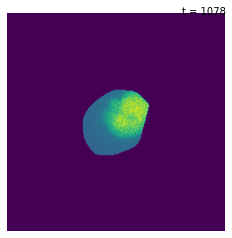

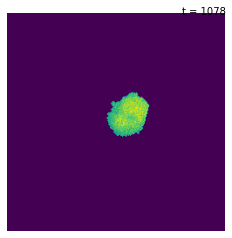

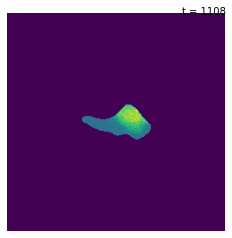

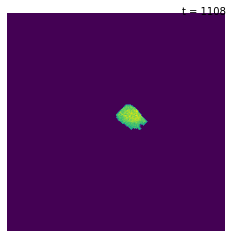

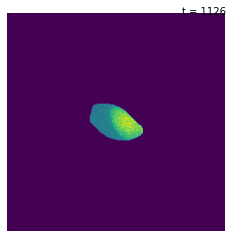

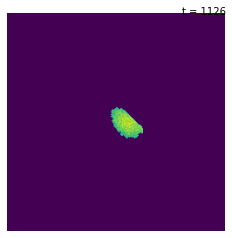

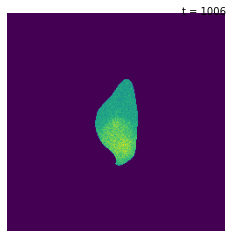

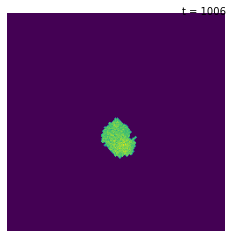

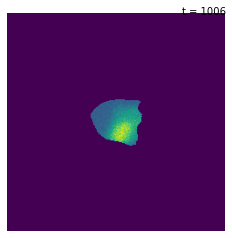

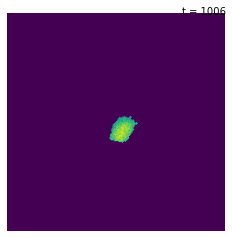

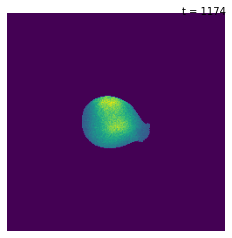

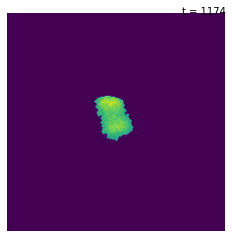

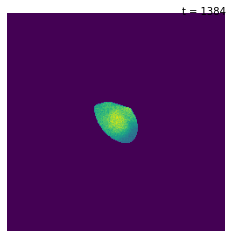

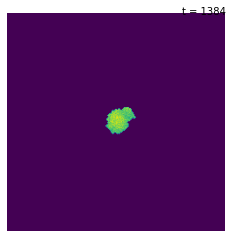

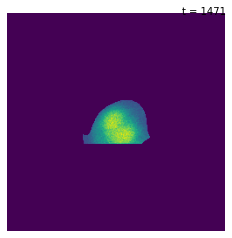

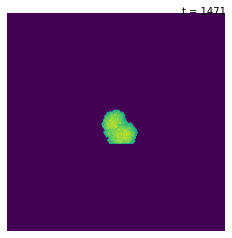

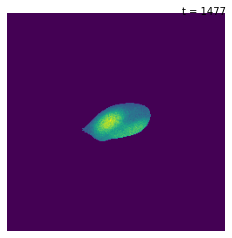

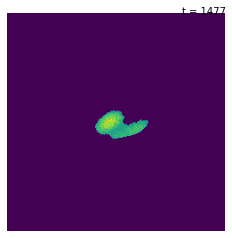

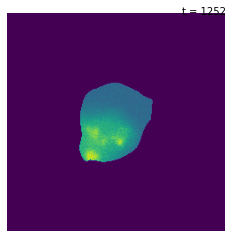

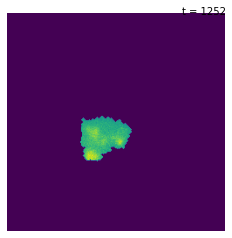

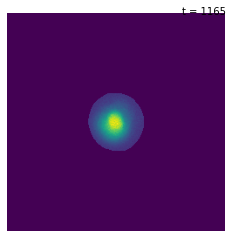

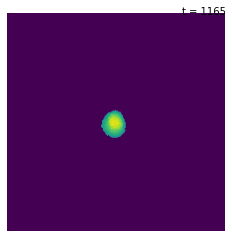

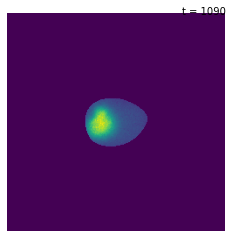

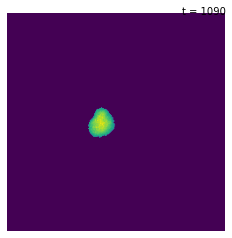

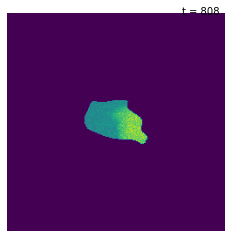

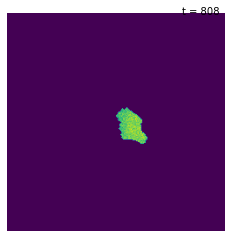

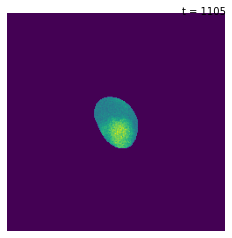

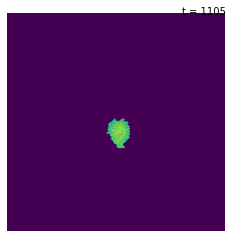

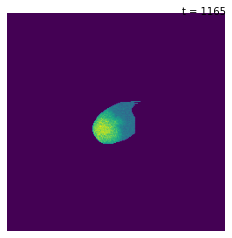

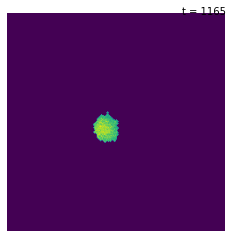

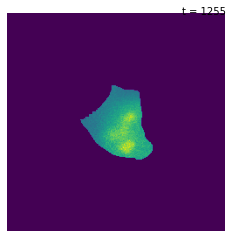

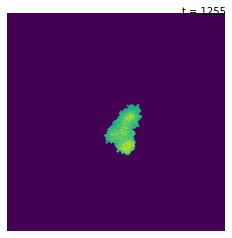

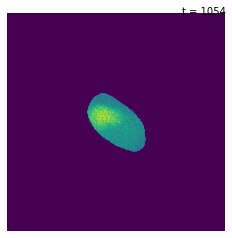

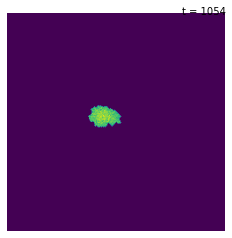

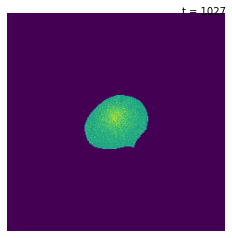

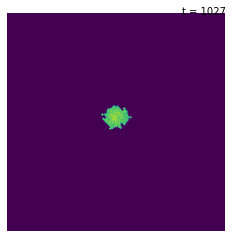

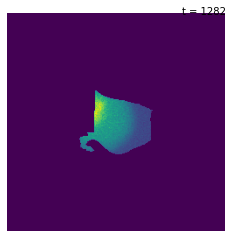

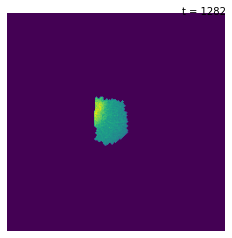

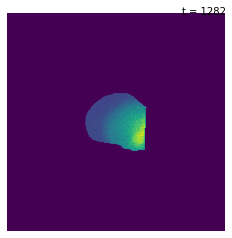

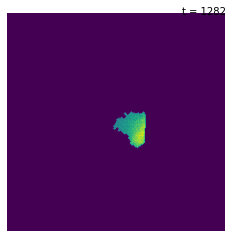

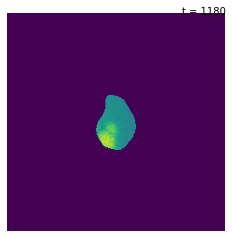

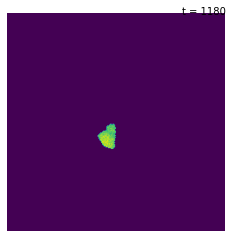

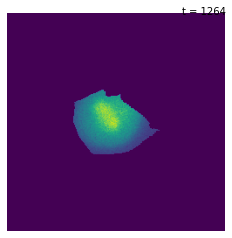

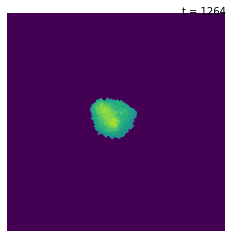

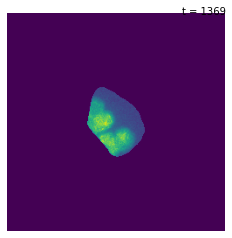

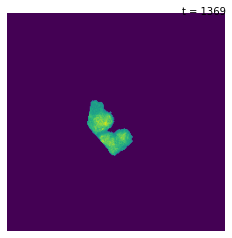

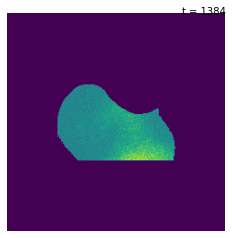

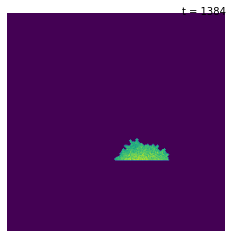

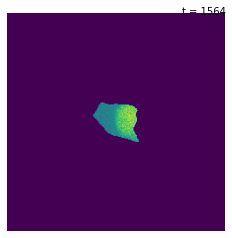

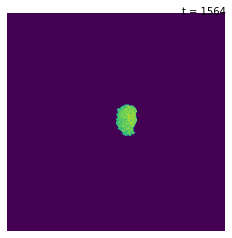

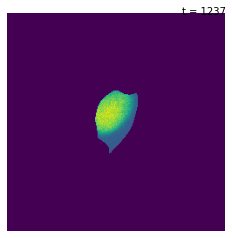

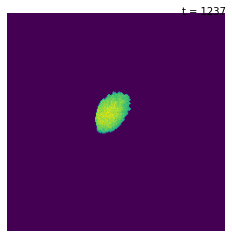

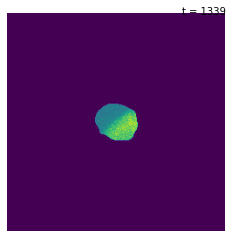

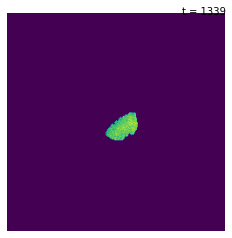

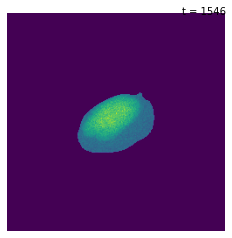

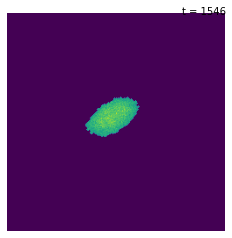

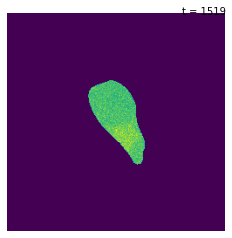

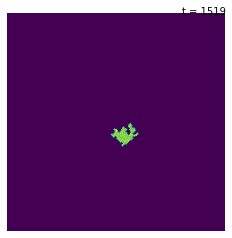

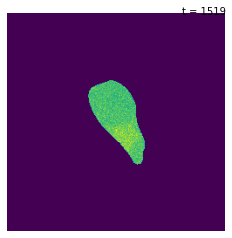

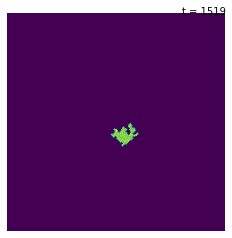

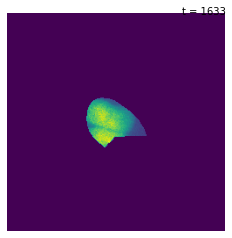

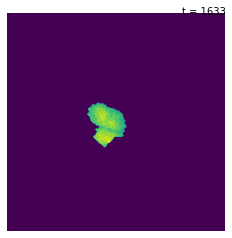

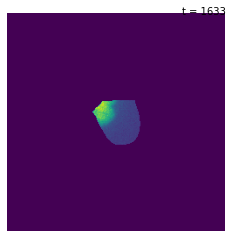

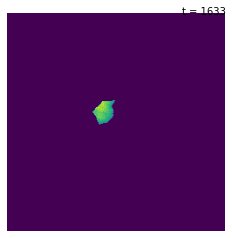

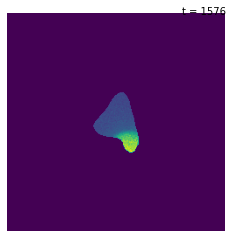

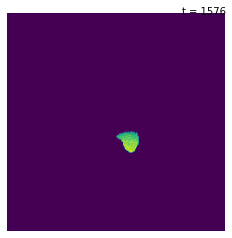

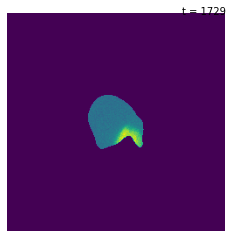

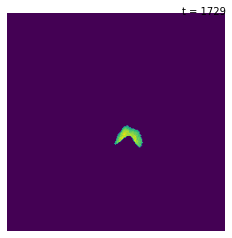

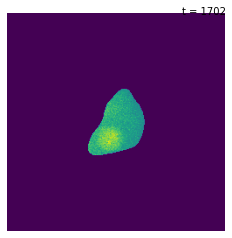

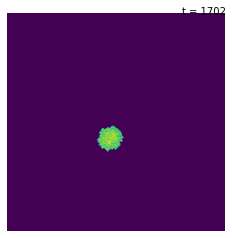

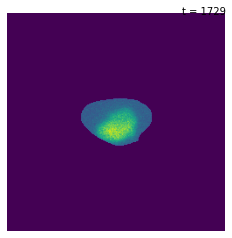

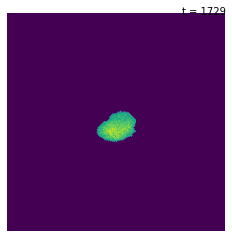

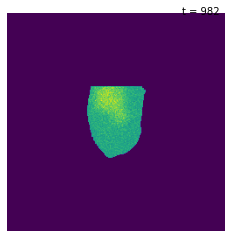

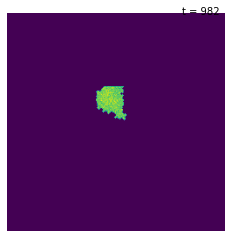

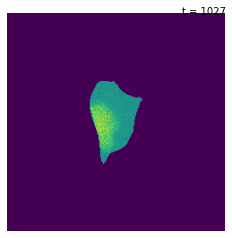

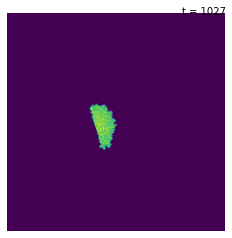

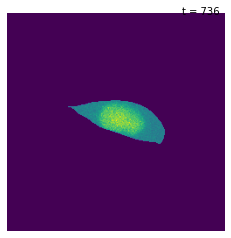

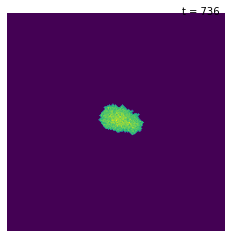

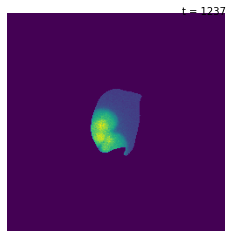

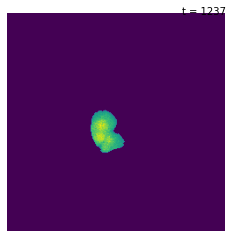

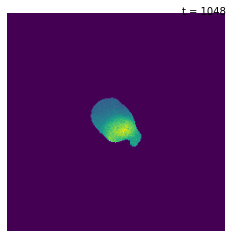

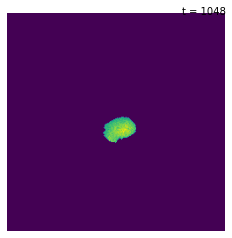

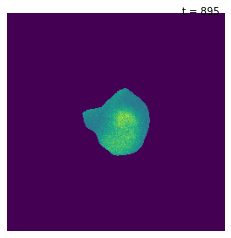

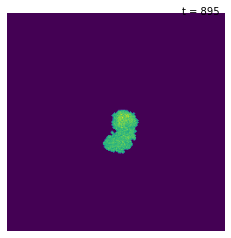

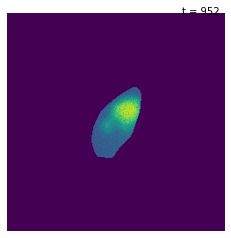

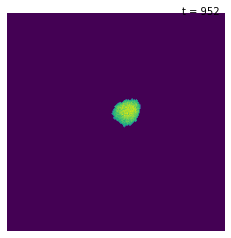

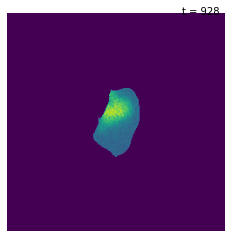

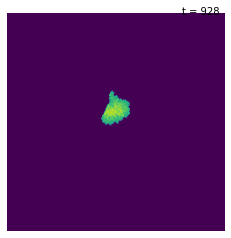

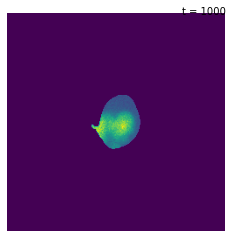

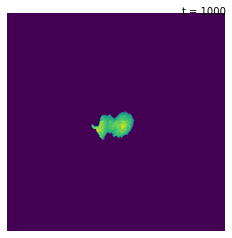

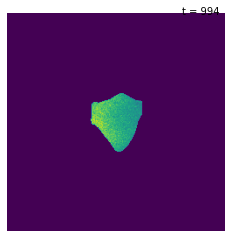

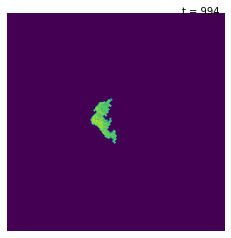

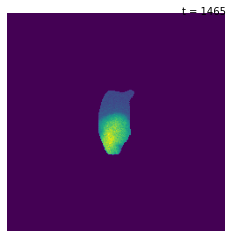

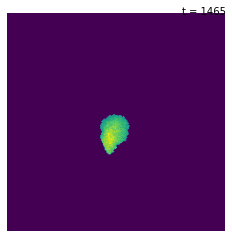

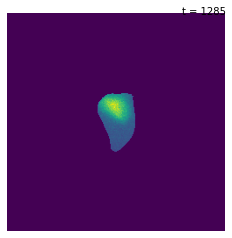

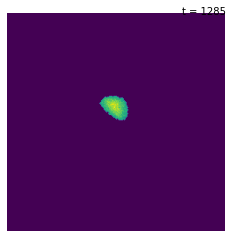

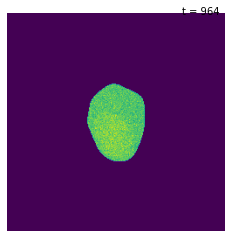

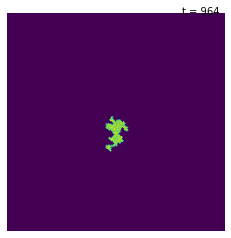

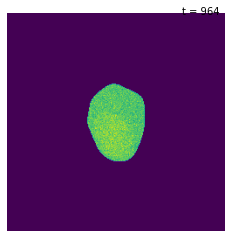

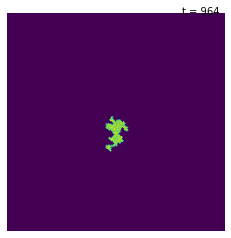

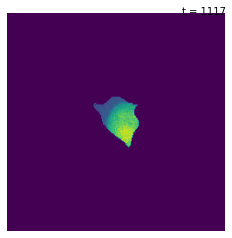

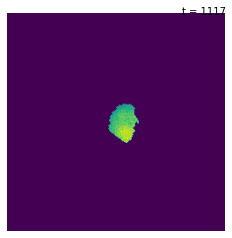

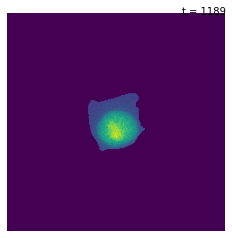

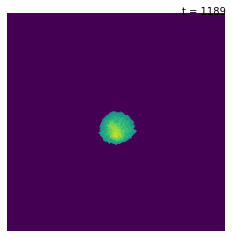

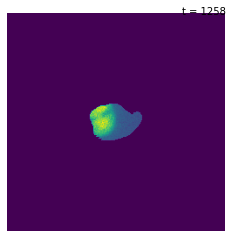

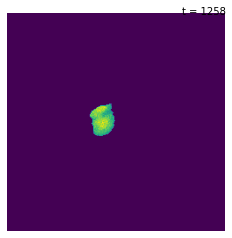

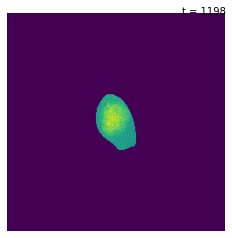

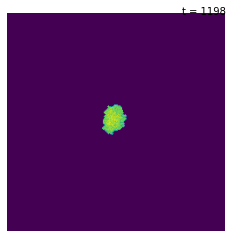

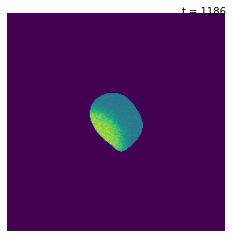

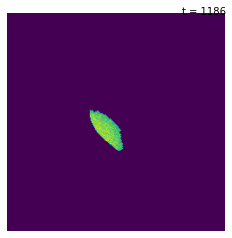

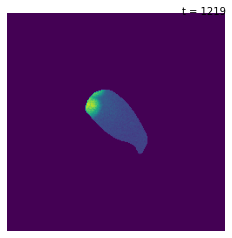

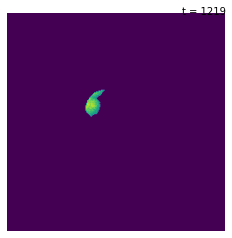

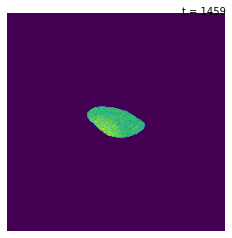

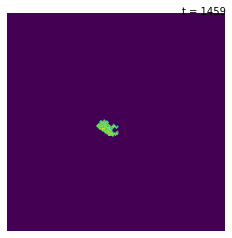

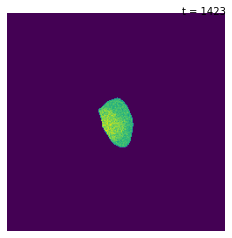

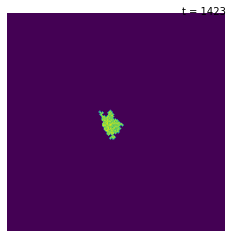

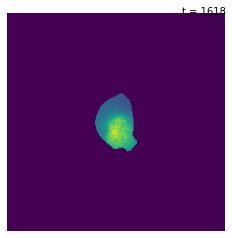

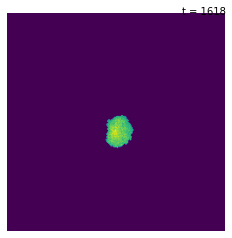

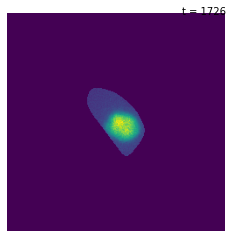

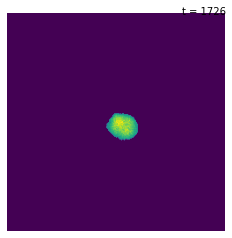

In [12]:
for posi in range(1,posi_end+1):
    posi_label = 'XY' + str(posi)
    print(posi_label)
    
    dir_path=output_path+posi_label+'/'
    fluor_img_path=main_path+'ori/'+posi_label+'_C2/'
    fluor_img_list=sorted(listdir(fluor_img_path))
    seg_path=output_path+posi_label+'/seg/'
    seg_list=sorted(listdir(seg_path))
        
    df=pd.read_csv(dir_path+'Per_Object_relink.csv')
    am_record=pd.read_csv(dir_path+'am_record.csv')
    traj_df=pd.read_csv(dir_path+'traj_object_num.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record.csv')
    with open (dir_path+'cells/'+'fluor_cells', 'rb') as fp:
        cells = pickle.load(fp)

    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values
    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]

    for traj_label in range(1,traj_quan+1):
        print(traj_label)
        cur_traj=traj_record[traj_label-1,:]
        traj_start_t=np.where(cur_traj!=-1)[0][0]+1
        daughter_flag=find_mother(df,mitosis_df,traj_label)
        if daughter_flag==1:
            mother_trajnum=find_mother_trajnum(mitosis_df)

        family_tree={}
        family_tree=find_offspring(df,mitosis_df,family_tree,traj_label=traj_label)
        print('family',family_tree)
        all_branches=list(list(parse(traj_label, family_tree)))
        print('all branch',all_branches)

        for branch in all_branches:   
            branch_end_label=branch[-1]
            branch_end_traj=traj_record[branch_end_label-1,:]
            branch_end_t=np.where(branch_end_traj!=-1)[0][-1]+1

            long_traj=-1*np.ones((time_span,))
            divide_points=[]
            traj_name=''
            for sub_label in branch:
                sub_traj=traj_record[sub_label-1,:]
                mask=sub_traj!=-1
                if (np.where(sub_traj!=-1)[0][-1]+1)!=branch_end_t:
                    divide_points.append(np.where(sub_traj!=-1)[0][-1]+1)
                long_traj[mask]=sub_traj[mask]
                traj_name=traj_name+str(sub_label)+'_'                      
                
            whole_branch=long_traj[traj_start_t-1:branch_end_t]

            long_traj_loss_ratio=whole_branch[whole_branch==-1].shape[0]*1.0/whole_branch.shape[0]
            print(whole_branch.shape[0])
            if long_traj_loss_ratio<loss_ratio_thres and (branch_end_t-traj_start_t)>=traj_len_thres:

                traj_feature,traj_contour,\
                    traj_cord,traj_seri,traj_am_flag,\
                    traj_vim_feature_values,traj_vim_pca_cord,\
                    traj_pcna_feature_values,traj_pcna_pca_cord=generate_fluor_long_traj(
                    df,cells,am_record,\
                    traj_df,long_traj,\
                    ['vimentin','pcna'],feature_list,fluor_feature_name)
                if len(traj_seri) >= 15:
                    traj_sct=fluor_single_cell_traj(traj_seri,traj_contour)
                    traj_sct.set_traj_feature(traj_feature)
                    traj_sct.set_traj_cord(traj_cord)
                    traj_sct.set_traj_divide_points(np.array(divide_points))
                    traj_sct.set_traj_am_flag(traj_am_flag)

                    traj_sct.set_traj_fluor_features('vimentin',feature_list,traj_vim_feature_values)
                    traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[0],traj_vim_pca_cord)

                    traj_sct.set_traj_fluor_features('pcna',feature_list,traj_pcna_feature_values)
                    traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[1],traj_pcna_pca_cord)

                    if branch_end_label==traj_label:
                        print('not saving this one chief')
#                         with open(sct_path+'fluor_sct_'+posi_label+'_'+traj_name+'long_traj', 'wb') as fp:
#                             pickle.dump(traj_sct, fp)
                    else:
                        with open(sct_path+'indirect_fluor_sct_'+posi_label+'_'+traj_name+'long_traj', 'wb') as fp:
                            pickle.dump(traj_sct, fp)


                        board_size=250

                        fig=plt.figure()
                        ax = fig.add_subplot(111)
                        ims=[]
                        for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:
                            img_num=img_num.astype(np.int)
                            obj_num=obj_num.astype(np.int)
                            if obj_num!=-1:
                                img=imread(fluor_img_path+fluor_img_list[img_num-1])
                                seg_img=imread(seg_path+seg_list[img_num-1])
                                crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
                                x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
                                x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                cell_on_board=np.zeros((board_size,board_size))
                                cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell
                                plt.axis('off')
                                im=plt.imshow(cell_on_board,animated=True)
                                t = ax.annotate('t = ' + str(img_num),(200,1))
                                ims.append([im,t])

                            ani = animation.ArtistAnimation(fig, ims)
                            ani = animation.ArtistAnimation(fig, ims)
                            Writer = animation.writers['ffmpeg']
                            writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                        ani.save(cell_ani_path+'indirect_pcna_sct_'+posi_label+'_'+traj_name+'long_traj.mp4',writer)

                        fig=plt.figure()
                        ax = fig.add_subplot(111)
                        ims=[]
                        for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:

                            img_num=img_num.astype(np.int)
                            obj_num=obj_num.astype(np.int)

                            img=imread(fluor_img_path+fluor_img_list[img_num-1])
                            seg=imread(seg_path+seg_list[img_num-1])

                            if obj_num!=-1:

                                rps=regionprops(seg)
                                candi_r=[r for r in rps if r.label==obj_num][0]
                                candi_box=candi_r.bbox

                                cell_mask = (seg == obj_num)
                                region_cell_mask = cell_mask[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                crop_img = img[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                cell_img = (img*cell_mask)[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]

                                nuc_mask=cell_img>otsu(cell_img,selem=disk(max(cell_img.shape)/2), mask=cell_img>0)
                                nuc_mask=remove_small_objects(opening(nuc_mask),100)
                                nuc_mask=closing(nuc_mask)
                                nuc_mask=remove_small_holes(nuc_mask,100)

                                nuc_img=cell_img*nuc_mask

                                x_c,y_c=nuc_img.shape[0]//2,nuc_img.shape[1]//2
                                x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                cell_on_board=np.zeros((board_size,board_size))
                                cell_on_board[x_l:x_l+nuc_img.shape[0],y_l:y_l+nuc_img.shape[1]]=nuc_img
                                plt.axis('off')
                                im=plt.imshow(cell_on_board,animated=True)
                                t = ax.annotate('t = ' + str(img_num),(200,1))
                                ims.append([im,t])

        #                 ani = animation.ArtistAnimation(fig, ims)
                        ani = animation.ArtistAnimation(fig, ims)
                        Writer = animation.writers['ffmpeg']
                        writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                        ani.save(cell_nuc_ani_path+'indirect_pcna_sct_'+posi_label+'_'+traj_name+'long_traj.mp4',writer)

XY1
1
family {}
all branch [[1]]
2
family {}
all branch [[2]]
3
family {}
all branch [[3]]
4
family {4: [15, 16]}
all branch [[4, 15], [4, 16]]
this cell has pca cord
6
this cell has pca cord
6
5
family {}
all branch [[5]]
6
family {}
all branch [[6]]
7
family {7: [100, 101]}
all branch [[7, 100], [7, 101]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
8
family {}
all branch [[8]]
9
family {}
all branch [[9]]
10
family {}
all branch [[10]]
11
family {11: [37, 38]}
all branch [[11, 37], [11, 38]]
12
family {12: [58, 57]}
all branch [[12, 58], [12, 57]]
13
family {13: [48, 49]}
all branch [[13, 48], [13, 49]]
this cell has pca cord
6
this cell has pca cord
6
14
family {}
all branch [[14]]
15
16
17
family {17: [39, 40], 40: [176, 177]}
all branch [[17, 39], [17, 40, 176], [17, 40, 177]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
18
family {}
all branch [[18]]
19
family {}
all bra

this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
279
family {}
all branch [[279]]
280
family {}
all branch [[280]]
281
family {}
all branch [[281]]
282
family {}
all branch [[282]]
283
family {}
all branch [[283]]
284
family {}
all branch [[284]]
285
family {}
all branch [[285]]
286
family {}
all branch [[286]]
287
family {}
all branch [[287]]
288
family {}
all branch [[288]]
289
family {}
all branch [[289]]
290
family {}
all branch [[290]]
291
family {}
all branch [[291]]
292
family {}
all branch [[292]]
293
family {}
all branch [[293]]
294
family {}
all branch [[294]]
295
family {}
all branch [[295]]
296
family {}
all branch [[296]]
297
family {}
all branch [[297]]
298
family {}
all branch [[298]]
299
family {}
all branch [[299]]
300
family {300: [481, 479]}
all branch [[300, 481], [300

family {}
all branch [[712]]
713
family {}
all branch [[713]]
714
family {}
all branch [[714]]
715
family {715: [1370, 1367]}
all branch [[715, 1370], [715, 1367]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
716
family {}
all branch [[716]]
717
family {}
all branch [[717]]
718
family {718: [1450, 1452]}
all branch [[718, 1450], [718, 1452]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
719
family {}
all branch [[719]]
720
family {}
all branch [[720]]
721
family {}
all branch [[721]]
722
family {}
all branch [[722]]
723
724
family {}
all branch [[724]]
725
family {}
all branch [[725]]
726
727
family {}
all branch [[727]]
728
family {}
all branch [[728]]
729
family {}
all branch [[729]]
730
family {}
all branch [[730]]
731
family {}
all branch [[731]]
732
family {}
all branch [[732]]
733
family {}
all branch [[733]]
734
family {}


family {}
all branch [[1032]]
1033
family {}
all branch [[1033]]
1034
family {}
all branch [[1034]]
1035
family {}
all branch [[1035]]
1036
family {}
all branch [[1036]]
1037
family {}
all branch [[1037]]
1038
family {}
all branch [[1038]]
1039
family {}
all branch [[1039]]
1040
family {}
all branch [[1040]]
1041
family {}
all branch [[1041]]
1042
family {}
all branch [[1042]]
1043
family {}
all branch [[1043]]
1044
family {}
all branch [[1044]]
1045
family {}
all branch [[1045]]
1046
family {}
all branch [[1046]]
1047
family {}
all branch [[1047]]
1048
family {}
all branch [[1048]]
1049
family {}
all branch [[1049]]
1050
family {}
all branch [[1050]]
1051
family {}
all branch [[1051]]
1052
family {}
all branch [[1052]]
1053
family {}
all branch [[1053]]
1054
family {}
all branch [[1054]]
1055
family {}
all branch [[1055]]
1056
family {}
all branch [[1056]]
1057
family {}
all branch [[1057]]
1058
family {}
all branch [[1058]]
1059
family {}
all branch [[1059]]
1060
family {}
all branch

family {}
all branch [[1298]]
1299
family {}
all branch [[1299]]
1300
family {}
all branch [[1300]]
1301
family {}
all branch [[1301]]
1302
family {}
all branch [[1302]]
1303
family {1303: [1463, 1462]}
all branch [[1303, 1463], [1303, 1462]]
1304
family {}
all branch [[1304]]
1305
family {}
all branch [[1305]]
1306
family {}
all branch [[1306]]
1307
family {}
all branch [[1307]]
1308
family {}
all branch [[1308]]
1309
family {}
all branch [[1309]]
1310
family {}
all branch [[1310]]
1311
family {}
all branch [[1311]]
1312
family {}
all branch [[1312]]
1313
family {}
all branch [[1313]]
1314
family {}
all branch [[1314]]
1315
1316
family {1316: [1419, 1417]}
all branch [[1316, 1419], [1316, 1417]]
1317
1318
family {}
all branch [[1318]]
1319
family {}
all branch [[1319]]
1320
family {}
all branch [[1320]]
1321
family {}
all branch [[1321]]
1322
1323
family {}
all branch [[1323]]
1324
1325
family {}
all branch [[1325]]
1326
family {}
all branch [[1326]]
1327
family {}
all branch [[1327]]

1549
family {}
all branch [[1549]]
1550
family {}
all branch [[1550]]
1551
family {}
all branch [[1551]]
1552
family {}
all branch [[1552]]
1553
family {}
all branch [[1553]]
1554
family {}
all branch [[1554]]
1555
family {}
all branch [[1555]]
1556
family {}
all branch [[1556]]
1557
family {}
all branch [[1557]]
1558
family {}
all branch [[1558]]
1559
family {}
all branch [[1559]]
1560
family {}
all branch [[1560]]
1561
family {}
all branch [[1561]]
1562
family {}
all branch [[1562]]
1563
family {}
all branch [[1563]]
1564
family {}
all branch [[1564]]
1565
family {}
all branch [[1565]]
1566
family {}
all branch [[1566]]
1567
family {}
all branch [[1567]]
1568
family {}
all branch [[1568]]
1569
family {}
all branch [[1569]]
1570
family {}
all branch [[1570]]
1571
family {}
all branch [[1571]]
1572
family {}
all branch [[1572]]
1573
family {}
all branch [[1573]]
1574
family {}
all branch [[1574]]
1575
family {}
all branch [[1575]]
1576
family {}
all branch [[1576]]
1577
family {}
all b

family {}
all branch [[1950]]
1951
family {}
all branch [[1951]]
1952
family {}
all branch [[1952]]
1953
family {}
all branch [[1953]]
1954
family {}
all branch [[1954]]
1955
family {}
all branch [[1955]]
1956
family {}
all branch [[1956]]
1957
family {}
all branch [[1957]]
1958
family {}
all branch [[1958]]
1959
family {}
all branch [[1959]]
1960
family {}
all branch [[1960]]
1961
family {}
all branch [[1961]]
1962
family {}
all branch [[1962]]
1963
family {}
all branch [[1963]]
1964
family {}
all branch [[1964]]
1965
family {}
all branch [[1965]]
1966
family {}
all branch [[1966]]
1967
family {}
all branch [[1967]]
1968
family {}
all branch [[1968]]
1969
family {}
all branch [[1969]]
1970
family {}
all branch [[1970]]
1971
family {}
all branch [[1971]]
1972
family {}
all branch [[1972]]
1973
family {}
all branch [[1973]]
1974
family {}
all branch [[1974]]
1975
family {}
all branch [[1975]]
1976
family {}
all branch [[1976]]
1977
family {}
all branch [[1977]]
1978
family {}
all branch

2290
family {}
all branch [[2290]]
2291
family {}
all branch [[2291]]
2292
family {}
all branch [[2292]]
2293
family {}
all branch [[2293]]
2294
2295
family {}
all branch [[2295]]
2296
family {}
all branch [[2296]]
2297
family {}
all branch [[2297]]
2298
family {}
all branch [[2298]]
2299
family {}
all branch [[2299]]
2300
family {}
all branch [[2300]]
2301
family {}
all branch [[2301]]
2302
family {}
all branch [[2302]]
2303
family {}
all branch [[2303]]
2304
family {}
all branch [[2304]]
2305
family {}
all branch [[2305]]
2306
family {}
all branch [[2306]]
2307
family {}
all branch [[2307]]
2308
family {2308: [2449, 2443]}
all branch [[2308, 2449], [2308, 2443]]
2309
family {}
all branch [[2309]]
2310
family {}
all branch [[2310]]
2311
family {}
all branch [[2311]]
2312
family {}
all branch [[2312]]
2313
family {}
all branch [[2313]]
2314
family {}
all branch [[2314]]
2315
family {}
all branch [[2315]]
2316
family {}
all branch [[2316]]
2317
family {}
all branch [[2317]]
2318
family 

family {}
all branch [[2560]]
2561
family {}
all branch [[2561]]
2562
family {}
all branch [[2562]]
2563
2564
family {}
all branch [[2564]]
2565
family {}
all branch [[2565]]
2566
family {}
all branch [[2566]]
2567
family {}
all branch [[2567]]
2568
family {}
all branch [[2568]]
2569
family {}
all branch [[2569]]
2570
family {}
all branch [[2570]]
2571
family {}
all branch [[2571]]
2572
family {}
all branch [[2572]]
2573
family {}
all branch [[2573]]
2574
family {}
all branch [[2574]]
2575
2576
family {}
all branch [[2576]]
2577
2578
2579
family {}
all branch [[2579]]
2580
2581
family {}
all branch [[2581]]
2582
family {}
all branch [[2582]]
2583
family {}
all branch [[2583]]
2584
family {}
all branch [[2584]]
2585
2586
2587
family {}
all branch [[2587]]
2588
family {}
all branch [[2588]]
2589
family {}
all branch [[2589]]
2590
family {}
all branch [[2590]]
2591
family {}
all branch [[2591]]
2592
family {}
all branch [[2592]]
2593
family {}
all branch [[2593]]
2594
family {}
all branch

family {}
all branch [[2915]]
2916
family {}
all branch [[2916]]
2917
family {}
all branch [[2917]]
2918
family {}
all branch [[2918]]
2919
family {}
all branch [[2919]]
2920
family {}
all branch [[2920]]
2921
family {}
all branch [[2921]]
2922
family {}
all branch [[2922]]
2923
family {2923: [3238, 3240]}
all branch [[2923, 3238], [2923, 3240]]
2924
family {}
all branch [[2924]]
2925
family {}
all branch [[2925]]
2926
family {}
all branch [[2926]]
2927
family {}
all branch [[2927]]
2928
family {}
all branch [[2928]]
2929
family {}
all branch [[2929]]
2930
family {}
all branch [[2930]]
2931
family {}
all branch [[2931]]
2932
family {}
all branch [[2932]]
2933
family {}
all branch [[2933]]
2934
family {}
all branch [[2934]]
2935
family {}
all branch [[2935]]
2936
family {}
all branch [[2936]]
2937
family {}
all branch [[2937]]
2938
family {}
all branch [[2938]]
2939
family {}
all branch [[2939]]
2940
family {}
all branch [[2940]]
2941
family {}
all branch [[2941]]
2942
family {}
all bra

family {}
all branch [[3216]]
3217
family {}
all branch [[3217]]
3218
family {}
all branch [[3218]]
3219
family {}
all branch [[3219]]
3220
family {}
all branch [[3220]]
3221
family {}
all branch [[3221]]
3222
family {}
all branch [[3222]]
3223
family {}
all branch [[3223]]
3224
family {}
all branch [[3224]]
3225
family {}
all branch [[3225]]
3226
family {}
all branch [[3226]]
3227
family {}
all branch [[3227]]
3228
family {}
all branch [[3228]]
3229
family {}
all branch [[3229]]
3230
family {}
all branch [[3230]]
3231
family {}
all branch [[3231]]
3232
family {}
all branch [[3232]]
3233
family {3233: [3338, 3337]}
all branch [[3233, 3338], [3233, 3337]]
3234
family {}
all branch [[3234]]
3235
family {}
all branch [[3235]]
3236
family {}
all branch [[3236]]
3237
family {}
all branch [[3237]]
3238
3239
family {}
all branch [[3239]]
3240
3241
family {}
all branch [[3241]]
3242
family {}
all branch [[3242]]
3243
family {3243: [3408, 3410]}
all branch [[3243, 3408], [3243, 3410]]
3244
fami

all branch [[3633]]
3634
family {}
all branch [[3634]]
3635
family {}
all branch [[3635]]
3636
family {}
all branch [[3636]]
3637
family {}
all branch [[3637]]
3638
family {}
all branch [[3638]]
3639
family {}
all branch [[3639]]
3640
family {}
all branch [[3640]]
3641
family {}
all branch [[3641]]
3642
family {}
all branch [[3642]]
3643
family {}
all branch [[3643]]
3644
family {3644: [4107, 4108]}
all branch [[3644, 4107], [3644, 4108]]
3645
family {}
all branch [[3645]]
3646
family {}
all branch [[3646]]
3647
family {}
all branch [[3647]]
3648
family {}
all branch [[3648]]
3649
family {}
all branch [[3649]]
3650
family {}
all branch [[3650]]
3651
family {}
all branch [[3651]]
3652
3653
family {}
all branch [[3653]]
3654
family {}
all branch [[3654]]
3655
3656
family {}
all branch [[3656]]
3657
family {}
all branch [[3657]]
3658
family {}
all branch [[3658]]
3659
family {}
all branch [[3659]]
3660
family {}
all branch [[3660]]
3661
family {}
all branch [[3661]]
3662
family {}
all bra

family {}
all branch [[3968]]
3969
family {}
all branch [[3969]]
3970
family {}
all branch [[3970]]
3971
family {}
all branch [[3971]]
3972
family {}
all branch [[3972]]
3973
family {}
all branch [[3973]]
3974
family {}
all branch [[3974]]
3975
family {}
all branch [[3975]]
3976
family {}
all branch [[3976]]
3977
family {}
all branch [[3977]]
3978
family {}
all branch [[3978]]
3979
family {}
all branch [[3979]]
3980
family {}
all branch [[3980]]
3981
family {}
all branch [[3981]]
3982
family {}
all branch [[3982]]
3983
family {}
all branch [[3983]]
3984
family {}
all branch [[3984]]
3985
family {}
all branch [[3985]]
3986
family {}
all branch [[3986]]
3987
family {}
all branch [[3987]]
3988
family {}
all branch [[3988]]
3989
family {}
all branch [[3989]]
3990
family {}
all branch [[3990]]
3991
family {}
all branch [[3991]]
3992
family {}
all branch [[3992]]
3993
family {}
all branch [[3993]]
3994
family {}
all branch [[3994]]
3995
family {}
all branch [[3995]]
3996
family {}
all branch

1
family {1: [77, 76]}
all branch [[1, 77], [1, 76]]
this cell has pca cord
6
this cell has pca cord
6
2
family {}
all branch [[2]]
3
family {}
all branch [[3]]
4
family {}
all branch [[4]]
5
family {}
all branch [[5]]
6
family {6: [86, 87]}
all branch [[6, 86], [6, 87]]
this cell has pca cord
6
this cell has pca cord
6
7
family {}
all branch [[7]]
8
family {}
all branch [[8]]
9
family {9: [118, 119]}
all branch [[9, 118], [9, 119]]
10
family {}
all branch [[10]]
11
family {}
all branch [[11]]
12
family {}
all branch [[12]]
13
family {}
all branch [[13]]
14
family {}
all branch [[14]]
15
family {}
all branch [[15]]
16
family {}
all branch [[16]]
17
family {17: [75, 73], 73: [184, 185], 185: [238, 237]}
all branch [[17, 75], [17, 73, 184], [17, 73, 185, 238], [17, 73, 185, 237]]
18
family {}
all branch [[18]]
19
family {}
all branch [[19]]
20
family {}
all branch [[20]]
21
family {}
all branch [[21]]
22
family {}
all branch [[22]]
23
family {}
all branch [[23]]
24
family {}
all branch [

this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
261
family {}
all branch [[261]]
262
family {}
all branch [[262]]
263
264
265
family {}
all branch [[265]]
266
family {}
all branch [[266]]
267
family {}
all branch [[267]]
268
family {}
all branch [[268]]
269
family {}
all branch [[269]]
270
family {}
all branch [[270]]
271
family {}
all branch [[271]]
272
family {}
all branch [[272]]
273
family {}
all branch [[273]]
274
family {}
all branch [[274]]
275
family {}
all branch [[275]]
276
family {}
all branch [[276]]
277
family {}
all branch [[277]]
278
family {}
all branch [[278]]
279
family {}
all branch [[279]]
280
family {280: [291, 290]}
all branch [[280, 291], [280, 290]]
281
family {}
all branch [[281]]
282
family {}
all branch [[282]]
283
family {}
all branch [[283]]
284
family {}
all branch [[284]]
285
family {}
all branch [[285]]
286
family {}
all branch [[286]]
287
family {}
all branch [[287]]
288
family {}
all branch [[288]]
28

this cell has pca cord
6
this cell has pca cord
6
582
family {}
all branch [[582]]
583
family {}
all branch [[583]]
584
family {}
all branch [[584]]
585
family {}
all branch [[585]]
586
family {}
all branch [[586]]
587
family {}
all branch [[587]]
588
family {}
all branch [[588]]
589
family {}
all branch [[589]]
590
family {}
all branch [[590]]
591
family {}
all branch [[591]]
592
family {}
all branch [[592]]
593
family {}
all branch [[593]]
594
family {}
all branch [[594]]
595
family {}
all branch [[595]]
596
family {}
all branch [[596]]
597
family {}
all branch [[597]]
598
family {}
all branch [[598]]
599
family {}
all branch [[599]]
600
family {}
all branch [[600]]
601
family {601: [620, 619]}
all branch [[601, 620], [601, 619]]
602
family {602: [839, 840]}
all branch [[602, 839], [602, 840]]
603
family {}
all branch [[603]]
604
family {}
all branch [[604]]
605
family {}
all branch [[605]]
606
family {}
all branch [[606]]
607
family {}
all branch [[607]]
608
family {}
all branch [[6

this cell has pca cord
6
this cell has pca cord
6
898
family {}
all branch [[898]]
899
family {}
all branch [[899]]
900
family {}
all branch [[900]]
901
family {}
all branch [[901]]
902
family {}
all branch [[902]]
903
family {}
all branch [[903]]
904
family {}
all branch [[904]]
905
family {}
all branch [[905]]
906
family {}
all branch [[906]]
907
family {}
all branch [[907]]
908
family {}
all branch [[908]]
909
family {}
all branch [[909]]
910
family {}
all branch [[910]]
911
family {}
all branch [[911]]
912
family {}
all branch [[912]]
913
family {}
all branch [[913]]
914
family {}
all branch [[914]]
915
family {}
all branch [[915]]
916
family {}
all branch [[916]]
917
family {}
all branch [[917]]
918
family {}
all branch [[918]]
919
family {}
all branch [[919]]
920
family {}
all branch [[920]]
921
family {}
all branch [[921]]
922
family {}
all branch [[922]]
923
family {}
all branch [[923]]
924
family {}
all branch [[924]]
925
family {}
all branch [[925]]
926
family {}
all branch [

family {}
all branch [[1280]]
1281
family {}
all branch [[1281]]
1282
family {}
all branch [[1282]]
1283
family {}
all branch [[1283]]
1284
1285
1286
1287
1288
family {}
all branch [[1288]]
1289
family {}
all branch [[1289]]
1290
family {}
all branch [[1290]]
1291
family {}
all branch [[1291]]
1292
family {}
all branch [[1292]]
1293
family {}
all branch [[1293]]
1294
family {}
all branch [[1294]]
1295
family {}
all branch [[1295]]
1296
family {}
all branch [[1296]]
1297
1298
1299
family {}
all branch [[1299]]
1300
family {}
all branch [[1300]]
1301
family {}
all branch [[1301]]
1302
family {}
all branch [[1302]]
1303
family {}
all branch [[1303]]
1304
family {1304: [1449, 1448]}
all branch [[1304, 1449], [1304, 1448]]
1305
family {1305: [1315, 1316]}
all branch [[1305, 1315], [1305, 1316]]
1306
family {}
all branch [[1306]]
1307
family {}
all branch [[1307]]
1308
family {}
all branch [[1308]]
1309
family {}
all branch [[1309]]
1310
family {}
all branch [[1310]]
1311
family {}
all branc

family {}
all branch [[1567]]
1568
family {}
all branch [[1568]]
1569
family {}
all branch [[1569]]
1570
family {}
all branch [[1570]]
1571
family {}
all branch [[1571]]
1572
family {}
all branch [[1572]]
1573
family {}
all branch [[1573]]
1574
family {}
all branch [[1574]]
1575
family {}
all branch [[1575]]
1576
family {}
all branch [[1576]]
1577
family {}
all branch [[1577]]
1578
family {}
all branch [[1578]]
1579
family {}
all branch [[1579]]
1580
family {}
all branch [[1580]]
1581
family {}
all branch [[1581]]
1582
family {}
all branch [[1582]]
1583
family {}
all branch [[1583]]
1584
family {}
all branch [[1584]]
1585
family {}
all branch [[1585]]
1586
family {}
all branch [[1586]]
1587
family {}
all branch [[1587]]
1588
family {1588: [1631, 1634]}
all branch [[1588, 1631], [1588, 1634]]
1589
family {}
all branch [[1589]]
1590
family {}
all branch [[1590]]
1591
family {}
all branch [[1591]]
1592
family {}
all branch [[1592]]
1593
family {}
all branch [[1593]]
1594
family {}
all bra

family {}
all branch [[1853]]
1854
family {}
all branch [[1854]]
1855
family {}
all branch [[1855]]
1856
family {}
all branch [[1856]]
1857
family {}
all branch [[1857]]
1858
family {}
all branch [[1858]]
1859
family {}
all branch [[1859]]
1860
family {}
all branch [[1860]]
1861
family {}
all branch [[1861]]
1862
family {1862: [2298, 2300], 2300: [2308, 2307]}
all branch [[1862, 2298], [1862, 2300, 2308], [1862, 2300, 2307]]
1863
family {}
all branch [[1863]]
1864
family {}
all branch [[1864]]
1865
family {}
all branch [[1865]]
1866
family {}
all branch [[1866]]
1867
family {}
all branch [[1867]]
1868
family {}
all branch [[1868]]
1869
family {}
all branch [[1869]]
1870
family {}
all branch [[1870]]
1871
family {}
all branch [[1871]]
1872
family {}
all branch [[1872]]
1873
family {}
all branch [[1873]]
1874
family {}
all branch [[1874]]
1875
family {}
all branch [[1875]]
1876
family {}
all branch [[1876]]
1877
family {}
all branch [[1877]]
1878
family {}
all branch [[1878]]
1879
family

this cell has pca cord
6
this cell has pca cord
6
2147
family {}
all branch [[2147]]
2148
family {}
all branch [[2148]]
2149
family {}
all branch [[2149]]
2150
family {}
all branch [[2150]]
2151
family {}
all branch [[2151]]
2152
family {}
all branch [[2152]]
2153
family {}
all branch [[2153]]
2154
family {}
all branch [[2154]]
2155
family {2155: [2455, 2454]}
all branch [[2155, 2455], [2155, 2454]]
2156
family {}
all branch [[2156]]
2157
family {}
all branch [[2157]]
2158
family {}
all branch [[2158]]
2159
family {}
all branch [[2159]]
2160
family {}
all branch [[2160]]
2161
family {}
all branch [[2161]]
2162
family {}
all branch [[2162]]
2163
family {}
all branch [[2163]]
2164
family {}
all branch [[2164]]
2165
family {}
all branch [[2165]]
2166
family {}
all branch [[2166]]
2167
family {}
all branch [[2167]]
2168
family {}
all branch [[2168]]
2169
family {}
all branch [[2169]]
2170
family {2170: [2689, 2693]}
all branch [[2170, 2689], [2170, 2693]]
2171
family {}
all branch [[2171]]

2408
family {2408: [4842, 4841]}
all branch [[2408, 4842], [2408, 4841]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
2409
family {}
all branch [[2409]]
2410
family {}
all branch [[2410]]
2411
family {2411: [2438, 2437]}
all branch [[2411, 2438], [2411, 2437]]
2412
family {}
all branch [[2412]]
2413
family {}
all branch [[2413]]
2414
family {}
all branch [[2414]]
2415
family {}
all branch [[2415]]
2416
family {}
all branch [[2416]]
2417
family {}
all branch [[2417]]
2418
family {}
all branch [[2418]]
2419
family {}
all branch [[2419]]
2420
family {}
all branch [[2420]]
2421
family {}
all branch [[2421]]
2422
family {}
all branch [[2422]]
2423
family {}
all branch [[2423]]
2424
family {}
all branch [[2424]]
2425
family {}
all branch [[2425]]
2426
family {}
all branch [[2426]]
2427
family {}
all branch [[2427]]
2428
family {}
all branch [[2428]]
2429
family {}
all branch [[2429]]
2430

family {}
all branch [[2737]]
2738
family {2738: [4482, 4480]}
all branch [[2738, 4482], [2738, 4480]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
2739
family {2739: [3410, 3417]}
all branch [[2739, 3410], [2739, 3417]]
2740
family {}
all branch [[2740]]
2741
family {}
all branch [[2741]]
2742
family {}
all branch [[2742]]
2743
family {}
all branch [[2743]]
2744
2745
2746
family {}
all branch [[2746]]
2747
family {}
all branch [[2747]]
2748
family {}
all branch [[2748]]
2749
family {}
all branch [[2749]]
2750
family {}
all branch [[2750]]
2751
family {2751: [2890, 2889]}
all branch [[2751, 2890], [2751, 2889]]
2752
family {}
all branch [[2752]]
2753
family {}
all branch [[2753]]
2754
family {}
all branch [[2754]]
2755
family {}
all branch [[2755]]
2756
2757
family {}
all branch [[2757]]
2758
family {}
all branch [[2758]]
2759
family {}
all branch [[2759]]
2760
2761
family {}
all br

family {}
all branch [[3029]]
3030
family {}
all branch [[3030]]
3031
family {}
all branch [[3031]]
3032
family {}
all branch [[3032]]
3033
family {}
all branch [[3033]]
3034
family {}
all branch [[3034]]
3035
family {}
all branch [[3035]]
3036
family {}
all branch [[3036]]
3037
family {}
all branch [[3037]]
3038
family {}
all branch [[3038]]
3039
family {}
all branch [[3039]]
3040
family {}
all branch [[3040]]
3041
family {}
all branch [[3041]]
3042
family {}
all branch [[3042]]
3043
family {}
all branch [[3043]]
3044
family {}
all branch [[3044]]
3045
family {}
all branch [[3045]]
3046
family {}
all branch [[3046]]
3047
family {}
all branch [[3047]]
3048
family {}
all branch [[3048]]
3049
family {}
all branch [[3049]]
3050
family {}
all branch [[3050]]
3051
family {}
all branch [[3051]]
3052
family {}
all branch [[3052]]
3053
family {}
all branch [[3053]]
3054
family {}
all branch [[3054]]
3055
family {}
all branch [[3055]]
3056
family {}
all branch [[3056]]
3057
family {}
all branch

family {}
all branch [[3331]]
3332
family {}
all branch [[3332]]
3333
family {}
all branch [[3333]]
3334
family {}
all branch [[3334]]
3335
family {}
all branch [[3335]]
3336
family {}
all branch [[3336]]
3337
family {}
all branch [[3337]]
3338
family {}
all branch [[3338]]
3339
family {}
all branch [[3339]]
3340
family {}
all branch [[3340]]
3341
family {}
all branch [[3341]]
3342
family {}
all branch [[3342]]
3343
family {}
all branch [[3343]]
3344
family {}
all branch [[3344]]
3345
family {}
all branch [[3345]]
3346
family {}
all branch [[3346]]
3347
family {}
all branch [[3347]]
3348
family {}
all branch [[3348]]
3349
family {}
all branch [[3349]]
3350
family {}
all branch [[3350]]
3351
family {}
all branch [[3351]]
3352
family {}
all branch [[3352]]
3353
family {}
all branch [[3353]]
3354
family {}
all branch [[3354]]
3355
family {}
all branch [[3355]]
3356
family {}
all branch [[3356]]
3357
family {3357: [3409, 3415]}
all branch [[3357, 3409], [3357, 3415]]
3358
family {}
all bra

this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
3607
family {}
all branch [[3607]]
3608
family {}
all branch [[3608]]
3609
family {}
all branch [[3609]]
3610
family {}
all branch [[3610]]
3611
family {}
all branch [[3611]]
3612
family {}
all branch [[3612]]
3613
family {}
all branch [[3613]]
3614
family {}
all branch [[3614]]
3615
family {}
all branch [[3615]]
3616
family {}
all branch [[3616]]
3617
family {}
all branch [[3617]]
3618
family {}
all branch [[3618]]
3619
family {}
all branch [[3619]]
3620
family {}
all branch [[3620]]
3621
family {}
all branch [[3621]]
3622
family {}
all branch [[3622]]
3623
family {}
all branch [[3623]]
3624
family {}
all branch [[3624]]
3625
family {}
all branch [[3625]]
3626
family {}
all branch [[3626]]
3627
family {}
all branch [[3627]]
3628
family {}
all branch [[3628]]
3629
family {}
all branch [[3629]]
3630
family {}
all branch [[3630]]
3631
family {}
all branch [[3631]]
3632
family {}
all branch

family {}
all branch [[3914]]
3915
family {}
all branch [[3915]]
3916
family {}
all branch [[3916]]
3917
family {3917: [4094, 4101]}
all branch [[3917, 4094], [3917, 4101]]
3918
family {}
all branch [[3918]]
3919
family {}
all branch [[3919]]
3920
family {}
all branch [[3920]]
3921
family {3921: [5265, 5266]}
all branch [[3921, 5265], [3921, 5266]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
3922
family {}
all branch [[3922]]
3923
family {}
all branch [[3923]]
3924
family {}
all branch [[3924]]
3925
family {}
all branch [[3925]]
3926
family {}
all branch [[3926]]
3927
family {}
all branch [[3927]]
3928
family {}
all branch [[3928]]
3929
family {}
all branch [[3929]]
3930
family {}
all branch [[3930]]
3931
family {}
all branch [[3931]]
3932
family {}
all branch [[3932]]
3933
family {3933: [4016, 4021]}
all branch [[3933, 4016], [3933, 4021]]
3934
family {}
all branch [[3934]]
3935
f

all branch [[4226]]
4227
family {}
all branch [[4227]]
4228
family {4228: [4547, 4543]}
all branch [[4228, 4547], [4228, 4543]]
4229
family {}
all branch [[4229]]
4230
family {}
all branch [[4230]]
4231
family {}
all branch [[4231]]
4232
family {}
all branch [[4232]]
4233
family {}
all branch [[4233]]
4234
family {}
all branch [[4234]]
4235
family {}
all branch [[4235]]
4236
family {}
all branch [[4236]]
4237
family {}
all branch [[4237]]
4238
family {}
all branch [[4238]]
4239
family {}
all branch [[4239]]
4240
family {}
all branch [[4240]]
4241
family {}
all branch [[4241]]
4242
family {}
all branch [[4242]]
4243
family {}
all branch [[4243]]
4244
family {}
all branch [[4244]]
4245
family {}
all branch [[4245]]
4246
family {}
all branch [[4246]]
4247
family {}
all branch [[4247]]
4248
family {}
all branch [[4248]]
4249
family {}
all branch [[4249]]
4250
family {}
all branch [[4250]]
4251
family {}
all branch [[4251]]
4252
family {}
all branch [[4252]]
4253
family {}
all branch [[4253

family {}
all branch [[4552]]
4553
family {}
all branch [[4553]]
4554
family {}
all branch [[4554]]
4555
family {}
all branch [[4555]]
4556
family {}
all branch [[4556]]
4557
family {}
all branch [[4557]]
4558
family {}
all branch [[4558]]
4559
family {}
all branch [[4559]]
4560
family {}
all branch [[4560]]
4561
family {}
all branch [[4561]]
4562
family {}
all branch [[4562]]
4563
family {}
all branch [[4563]]
4564
family {}
all branch [[4564]]
4565
family {}
all branch [[4565]]
4566
family {}
all branch [[4566]]
4567
family {}
all branch [[4567]]
4568
family {}
all branch [[4568]]
4569
family {}
all branch [[4569]]
4570
family {}
all branch [[4570]]
4571
family {}
all branch [[4571]]
4572
family {}
all branch [[4572]]
4573
family {}
all branch [[4573]]
4574
family {}
all branch [[4574]]
4575
family {}
all branch [[4575]]
4576
family {}
all branch [[4576]]
4577
family {}
all branch [[4577]]
4578
family {4578: [6207, 6202]}
all branch [[4578, 6207], [4578, 6202]]
this cell has pca cord

family {}
all branch [[4896]]
4897
family {}
all branch [[4897]]
4898
family {}
all branch [[4898]]
4899
family {}
all branch [[4899]]
4900
family {}
all branch [[4900]]
4901
family {}
all branch [[4901]]
4902
family {}
all branch [[4902]]
4903
family {}
all branch [[4903]]
4904
family {}
all branch [[4904]]
4905
family {}
all branch [[4905]]
4906
family {}
all branch [[4906]]
4907
family {}
all branch [[4907]]
4908
family {}
all branch [[4908]]
4909
family {}
all branch [[4909]]
4910
family {}
all branch [[4910]]
4911
family {}
all branch [[4911]]
4912
family {}
all branch [[4912]]
4913
family {}
all branch [[4913]]
4914
family {}
all branch [[4914]]
4915
4916
family {}
all branch [[4916]]
4917
family {}
all branch [[4917]]
4918
family {}
all branch [[4918]]
4919
family {}
all branch [[4919]]
4920
4921
family {}
all branch [[4921]]
4922
family {}
all branch [[4922]]
4923
family {}
all branch [[4923]]
4924
family {}
all branch [[4924]]
4925
family {}
all branch [[4925]]
4926
family {}


family {}
all branch [[5215]]
5216
family {}
all branch [[5216]]
5217
family {}
all branch [[5217]]
5218
family {}
all branch [[5218]]
5219
family {}
all branch [[5219]]
5220
family {}
all branch [[5220]]
5221
family {}
all branch [[5221]]
5222
family {}
all branch [[5222]]
5223
family {}
all branch [[5223]]
5224
family {}
all branch [[5224]]
5225
family {}
all branch [[5225]]
5226
family {}
all branch [[5226]]
5227
family {}
all branch [[5227]]
5228
family {}
all branch [[5228]]
5229
family {}
all branch [[5229]]
5230
family {}
all branch [[5230]]
5231
family {}
all branch [[5231]]
5232
family {}
all branch [[5232]]
5233
family {}
all branch [[5233]]
5234
family {}
all branch [[5234]]
5235
family {}
all branch [[5235]]
5236
family {}
all branch [[5236]]
5237
family {}
all branch [[5237]]
5238
family {}
all branch [[5238]]
5239
family {}
all branch [[5239]]
5240
family {}
all branch [[5240]]
5241
family {}
all branch [[5241]]
5242
family {}
all branch [[5242]]
5243
family {}
all branch

5478
family {}
all branch [[5478]]
5479
family {}
all branch [[5479]]
5480
family {}
all branch [[5480]]
5481
family {}
all branch [[5481]]
5482
family {}
all branch [[5482]]
5483
family {}
all branch [[5483]]
5484
family {}
all branch [[5484]]
5485
family {}
all branch [[5485]]
5486
family {}
all branch [[5486]]
5487
family {}
all branch [[5487]]
5488
family {}
all branch [[5488]]
5489
family {}
all branch [[5489]]
5490
family {}
all branch [[5490]]
5491
5492
5493
family {}
all branch [[5493]]
5494
family {}
all branch [[5494]]
5495
family {}
all branch [[5495]]
5496
family {}
all branch [[5496]]
5497
family {}
all branch [[5497]]
5498
family {}
all branch [[5498]]
5499
family {}
all branch [[5499]]
5500
family {}
all branch [[5500]]
5501
family {}
all branch [[5501]]
5502
family {}
all branch [[5502]]
5503
family {}
all branch [[5503]]
5504
family {}
all branch [[5504]]
5505
family {}
all branch [[5505]]
5506
family {}
all branch [[5506]]
5507
family {}
all branch [[5507]]
5508
famil

family {}
all branch [[5758]]
5759
family {}
all branch [[5759]]
5760
family {}
all branch [[5760]]
5761
family {}
all branch [[5761]]
5762
family {}
all branch [[5762]]
5763
family {}
all branch [[5763]]
5764
family {}
all branch [[5764]]
5765
family {}
all branch [[5765]]
5766
family {}
all branch [[5766]]
5767
family {}
all branch [[5767]]
5768
family {}
all branch [[5768]]
5769
family {}
all branch [[5769]]
5770
family {}
all branch [[5770]]
5771
family {}
all branch [[5771]]
5772
family {}
all branch [[5772]]
5773
family {}
all branch [[5773]]
5774
family {}
all branch [[5774]]
5775
family {}
all branch [[5775]]
5776
family {}
all branch [[5776]]
5777
family {}
all branch [[5777]]
5778
family {}
all branch [[5778]]
5779
family {}
all branch [[5779]]
5780
family {}
all branch [[5780]]
5781
family {}
all branch [[5781]]
5782
family {}
all branch [[5782]]
5783
family {}
all branch [[5783]]
5784
family {}
all branch [[5784]]
5785
family {}
all branch [[5785]]
5786
family {}
all branch

family {}
all branch [[6026]]
6027
family {}
all branch [[6027]]
6028
family {}
all branch [[6028]]
6029
family {}
all branch [[6029]]
6030
family {}
all branch [[6030]]
6031
family {}
all branch [[6031]]
6032
family {}
all branch [[6032]]
6033
family {}
all branch [[6033]]
6034
family {}
all branch [[6034]]
6035
family {}
all branch [[6035]]
6036
family {}
all branch [[6036]]
6037
family {}
all branch [[6037]]
6038
family {}
all branch [[6038]]
6039
family {}
all branch [[6039]]
6040
family {}
all branch [[6040]]
6041
family {}
all branch [[6041]]
6042
family {}
all branch [[6042]]
6043
family {}
all branch [[6043]]
6044
family {}
all branch [[6044]]
6045
family {}
all branch [[6045]]
6046
family {}
all branch [[6046]]
6047
family {}
all branch [[6047]]
6048
family {}
all branch [[6048]]
6049
family {}
all branch [[6049]]
6050
family {}
all branch [[6050]]
6051
family {}
all branch [[6051]]
6052
family {}
all branch [[6052]]
6053
family {}
all branch [[6053]]
6054
family {}
all branch

family {}
all branch [[6365]]
6366
family {}
all branch [[6366]]
6367
family {}
all branch [[6367]]
6368
family {}
all branch [[6368]]
6369
family {}
all branch [[6369]]
6370
family {}
all branch [[6370]]
6371
family {}
all branch [[6371]]
6372
family {}
all branch [[6372]]
6373
family {}
all branch [[6373]]
6374
family {}
all branch [[6374]]
6375
family {}
all branch [[6375]]
6376
family {}
all branch [[6376]]
6377
family {}
all branch [[6377]]
6378
family {}
all branch [[6378]]
6379
family {}
all branch [[6379]]
6380
family {}
all branch [[6380]]
6381
family {}
all branch [[6381]]
6382
family {}
all branch [[6382]]
6383
family {}
all branch [[6383]]
6384
family {}
all branch [[6384]]
6385
family {}
all branch [[6385]]
6386
family {}
all branch [[6386]]
6387
family {}
all branch [[6387]]
6388
family {}
all branch [[6388]]
6389
family {}
all branch [[6389]]
6390
family {}
all branch [[6390]]
6391
family {}
all branch [[6391]]
6392
family {}
all branch [[6392]]
6393
family {}
all branch

family {}
all branch [[6726]]
6727
family {}
all branch [[6727]]
6728
family {}
all branch [[6728]]
6729
family {}
all branch [[6729]]
6730
family {}
all branch [[6730]]
6731
family {}
all branch [[6731]]
6732
family {}
all branch [[6732]]
6733
family {}
all branch [[6733]]
6734
family {}
all branch [[6734]]
6735
family {}
all branch [[6735]]
6736
family {6736: [6822, 6819]}
all branch [[6736, 6822], [6736, 6819]]
6737
family {}
all branch [[6737]]
6738
family {}
all branch [[6738]]
6739
family {}
all branch [[6739]]
6740
family {}
all branch [[6740]]
6741
family {}
all branch [[6741]]
6742
family {}
all branch [[6742]]
6743
family {}
all branch [[6743]]
6744
family {}
all branch [[6744]]
6745
family {}
all branch [[6745]]
6746
family {}
all branch [[6746]]
6747
family {}
all branch [[6747]]
6748
family {}
all branch [[6748]]
6749
family {}
all branch [[6749]]
6750
family {}
all branch [[6750]]
6751
family {}
all branch [[6751]]
6752
family {}
all branch [[6752]]
6753
family {}
all bra

1
family {}
all branch [[1]]
2
family {}
all branch [[2]]
3
family {}
all branch [[3]]
4
family {4: [89, 86]}
all branch [[4, 89], [4, 86]]
this cell has pca cord
6
this cell has pca cord
6
5
family {}
all branch [[5]]
6
family {6: [98, 99]}
all branch [[6, 98], [6, 99]]
7
family {}
all branch [[7]]
8
family {}
all branch [[8]]
9
family {}
all branch [[9]]
10
family {10: [141, 139], 141: [476, 478]}
all branch [[10, 141, 476], [10, 141, 478], [10, 139]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
11
family {11: [238, 239]}
all branch [[11, 238], [11, 239]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
12
family {12: [104, 103]}
all branch [[12, 104], [12, 103]]
this cell has pca cord
6
this cell has pca cord
6
13
family {}
all branch [[13]]
14
family {}
all branch [[14]]
15
family {}
all branch [[15]]
16
family {}
all branch [[16]]
17
family {}
all branch [[17]]
18
family {}
al

324
family {}
all branch [[324]]
325
326
327
family {}
all branch [[327]]
328
family {}
all branch [[328]]
329
family {}
all branch [[329]]
330
family {}
all branch [[330]]
331
family {}
all branch [[331]]
332
family {}
all branch [[332]]
333
family {}
all branch [[333]]
334
family {}
all branch [[334]]
335
family {}
all branch [[335]]
336
family {}
all branch [[336]]
337
family {}
all branch [[337]]
338
family {}
all branch [[338]]
339
family {}
all branch [[339]]
340
family {}
all branch [[340]]
341
family {}
all branch [[341]]
342
family {}
all branch [[342]]
343
family {}
all branch [[343]]
344
family {}
all branch [[344]]
345
family {}
all branch [[345]]
346
family {}
all branch [[346]]
347
family {}
all branch [[347]]
348
family {}
all branch [[348]]
349
family {}
all branch [[349]]
350
family {}
all branch [[350]]
351
family {}
all branch [[351]]
352
family {}
all branch [[352]]
353
family {}
all branch [[353]]
354
family {}
all branch [[354]]
355
family {}
all branch [[355]]
35

650
family {}
all branch [[650]]
651
family {}
all branch [[651]]
652
family {}
all branch [[652]]
653
family {}
all branch [[653]]
654
family {}
all branch [[654]]
655
family {}
all branch [[655]]
656
family {}
all branch [[656]]
657
family {}
all branch [[657]]
658
family {}
all branch [[658]]
659
family {}
all branch [[659]]
660
family {}
all branch [[660]]
661
family {}
all branch [[661]]
662
family {}
all branch [[662]]
663
family {}
all branch [[663]]
664
family {}
all branch [[664]]
665
family {}
all branch [[665]]
666
family {}
all branch [[666]]
667
family {667: [913, 914]}
all branch [[667, 913], [667, 914]]
668
family {}
all branch [[668]]
669
family {}
all branch [[669]]
670
family {}
all branch [[670]]
671
family {}
all branch [[671]]
672
family {}
all branch [[672]]
673
family {}
all branch [[673]]
674
family {}
all branch [[674]]
675
family {}
all branch [[675]]
676
family {}
all branch [[676]]
677
family {}
all branch [[677]]
678
family {}
all branch [[678]]
679
family 

this cell has pca cord
6
this cell has pca cord
6
895
family {}
all branch [[895]]
896
family {}
all branch [[896]]
897
family {}
all branch [[897]]
898
family {}
all branch [[898]]
899
family {}
all branch [[899]]
900
family {}
all branch [[900]]
901
family {}
all branch [[901]]
902
family {}
all branch [[902]]
903
family {}
all branch [[903]]
904
family {}
all branch [[904]]
905
family {}
all branch [[905]]
906
family {}
all branch [[906]]
907
family {}
all branch [[907]]
908
family {}
all branch [[908]]
909
910
family {}
all branch [[910]]
911
family {}
all branch [[911]]
912
913
914
915
family {}
all branch [[915]]
916
family {}
all branch [[916]]
917
family {}
all branch [[917]]
918
family {}
all branch [[918]]
919
family {919: [1268, 1266]}
all branch [[919, 1268], [919, 1266]]
920
family {}
all branch [[920]]
921
family {}
all branch [[921]]
922
family {}
all branch [[922]]
923
family {}
all branch [[923]]
924
family {}
all branch [[924]]
925
family {925: [951, 952]}
all branch 

this cell has pca cord
6
this cell has pca cord
6
1198
family {}
all branch [[1198]]
1199
family {}
all branch [[1199]]
1200
family {}
all branch [[1200]]
1201
family {}
all branch [[1201]]
1202
family {}
all branch [[1202]]
1203
family {}
all branch [[1203]]
1204
family {}
all branch [[1204]]
1205
family {}
all branch [[1205]]
1206
family {}
all branch [[1206]]
1207
family {}
all branch [[1207]]
1208
family {}
all branch [[1208]]
1209
family {}
all branch [[1209]]
1210
family {}
all branch [[1210]]
1211
family {}
all branch [[1211]]
1212
family {}
all branch [[1212]]
1213
family {}
all branch [[1213]]
1214
family {}
all branch [[1214]]
1215
family {}
all branch [[1215]]
1216
family {}
all branch [[1216]]
1217
family {}
all branch [[1217]]
1218
family {}
all branch [[1218]]
1219
family {}
all branch [[1219]]
1220
family {}
all branch [[1220]]
1221
family {}
all branch [[1221]]
1222
family {}
all branch [[1222]]
1223
family {}
all branch [[1223]]
1224
family {}
all branch [[1224]]
1225


this cell has pca cord
6
this cell has pca cord
6
1512
family {}
all branch [[1512]]
1513
family {}
all branch [[1513]]
1514
family {}
all branch [[1514]]
1515
family {}
all branch [[1515]]
1516
family {}
all branch [[1516]]
1517
family {}
all branch [[1517]]
1518
family {}
all branch [[1518]]
1519
family {}
all branch [[1519]]
1520
family {}
all branch [[1520]]
1521
family {}
all branch [[1521]]
1522
family {}
all branch [[1522]]
1523
family {}
all branch [[1523]]
1524
family {}
all branch [[1524]]
1525
family {}
all branch [[1525]]
1526
family {}
all branch [[1526]]
1527
family {}
all branch [[1527]]
1528
family {}
all branch [[1528]]
1529
family {}
all branch [[1529]]
1530
family {}
all branch [[1530]]
1531
family {}
all branch [[1531]]
1532
family {}
all branch [[1532]]
1533
family {}
all branch [[1533]]
1534
family {}
all branch [[1534]]
1535
family {}
all branch [[1535]]
1536
family {}
all branch [[1536]]
1537
family {}
all branch [[1537]]
1538
family {}
all branch [[1538]]
1539


this cell has pca cord
6
this cell has pca cord
6
1813
family {}
all branch [[1813]]
1814
family {}
all branch [[1814]]
1815
family {}
all branch [[1815]]
1816
family {}
all branch [[1816]]
1817
family {}
all branch [[1817]]
1818
family {}
all branch [[1818]]
1819
family {1819: [2127, 2129]}
all branch [[1819, 2127], [1819, 2129]]
1820
family {}
all branch [[1820]]
1821
family {}
all branch [[1821]]
1822
family {}
all branch [[1822]]
1823
1824
family {}
all branch [[1824]]
1825
family {}
all branch [[1825]]
1826
family {}
all branch [[1826]]
1827
family {}
all branch [[1827]]
1828
1829
family {}
all branch [[1829]]
1830
family {}
all branch [[1830]]
1831
family {}
all branch [[1831]]
1832
1833
1834
family {1834: [1861, 1860]}
all branch [[1834, 1861], [1834, 1860]]
1835
family {}
all branch [[1835]]
1836
family {}
all branch [[1836]]
1837
family {}
all branch [[1837]]
1838
family {}
all branch [[1838]]
1839
family {1839: [2389, 2392]}
all branch [[1839, 2389], [1839, 2392]]
this cell h

family {}
all branch [[2230]]
2231
family {}
all branch [[2231]]
2232
family {}
all branch [[2232]]
2233
family {}
all branch [[2233]]
2234
family {}
all branch [[2234]]
2235
family {}
all branch [[2235]]
2236
family {}
all branch [[2236]]
2237
family {}
all branch [[2237]]
2238
family {}
all branch [[2238]]
2239
family {}
all branch [[2239]]
2240
family {}
all branch [[2240]]
2241
family {}
all branch [[2241]]
2242
family {}
all branch [[2242]]
2243
family {}
all branch [[2243]]
2244
family {}
all branch [[2244]]
2245
family {}
all branch [[2245]]
2246
family {}
all branch [[2246]]
2247
family {}
all branch [[2247]]
2248
family {2248: [3495, 3497]}
all branch [[2248, 3495], [2248, 3497]]
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
2249
family {}
all branch [[2249]]
2250
family {}
all branch [[2250]]
2251
family {}
all branch [[2251]]
2252
family {}
all branch [[2252]]
2253
family 

this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
this cell has pca cord
6
2463
family {}
all branch [[2463]]
2464
family {}
all branch [[2464]]
2465
family {}
all branch [[2465]]
2466
family {}
all branch [[2466]]
2467
family {}
all branch [[2467]]
2468
family {}
all branch [[2468]]
2469
family {}
all branch [[2469]]
2470
family {}
all branch [[2470]]
2471
family {}
all branch [[2471]]
2472
family {}
all branch [[2472]]
2473
family {}
all branch [[2473]]
2474
family {}
all branch [[2474]]
2475
family {}
all branch [[2475]]
2476
family {}
all branch [[2476]]
2477
family {}
all branch [[2477]]
2478
family {}
all branch [[2478]]
2479
family {}
all branch [[2479]]
2480
family {}
all branch [[2480]]
2481
family {}
all branch [[2481]]
2482
family {}
all branch [[2482]]
2483
family {}
all branch [[2483]]
2484
family {}
all branch [[2484]]
2485
family {}
all branch [[2485]]
2486
family {}
all branch [[2486]]
2487
family {}
all branch [[2487]]
2488
family {}
all branch

family {}
all branch [[2832]]
2833
family {}
all branch [[2833]]
2834
family {}
all branch [[2834]]
2835
family {}
all branch [[2835]]
2836
family {}
all branch [[2836]]
2837
family {}
all branch [[2837]]
2838
family {}
all branch [[2838]]
2839
family {}
all branch [[2839]]
2840
2841
family {}
all branch [[2841]]
2842
family {}
all branch [[2842]]
2843
family {}
all branch [[2843]]
2844
family {}
all branch [[2844]]
2845
family {}
all branch [[2845]]
2846
2847
family {}
all branch [[2847]]
2848
family {}
all branch [[2848]]
2849
family {}
all branch [[2849]]
2850
family {}
all branch [[2850]]
2851
family {}
all branch [[2851]]
2852
family {}
all branch [[2852]]
2853
family {}
all branch [[2853]]
2854
family {}
all branch [[2854]]
2855
family {}
all branch [[2855]]
2856
family {}
all branch [[2856]]
2857
family {}
all branch [[2857]]
2858
family {}
all branch [[2858]]
2859
family {}
all branch [[2859]]
2860
family {}
all branch [[2860]]
2861
family {}
all branch [[2861]]
2862
family {28

family {}
all branch [[3192]]
3193
family {}
all branch [[3193]]
3194
family {}
all branch [[3194]]
3195
family {}
all branch [[3195]]
3196
family {}
all branch [[3196]]
3197
family {}
all branch [[3197]]
3198
family {}
all branch [[3198]]
3199
family {}
all branch [[3199]]
3200
family {}
all branch [[3200]]
3201
family {}
all branch [[3201]]
3202
family {}
all branch [[3202]]
3203
family {}
all branch [[3203]]
3204
family {}
all branch [[3204]]
3205
family {3205: [3254, 3256]}
all branch [[3205, 3254], [3205, 3256]]
3206
family {}
all branch [[3206]]
3207
family {}
all branch [[3207]]
3208
family {}
all branch [[3208]]
3209
family {}
all branch [[3209]]
3210
family {}
all branch [[3210]]
3211
family {}
all branch [[3211]]
3212
family {}
all branch [[3212]]
3213
family {}
all branch [[3213]]
3214
family {}
all branch [[3214]]
3215
family {}
all branch [[3215]]
3216
family {}
all branch [[3216]]
3217
3218
family {}
all branch [[3218]]
3219
family {}
all branch [[3219]]
3220
family {}
al

family {}
all branch [[3503]]
3504
family {}
all branch [[3504]]
3505
family {}
all branch [[3505]]
3506
family {}
all branch [[3506]]
3507
family {}
all branch [[3507]]
3508
family {}
all branch [[3508]]
3509
family {}
all branch [[3509]]
3510
family {}
all branch [[3510]]
3511
family {}
all branch [[3511]]
3512
family {}
all branch [[3512]]
3513
3514
family {}
all branch [[3514]]
3515
family {}
all branch [[3515]]
3516
family {}
all branch [[3516]]
3517
3518
family {}
all branch [[3518]]
3519
family {}
all branch [[3519]]
3520
family {}
all branch [[3520]]
3521
family {}
all branch [[3521]]
3522
family {}
all branch [[3522]]
3523
family {3523: [3651, 3650]}
all branch [[3523, 3651], [3523, 3650]]
3524
family {}
all branch [[3524]]
3525
family {}
all branch [[3525]]
3526
family {}
all branch [[3526]]
3527
family {}
all branch [[3527]]
3528
family {}
all branch [[3528]]
3529
family {}
all branch [[3529]]
3530
family {}
all branch [[3530]]
3531
family {}
all branch [[3531]]
3532
family 

3819
family {}
all branch [[3819]]
3820
family {}
all branch [[3820]]
3821
family {}
all branch [[3821]]
3822
family {}
all branch [[3822]]
3823
family {}
all branch [[3823]]
3824
family {}
all branch [[3824]]
3825
family {}
all branch [[3825]]
3826
family {}
all branch [[3826]]
3827
family {}
all branch [[3827]]
3828
family {}
all branch [[3828]]
3829
family {}
all branch [[3829]]
3830
family {}
all branch [[3830]]
3831
family {}
all branch [[3831]]
3832
family {}
all branch [[3832]]
3833
family {}
all branch [[3833]]
3834
family {}
all branch [[3834]]
3835
family {}
all branch [[3835]]
3836
family {}
all branch [[3836]]
3837
family {}
all branch [[3837]]
3838
family {}
all branch [[3838]]
3839
family {}
all branch [[3839]]
3840
family {}
all branch [[3840]]
3841
family {}
all branch [[3841]]
3842
family {}
all branch [[3842]]
3843
family {}
all branch [[3843]]
3844
family {}
all branch [[3844]]
3845
family {}
all branch [[3845]]
3846
family {}
all branch [[3846]]
3847
family {}
all b

all branch [[4123]]
4124
family {}
all branch [[4124]]
4125
family {}
all branch [[4125]]
4126
family {}
all branch [[4126]]
4127
family {}
all branch [[4127]]
4128
family {}
all branch [[4128]]
4129
family {}
all branch [[4129]]
4130
family {}
all branch [[4130]]
4131
family {}
all branch [[4131]]
4132
family {}
all branch [[4132]]
4133
family {}
all branch [[4133]]
4134
family {}
all branch [[4134]]
4135
family {}
all branch [[4135]]
4136
family {}
all branch [[4136]]
4137
family {}
all branch [[4137]]
4138
family {}
all branch [[4138]]
4139
family {}
all branch [[4139]]
4140
family {}
all branch [[4140]]
4141
family {}
all branch [[4141]]
4142
family {}
all branch [[4142]]
4143
family {}
all branch [[4143]]
4144
family {}
all branch [[4144]]
4145
family {}
all branch [[4145]]
4146
family {}
all branch [[4146]]
4147
family {}
all branch [[4147]]
4148
family {}
all branch [[4148]]
4149
family {}
all branch [[4149]]
4150
family {}
all branch [[4150]]
4151
family {}
all branch [[4151]]


family {}
all branch [[4481]]
4482
family {}
all branch [[4482]]
4483
family {}
all branch [[4483]]
4484
family {}
all branch [[4484]]
4485
family {}
all branch [[4485]]
4486
family {}
all branch [[4486]]
4487
family {}
all branch [[4487]]
4488
family {}
all branch [[4488]]
4489
family {}
all branch [[4489]]
4490
family {}
all branch [[4490]]
4491
family {}
all branch [[4491]]
4492
family {}
all branch [[4492]]
4493
family {}
all branch [[4493]]
4494
family {}
all branch [[4494]]
4495
family {}
all branch [[4495]]
4496
family {}
all branch [[4496]]
4497
family {}
all branch [[4497]]
4498
family {}
all branch [[4498]]
4499
family {}
all branch [[4499]]
4500
family {}
all branch [[4500]]
4501
family {}
all branch [[4501]]
4502
family {}
all branch [[4502]]
4503
family {}
all branch [[4503]]
4504
family {}
all branch [[4504]]
4505
family {}
all branch [[4505]]
4506
family {}
all branch [[4506]]
4507
family {}
all branch [[4507]]
4508
family {}
all branch [[4508]]
4509
family {}
all branch

family {}
all branch [[4847]]
4848
family {}
all branch [[4848]]
4849
family {}
all branch [[4849]]
4850
family {}
all branch [[4850]]
4851
family {}
all branch [[4851]]
4852
family {}
all branch [[4852]]
4853
family {}
all branch [[4853]]
4854
family {}
all branch [[4854]]
4855
family {}
all branch [[4855]]
4856
family {}
all branch [[4856]]
4857
family {}
all branch [[4857]]
4858
family {}
all branch [[4858]]
4859
family {}
all branch [[4859]]
4860
family {}
all branch [[4860]]
4861
family {}
all branch [[4861]]
4862
family {}
all branch [[4862]]
4863
family {}
all branch [[4863]]
4864
family {}
all branch [[4864]]
4865
family {}
all branch [[4865]]
4866
family {}
all branch [[4866]]
4867
family {}
all branch [[4867]]
4868
family {}
all branch [[4868]]
4869
family {}
all branch [[4869]]
4870
family {}
all branch [[4870]]
4871
family {}
all branch [[4871]]
4872
family {}
all branch [[4872]]
4873
family {}
all branch [[4873]]
4874
family {}
all branch [[4874]]
4875
family {}
all branch

family {}
all branch [[5171]]
5172
family {5172: [5185, 5188]}
all branch [[5172, 5185], [5172, 5188]]
5173
family {}
all branch [[5173]]
5174
family {}
all branch [[5174]]
5175
family {}
all branch [[5175]]
5176
family {}
all branch [[5176]]
5177
family {}
all branch [[5177]]
5178
family {}
all branch [[5178]]
5179
family {}
all branch [[5179]]
5180
family {}
all branch [[5180]]
5181
family {}
all branch [[5181]]
5182
family {}
all branch [[5182]]
5183
family {}
all branch [[5183]]
5184
family {}
all branch [[5184]]
5185
5186
family {}
all branch [[5186]]
5187
family {}
all branch [[5187]]
5188
5189
family {}
all branch [[5189]]
5190
family {}
all branch [[5190]]
5191
family {}
all branch [[5191]]
5192
family {}
all branch [[5192]]
5193
family {}
all branch [[5193]]
5194
family {}
all branch [[5194]]
5195
family {}
all branch [[5195]]
5196
family {}
all branch [[5196]]
5197
family {}
all branch [[5197]]
5198
family {}
all branch [[5198]]
5199
family {}
all branch [[5199]]
5200
family 

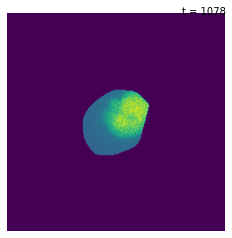

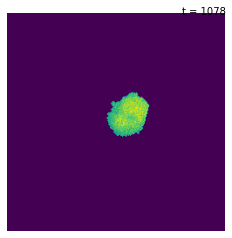

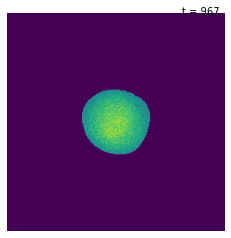

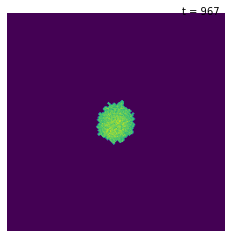

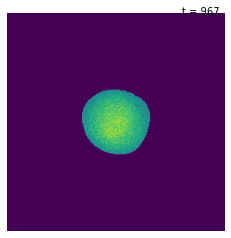

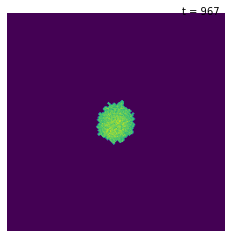

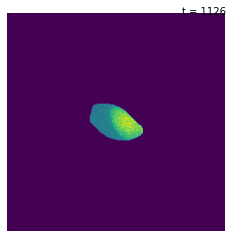

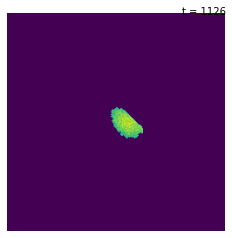

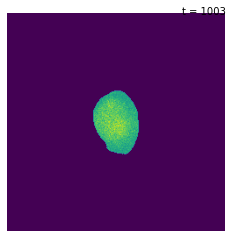

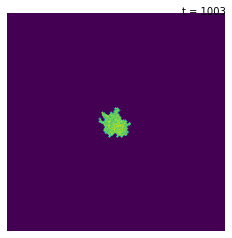

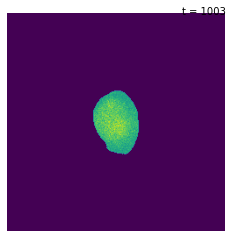

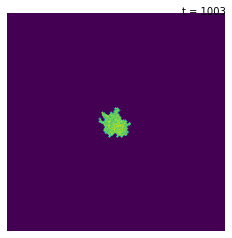

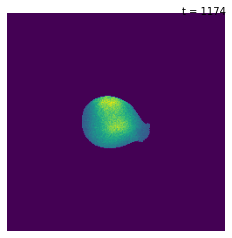

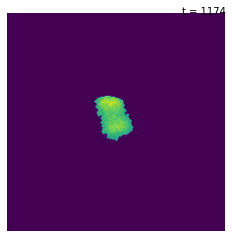

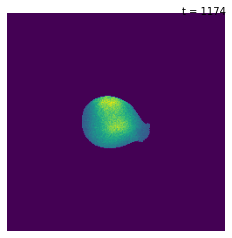

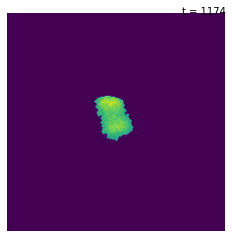

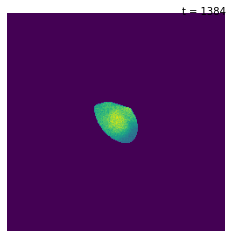

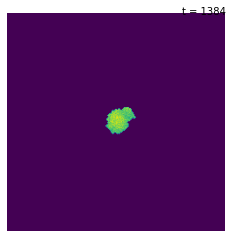

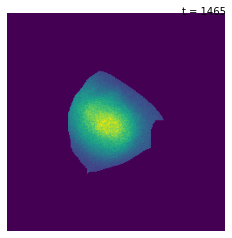

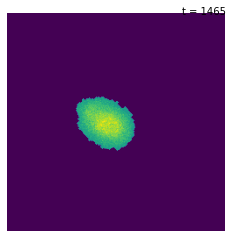

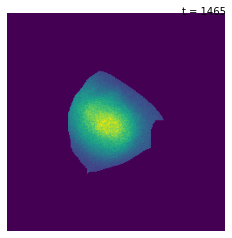

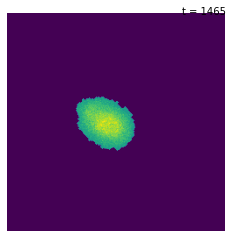

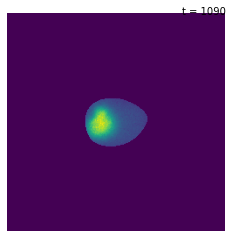

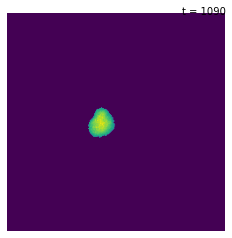

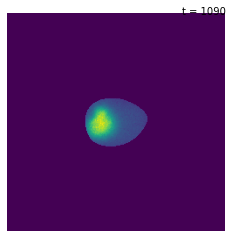

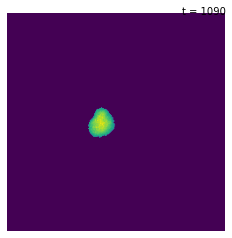

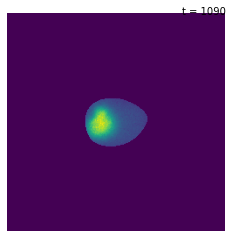

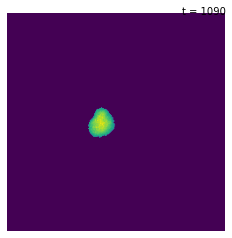

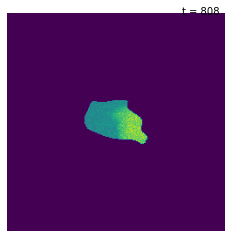

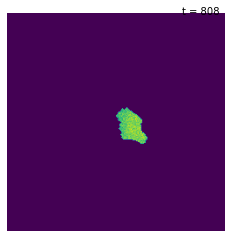

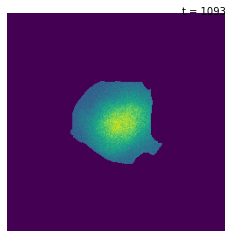

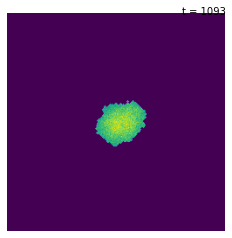

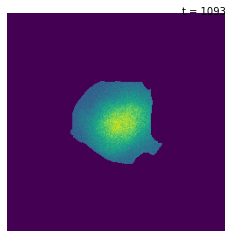

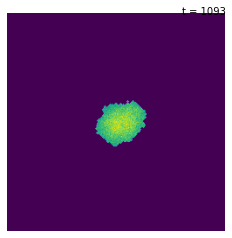

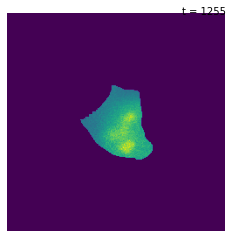

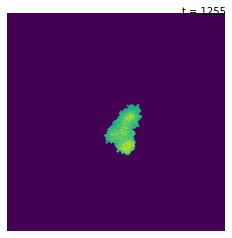

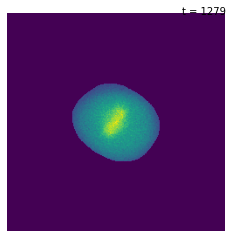

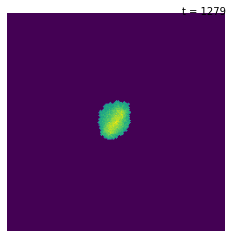

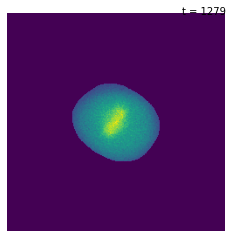

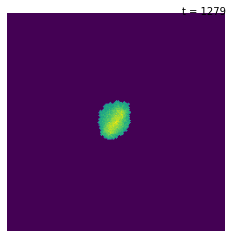

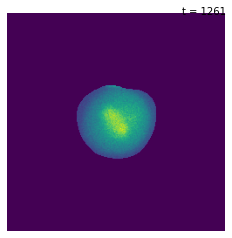

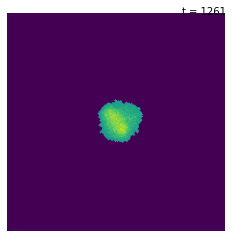

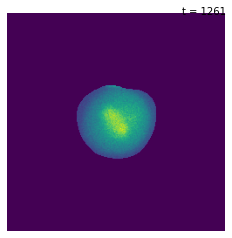

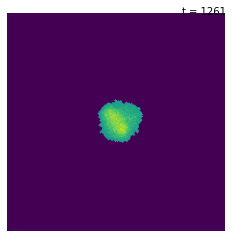

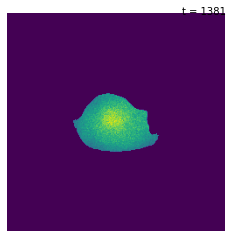

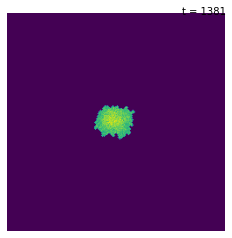

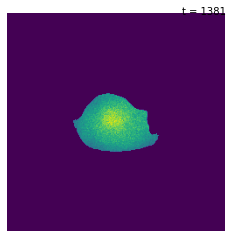

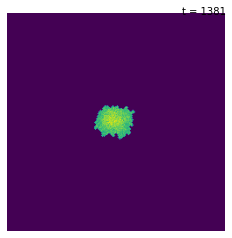

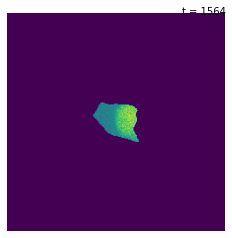

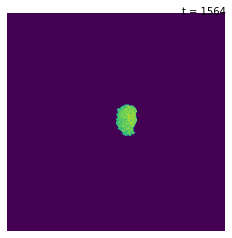

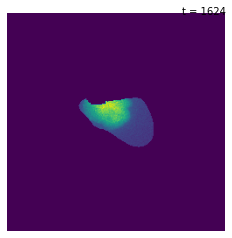

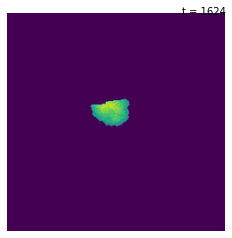

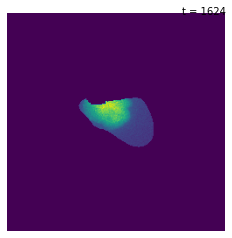

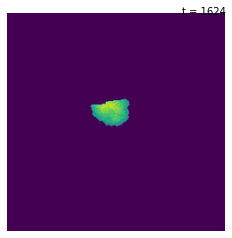

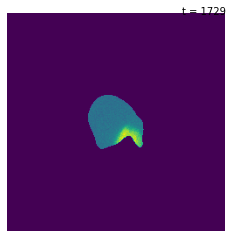

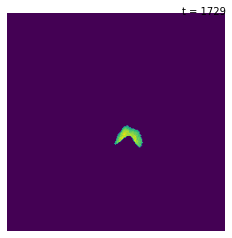

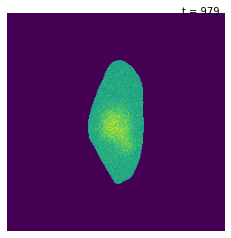

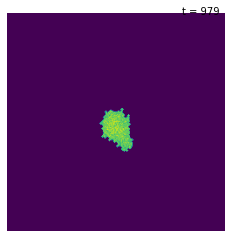

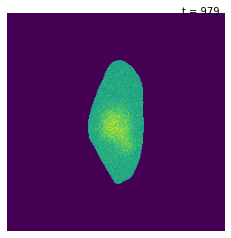

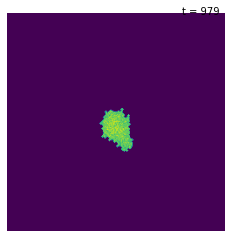

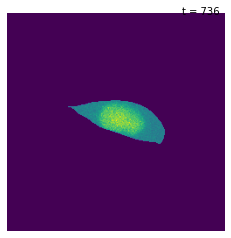

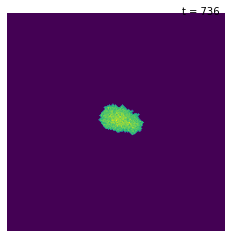

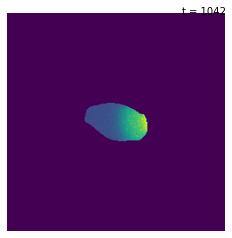

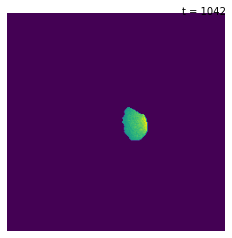

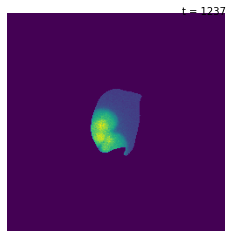

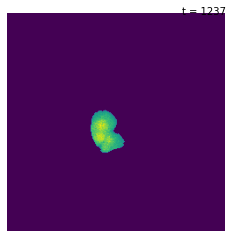

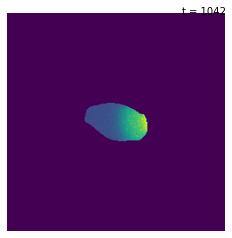

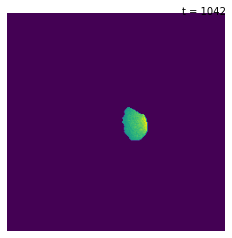

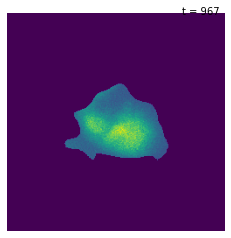

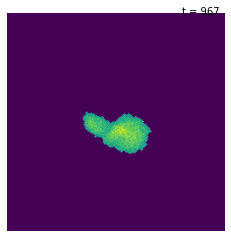

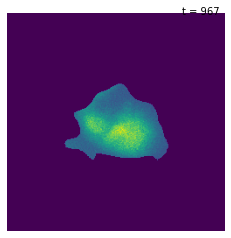

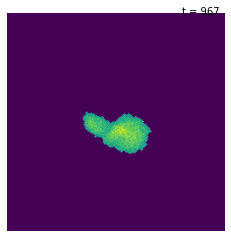

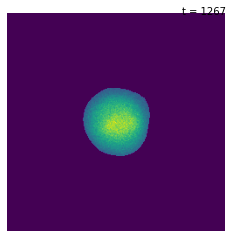

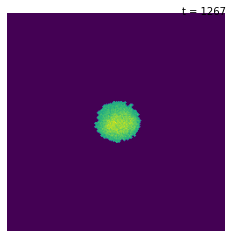

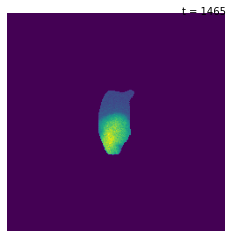

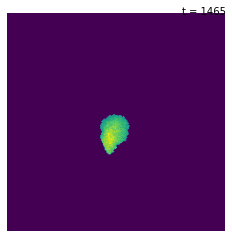

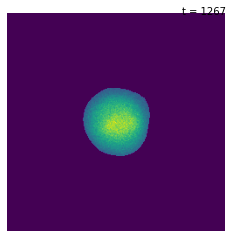

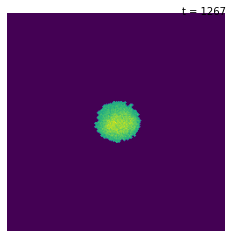

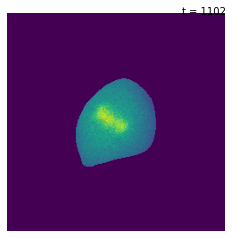

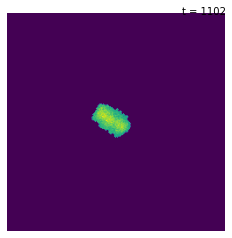

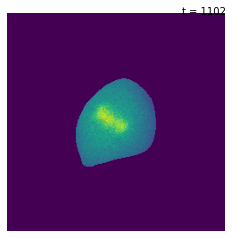

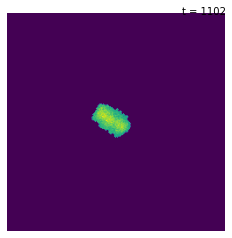

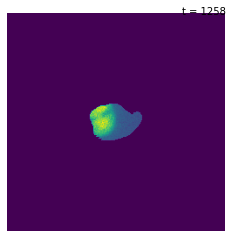

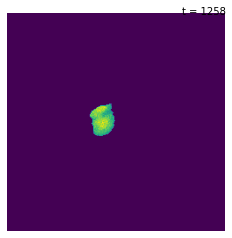

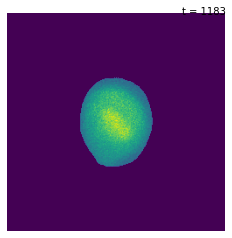

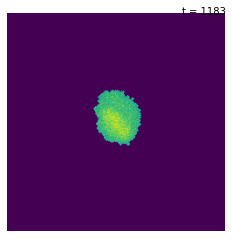

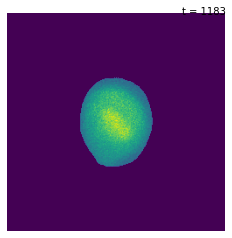

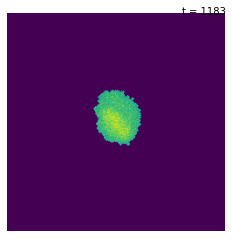

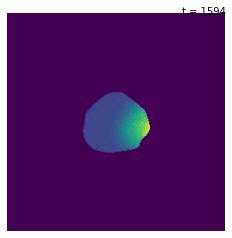

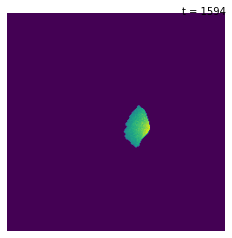

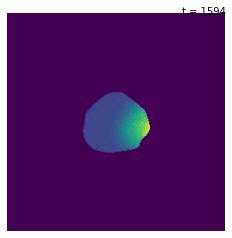

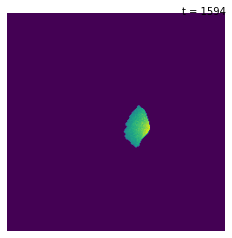

In [11]:
#----------------find long sub traj in a family---------------

mitosis_range=0

for posi in range(1,posi_end+1):
    
    posi_label = 'XY' + str(posi)
    dir_path=output_path+posi_label+'/'
    
    cells_path=dir_path+'cells/'
    fluor_img_path=main_path+'ori/'+posi_label+'_C2/'
    fluor_img_list=sorted(listdir(fluor_img_path))
    seg_path=output_path+posi_label+'/seg/'
    seg_list=sorted(listdir(seg_path))
 
    df=pd.read_csv(dir_path+'Per_Object_relink.csv')
    am_record=pd.read_csv(dir_path+'am_record.csv')
    traj_df=pd.read_csv(dir_path+'traj_object_num.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record.csv')
    with open (cells_path+'fluor_cells', 'rb') as fp:
        cells = pickle.load(fp)

    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values

    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]

    for traj_label in range(1,traj_quan+1):
        print(traj_label)
        cur_traj=traj_record[traj_label-1,:]
        traj_start_t=np.where(cur_traj!=-1)[0][0]+1
        
        family_tree={}
        family_tree=find_offspring(df,mitosis_df,family_tree,traj_label=traj_label)
        print('family',family_tree)
        all_branches=list(list(parse(traj_label, family_tree)))
        print('all branch',all_branches)
        
        for branch in all_branches:
            branch_end_label=branch[-1]
            branch_end_traj=traj_record[branch_end_label-1,:]
            branch_end_t=np.where(branch_end_traj!=-1)[0][-1]+1
            for sub_label in branch:
                
                sub_traj=traj_record[sub_label-1,:]
                daughter_flag=find_mother(mitosis_df,traj_label)
                if daughter_flag==1:
                    mother_trajnum=find_mother_trajnum(mitosis_df,sub_label)
                
                
                sub_start_t=np.where(sub_traj!=-1)[0][0]+1
                sub_end_t=np.where(sub_traj!=-1)[0][-1]+1

                if (sub_end_t-sub_start_t)>=traj_len_thres:

                    long_traj=-1*np.ones((time_span,))
                    divide_points=[]
                    traj_name=str(sub_label)+'_'

                    if sub_start_t!=traj_start_t:
                        divide_points.append(sub_start_t)
                        sub_start_ind=sub_start_t+mitosis_range
                    else:
                        sub_start_ind=sub_start_t-1

                    if sub_end_t!=branch_end_t:
                        divide_points.append(sub_end_t)
                        sub_end_ind=sub_end_t-mitosis_range
                    else:
                        sub_end_ind=sub_end_t-1

                    long_traj[max(0,sub_start_ind):min(time_span-1,sub_end_ind)+1]=sub_traj[max(0,sub_start_ind):min(time_span-1,sub_end_ind)+1]

                    whole_branch=long_traj[max(0,sub_start_ind):min(time_span-1,sub_end_ind)+1]
                    long_traj_loss_ratio=whole_branch[whole_branch==-1].shape[0]*1.0/whole_branch.shape[0]

                    if long_traj_loss_ratio<loss_ratio_thres:

                        traj_feature,traj_contour,\
                            traj_cord,traj_seri,traj_am_flag,\
                            traj_vim_feature_values,traj_vim_pca_cord,\
                            traj_pcna_feature_values,traj_pcna_pca_cord=generate_fluor_long_traj(
                            df,cells,am_record,\
                            traj_df,long_traj,\
                            ['vimentin','pcna'],feature_list,fluor_feature_name)

                        if len(traj_seri) >= 15:
                            traj_sct=fluor_single_cell_traj(traj_seri,traj_contour)
                            traj_sct.set_traj_feature(traj_feature)
                            traj_sct.set_traj_cord(traj_cord)
                            traj_sct.set_traj_divide_points(np.array(divide_points))
                            traj_sct.set_traj_am_flag(traj_am_flag)

                            traj_sct.set_traj_fluor_features('vimentin',feature_list,traj_vim_feature_values)
                            traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[0],traj_vim_pca_cord)

                            traj_sct.set_traj_fluor_features('pcna',feature_list,traj_pcna_feature_values)
                            traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[1],traj_pcna_pca_cord)

                            with open(sct_path+'sub_sct_'+posi_label+'_'+traj_name+'long_traj', 'wb') as fp:
                                pickle.dump(traj_sct, fp)


                            board_size=250

                            fig=plt.figure()
                            ax = fig.add_subplot(111)
                            ims=[]
                            for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:
                                img_num=img_num.astype(np.int)
                                obj_num=obj_num.astype(np.int)
                                if obj_num!=-1:
                                    img=imread(fluor_img_path+fluor_img_list[img_num-1])
                                    seg_img=imread(seg_path+seg_list[img_num-1])
                                    crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
                                    x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
                                    x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                    cell_on_board=np.zeros((board_size,board_size))
                                    cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell
                                    plt.axis('off')
                                    im=plt.imshow(cell_on_board,animated=True)
                                    t = ax.annotate('t = ' + str(img_num),(200,1))
                                    ims.append([im,t])

                            ani = animation.ArtistAnimation(fig, ims)
                            Writer = animation.writers['ffmpeg']
                            writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                            ani.save(cell_ani_path+'sub_pcna_sct_'+posi_label+'_'+traj_name+'long_traj.mp4',writer)

                            fig=plt.figure()
                            ax = fig.add_subplot(111)
                            ims=[]
                            for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:

                                img_num=img_num.astype(np.int)
                                obj_num=obj_num.astype(np.int)

                                img=imread(fluor_img_path+fluor_img_list[img_num-1])
                                seg=imread(seg_path+seg_list[img_num-1])

                                if obj_num!=-1:

                                    rps=regionprops(seg)
                                    candi_r=[r for r in rps if r.label==obj_num][0]
                                    candi_box=candi_r.bbox

                                    cell_mask = (seg == obj_num)
                                    region_cell_mask = cell_mask[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                    crop_img = img[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                                    cell_img = (img*cell_mask)[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]

                                    nuc_mask=cell_img>otsu(cell_img,selem=disk(max(cell_img.shape)/2), mask=cell_img>0)
                                    nuc_mask=remove_small_objects(opening(nuc_mask),100)
                                    nuc_mask=closing(nuc_mask)
                                    nuc_mask=remove_small_holes(nuc_mask,100)

                                    nuc_img=cell_img*nuc_mask

                                    x_c,y_c=nuc_img.shape[0]//2,nuc_img.shape[1]//2
                                    x_l,y_l=board_size//2-x_c,board_size//2-y_c
                                    cell_on_board=np.zeros((board_size,board_size))
                                    cell_on_board[x_l:x_l+nuc_img.shape[0],y_l:y_l+nuc_img.shape[1]]=nuc_img
                                    plt.axis('off')
                                    im=plt.imshow(cell_on_board,animated=True)
                                    t = ax.annotate('t = ' + str(img_num),(200,1))
                                    ims.append([im,t])

            #                 ani = animation.ArtistAnimation(fig, ims)
                            ani = animation.ArtistAnimation(fig, ims)
                            Writer = animation.writers['ffmpeg']
                            writer = Writer(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
                            ani.save(cell_nuc_ani_path+'sub_pcna_sct_'+posi_label+'_'+traj_name+'long_traj.mp4',writer)